In [1]:
import pandas as pd
from pyEDM import *
import h5py
import matplotlib.pyplot as plt

## CCM Sensitivity Analysis 

## Load data for muscle activations (actions) and joint angles (qpos)
H5_Path = "/root/vast/eric/track-mjx/notebooks/rollouts_full_mouse_arm_new.h5"

with h5py.File(H5_Path, "r") as f:
    actions = f["actions"][...]
    qpos = f["qpos"][...]
    ref_qpos = f["ref_qpos"][...]
    decoder_activations = f["decoder_activations"]
    layer_0 = f["decoder_activations/layer_0"][:]
    layer_1 = f["decoder_activations/layer_1"][:]
    layer_2 = f["decoder_activations/layer_2"][:]
    intentions = f["intentions"][:]

    print(intentions.shape)
    print(decoder_activations.keys())
    print(layer_0.shape)
    print(layer_1.shape)
    print(layer_2.shape)

#actions is a 46 clips by 100 frames by 9 actions
print(f"Action shape: {actions.shape}")

#qpos is a 46 clips by 100 frames by 4 joint angles
print(f"Qpos shape: {qpos.shape}")
action_name = ["Pec_C", "Lat", "PD", "AD", "MD", "Triceps_Lateral", "Triceps_Long", "Brachialis", "Biceps_Long"]
qpos_name = ["sh_elv", "sh_ext", "sh_rot", "elbow"]

(46, 100, 9)
<KeysViewHDF5 ['layer_0', 'layer_1', 'layer_2']>
(46, 100, 512)
(46, 100, 512)
(46, 100, 512)
Action shape: (46, 100, 9)
Qpos shape: (46, 100, 4)


In [2]:

## Load data for muscle activations (actions) and joint angles (qpos)
H5_Path = "rollouts_full_mouse_arm_new.h5"

with h5py.File(H5_Path, "r") as f:
    print(f.keys())

<KeysViewHDF5 ['actions', 'decoder_activations', 'encoder_activations', 'intentions', 'qpos', 'ref_qpos', 'rewards']>


In [3]:
import numpy as np, pandas as pd

def concat_with_large_nan_padding(actions, qpos, pad=300, standardize=True):
    """
    Concatenate all clips into one long DataFrame with big NaN blocks between clips.
    Safe for pyEDM with ignoreNan=True.

    Args:
        actions: (N, T, 9)
        qpos:    (N, T, 4)
        pad:     number of NaN rows to insert between clips
        standardize: z-score each series per clip

    Returns:
        big_df: DataFrame with columns ['time','act0'..'act8','joint0'..'joint3']
        clip_ranges: dict {clip_idx: (start,end)} 1-based row indices (excluding NaNs)
    """
    N, T, A = actions.shape
    _, T2, J = qpos.shape
    assert T == T2 and A == 9 and J == 4

    def _z(x):
        mu, sd = np.nanmean(x), np.nanstd(x)
        return (x - mu)/sd if sd > 1e-12 else (x - mu)

    frames = []
    clip_ranges = {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({
                "time": np.arange(row_cursor+1, row_cursor+pad+1),
                **{f"act{i}": np.nan for i in range(A)},
                **{f"joint{j}": np.nan for j in range(J)},
            })
            frames.append(pad_df)
            row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        for i in range(A):
            data[f"act{i}"] = _z(actions[c,:,i]) if standardize else actions[c,:,i]
        for j in range(J):
            data[f"joint{j}"] = _z(qpos[c,:,j]) if standardize else qpos[c,:,j]
        clip_df = pd.DataFrame(data)

        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)

        frames.append(clip_df)
        row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

big_df, clip_ranges = concat_with_large_nan_padding(actions, qpos, pad=1)

_keys = big_df.columns.tolist()

from pyEDM import EmbedDimension

for key in _keys:
    # Example: run EmbedDimension on act0 across *all clips* pooled
    res = EmbedDimension(
        dataFrame=big_df,
        columns=key, target=key,
        lib="1 3000", pred="3001 4645",   # pick ranges that are inside big_df length
    ignoreNan=True, numProcess=1, showPlot=False
    )
    embedding_dim = res["rho"].argmax() + 1
    print(f"Embedding dimension for {key}: {embedding_dim}")


/tmp/ipykernel_1904807/3683800810.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)


Embedding dimension for time: 1
Embedding dimension for act0: 8
Embedding dimension for act1: 10
Embedding dimension for act2: 4
Embedding dimension for act3: 10
Embedding dimension for act4: 7
Embedding dimension for act5: 7
Embedding dimension for act6: 7
Embedding dimension for act7: 6
Embedding dimension for act8: 7
Embedding dimension for joint0: 2
Embedding dimension for joint1: 2
Embedding dimension for joint2: 2
Embedding dimension for joint3: 2


In [5]:
print(action_name)
print(qpos_name)

['Pec_C', 'Lat', 'PD', 'AD', 'MD', 'Triceps_Lateral', 'Triceps_Long', 'Brachialis', 'Biceps_Long']
['sh_elv', 'sh_ext', 'sh_rot', 'elbow']


In [7]:
print(action_name)
print(qpos_name)

['Pec_C', 'Lat', 'PD', 'AD', 'MD', 'Triceps_Lateral', 'Triceps_Long', 'Brachialis', 'Biceps_Long']
['sh_elv', 'sh_ext', 'sh_rot', 'elbow']


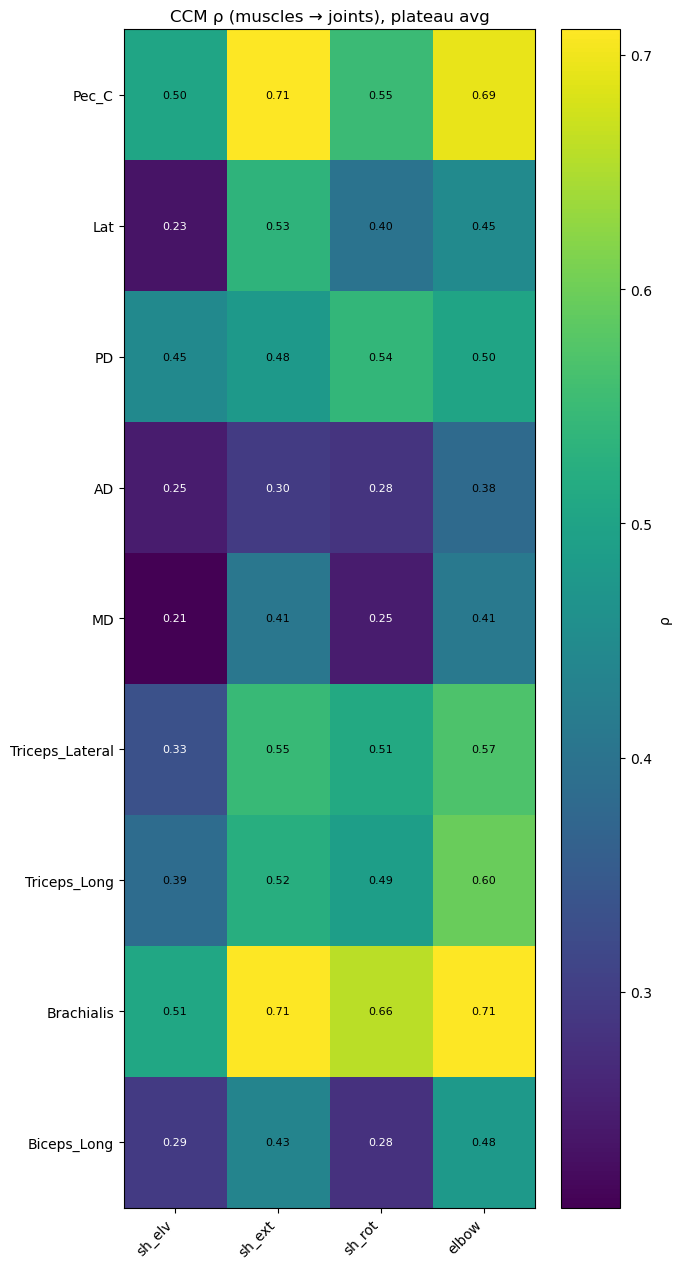

In [13]:
# === Plot CCM heatmap directly from CSV (no renaming) ==========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ccm_heatmap_from_csv(
    csv_path: str,
    title: str = "CCM ρ (actions → joints), plateau avg",
    output_png: str | None = None,
    annotate: bool = True,
) -> pd.DataFrame:
    """
    Load a (rows × columns) CCM matrix from CSV and plot a labeled heatmap.
    Labels (row index and column names) are used exactly as in the CSV.

    Args:
        csv_path: Path to CSV. First column must be row labels (e.g., muscles).
        title: Figure title string.
        output_png: If provided, save figure to this path; otherwise <csv_basename>.png.
        annotate: If True, annotate each cell with its numeric value.

    Returns:
        The DataFrame used to draw the heatmap.
    """
    # 1) Load exactly as-is (no renaming)
    df = pd.read_csv(csv_path, index_col=0)
    # Coerce to float where possible (keeps labels intact)
    df = df.apply(pd.to_numeric, errors="coerce")

    # 2) Plot
    fig_w = 1.2 * len(df.columns) + 2
    fig_h = 1.2 * len(df.index) + 2
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(df.values, aspect="auto")
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index)
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("ρ")

    # 3) Optional annotations with contrast-aware text color
    if annotate:
        vals = df.values
        vmin = np.nanmin(vals) if np.isfinite(vals).any() else 0.0
        vmax = np.nanmax(vals) if np.isfinite(vals).any() else 1.0
        thresh = (vmin + vmax) / 2.5
        for i in range(vals.shape[0]):
            for j in range(vals.shape[1]):
                v = vals[i, j]
                txt = "nan" if np.isnan(v) else f"{v:.2f}"
                color = "black" if (not np.isnan(v) and v >= thresh) else "white"
                ax.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)

    plt.tight_layout()

    # 4) Save if requested (default = same basename as CSV)
    if output_png is None:
        base, _ = os.path.splitext(os.path.basename(csv_path))
        output_png = f"{base}.png"
    plt.savefig(output_png, dpi=150)
    plt.show()

    return df

# ---- Use it -------------------------------------------------------------
_ = plot_ccm_heatmap_from_csv(
    "ccm_actions_to_joints.csv",
    title="CCM ρ (muscles → joints), plateau avg",
    output_png="ccm_actions_to_joints.png",
    annotate=True,
)


/tmp/ipykernel_1904807/4178237556.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)
Simplex EMG→joints: 100%|██████████| 3/3 [00:00<00:00, 13.31it/s]


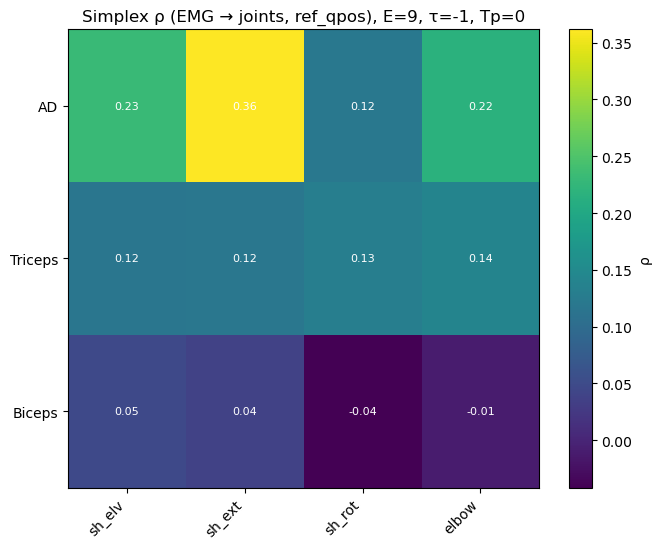

         sh_elv  sh_ext  sh_rot  elbow
AD        0.232   0.362   0.120  0.215
Triceps   0.117   0.118   0.131  0.141
Biceps    0.048   0.039  -0.042 -0.010


In [5]:
# === EMG → ref_qpos Simplex heatmap ===========================================
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Paths & config ----------------
H5_PATH = "rollouts_full_mouse_arm_new_250826_030533_134914.h5"
REACHES_CSV = "/root/vast/eric/CVAT_mouse_reach/csvs/reaches_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv"

# Pick ONE Triceps, ONE Biceps, and Anterior Deltoid file:
EMG_FILES = {
    "AD":      "/root/vast/eric/CVAT_mouse_reach/csvs/emg_trap_fixed_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv",
    "Triceps": "/root/vast/eric/CVAT_mouse_reach/csvs/emg_triceps_fixed_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv",
    "Biceps":  "/root/vast/eric/CVAT_mouse_reach/csvs/emg_biceps_fixed_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv",
}

# Joint names to display (order must match last-dim of qpos arrays)
qpos_names = ["sh_elv", "sh_ext", "sh_rot", "elbow"]

# EMG preprocessing
fs_emg = 30000
target_fs = 200
downsample_factor = fs_emg // target_fs  # 75
target_samples = 100                     # 0.5 s at 400 Hz
highpass_cutoff = 20
lowpass_cutoff  = 1000
envelope_cutoff = 50
filter_order    = 4

# Simplex params
E_action = 8
tau_action = -10
Tp = 0

# NaN padding between clips in the concatenated DF
PAD = 1

# ---------------- Load reaches ----------------
reaches_df = pd.read_csv(REACHES_CSV)
valid_reaches = reaches_df.dropna(subset=["reach_start_idx", "reach_end_idx"])

# ---------------- Helpers ----------------
def butter_bandpass(sig, fs, lo, hi, order=4):
    b, a = signal.butter(order, [lo, hi], btype='bandpass', fs=fs)
    return signal.filtfilt(b, a, sig)

def butter_lowpass(sig, fs, cutoff, order=4):
    b, a = signal.butter(order, cutoff, btype='lowpass', fs=fs)
    return signal.filtfilt(b, a, sig)

def process_emg_trials(emg_file_path):
    """
    Returns dict {trial_idx -> normalized envelope (200,)} for trials
    where we can extract a 0.5s window starting at reach_start_idx.
    Normalization: divide each trial by max(mean + 1*std) across accepted trials.
    """
    emg_df = pd.read_csv(emg_file_path, header=None)
    trial_to_env = {}
    raw_envs, trial_ids = [], []

    for idx, row in valid_reaches.iterrows():
        trial_num = idx
        if trial_num >= len(emg_df):
            continue

        # convert 200 Hz indices into 30 kHz samples
        emg_reach_start = int((1/200.0) * row["reach_start_idx"] * fs_emg)
        emg_reach_end   = emg_reach_start + int(0.5 * fs_emg)  # 0.5 s window

        trial_emg = emg_df.iloc[trial_num, :].to_numpy()
        if emg_reach_end > len(trial_emg):
            continue

        seg = trial_emg[emg_reach_start:emg_reach_end]
        if seg.size < int(0.5 * fs_emg):
            continue

        bp   = butter_bandpass(seg, fs_emg, highpass_cutoff, lowpass_cutoff, filter_order)
        rect = np.abs(bp)
        env  = butter_lowpass(rect, fs_emg, envelope_cutoff, filter_order)

        # downsample by averaging blocks of size 75 -> 200 samples
        n_chunks = len(env) // downsample_factor
        env = env[:n_chunks * downsample_factor].reshape(n_chunks, downsample_factor).mean(axis=1)
        if len(env) < target_samples:
            continue
        env = env[:target_samples]  # crop to 200

        raw_envs.append(env)
        trial_ids.append(trial_num)

    if not raw_envs:
        return {}

    raw_envs = np.stack(raw_envs, axis=0)  # (N, 200)
    mean_env = raw_envs.mean(axis=0)
    std_env  = raw_envs.std(axis=0)
    norm_val = np.max(mean_env + 1.0 * std_env) or 1.0
    norm_envs = raw_envs / norm_val

    for t_id, arr in zip(trial_ids, norm_envs):
        trial_to_env[int(t_id)] = arr.astype(float)

    return trial_to_env

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_nan_padded(emg_stack, qpos_stack, pad=100, standardize=True):
    """
    emg_stack: dict {name -> (N, T)}
    qpos_stack: (N, T, J)
    Returns big_df and clip_ranges (1-based indices per clip).
    """
    names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in names:
                pad_df[nm] = np.nan
            for j in range(J):
                pad_df[qpos_names[j]] = np.nan
            frames.append(pad_df)
            row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        for nm in names:
            x = emg_stack[nm][c]
            data[nm] = zscore(x) if standardize else x
        for j in range(J):
            k = qpos_stack[c, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df)
        row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

def build_lib_pred_from_nan_blocks(df, probe_col, split=0.6, min_edge=8):
    """
    Split each non-NaN block 60/40 into lib/pred. Returns pyEDM strings.
    """
    x = df[probe_col].to_numpy()
    notnan = ~np.isnan(x)
    edges = np.diff(np.concatenate([[0], notnan.view(np.int8), [0]]))
    starts = np.where(edges == 1)[0] + 1  # 1-based
    ends   = np.where(edges == -1)[0]     # 1-based

    lib_parts, pred_parts = [], []
    for s, e in zip(starts, ends):
        n = e - s + 1
        if n < 2 * min_edge:
            continue
        m = s + int(np.floor(split * n)) - 1
        m = max(m, s + min_edge - 1)
        m = min(m, e - min_edge)
        if m <= s or m >= e:
            continue
        lib_parts.extend([str(s), str(m)])
        pred_parts.extend([str(m + 1), str(e)])
    return " ".join(lib_parts), " ".join(pred_parts)

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def simplex_heatmap(df, emg_cols, joint_cols, lib, pred, E=3, tau=-1, Tp=1,
                    out_csv="simplex_emg_to_refqpos.csv", out_png="simplex_emg_to_refqpos.png"):
    mat = np.full((len(emg_cols), len(joint_cols)), np.nan, dtype=float)
    for ei, e_col in enumerate(tqdm(emg_cols, desc="Simplex EMG→joints")):
        for ji, j_col in enumerate(joint_cols):
            pred_df = Simplex(
                dataFrame=df, lib=lib, pred=pred,
                columns=e_col, target=j_col,
                E=E, tau=tau, Tp=Tp,
                ignoreNan=True, showPlot=False
            )
            obs = pred_df["Observations"].to_numpy()
            hat = pred_df["Predictions"].to_numpy()
            mat[ei, ji] = _safe_corr(obs, hat, min_pairs=10)

    M = pd.DataFrame(mat, index=emg_cols, columns=joint_cols)
    M.to_csv(out_csv, float_format="%.6f")

    # Heatmap (white text)
    fig, ax = plt.subplots(figsize=(1.2*len(joint_cols)+2, 1.2*len(emg_cols)+2))
    im = ax.imshow(M.values, aspect="auto")
    ax.set_xticks(range(len(joint_cols))); ax.set_xticklabels(joint_cols, rotation=45, ha="right")
    ax.set_yticks(range(len(emg_cols)));  ax.set_yticklabels(emg_cols)
    ax.set_title(f"Simplex ρ (EMG → joints, ref_qpos), E={E}, τ={tau}, Tp={Tp}")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
    for i in range(len(emg_cols)):
        for j in range(len(joint_cols)):
            v = M.values[i, j]
            ax.text(j, i, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", fontsize=8, color="white")
    plt.tight_layout(); plt.savefig(out_png, dpi=150); plt.show()
    return M

# ---------------- Load EMG per trial (normalized) ----------------
emg_trials = {name: process_emg_trials(path) for name, path in EMG_FILES.items()}
common_trials = set.intersection(*[set(d.keys()) for d in emg_trials.values()])
if not common_trials:
    raise RuntimeError("No common trials across EMG channels. Check files or preprocessing.")
common_trials = sorted(common_trials)

# stack into (N, T) per muscle
emg_stack = {name: np.stack([emg_trials[name][t] for t in common_trials], axis=0)
             for name in EMG_FILES.keys()}
N_emg, T_emg = next(iter(emg_stack.values())).shape

# ---------------- Load ref_qpos explicitly (no guessing) ----------------
with h5py.File(H5_PATH, "r") as f:
    if "ref_qpos" not in f:
        raise KeyError("Dataset 'ref_qpos' not found in H5.")
    ref_qpos = f["ref_qpos"][...]  # expected shape (N_trials, T, 4)

# If needed, resample ref_qpos to 200 steps
def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L:
        return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

if ref_qpos.shape[-2] != target_samples:
    ref_qpos = np.stack([resample_to_len(ref_qpos[i], target_samples) for i in range(ref_qpos.shape[0])], axis=0)

# Align trials by index if possible; else fall back to order
if max(common_trials) < ref_qpos.shape[0]:
    ref_sel = ref_qpos[common_trials]                     # (N_common, 200, 4)
else:
    K = min(len(common_trials), ref_qpos.shape[0])
    ref_sel = ref_qpos[:K]
    for k in emg_stack:
        emg_stack[k] = emg_stack[k][:K]

# ---------------- Build NaN-padded long DataFrame ----------------
big_df, clip_ranges = concat_nan_padded(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    pad=PAD,
    standardize=True
)

# ---------------- Build lib/pred (60/40 per clip) ----------------
probe_col = list(emg_stack.keys())[0]
lib, pred = build_lib_pred_from_nan_blocks(big_df, probe_col=probe_col, split=0.6, min_edge=8)

# ---------------- Run Simplex heatmap (EMG → ref_qpos) ----------------
emg_cols   = list(EMG_FILES.keys())          # ['AD','Triceps','Biceps']
joint_cols = qpos_names                      # ['sh_elv','sh_ext','sh_rot','elbow']

M_emg = simplex_heatmap(
    df=big_df,
    emg_cols=emg_cols,
    joint_cols=joint_cols,
    lib=lib, pred=pred,
    E=9, tau=-1, Tp=Tp,
    out_csv="simplex_emg_to_refqpos.csv",
    out_png="simplex_emg_to_refqpos.png"
)
print(M_emg.round(3))


In [11]:
# === FIX: Create appropriate lib/pred ranges for current big_df ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    """Create manual time-delay embedding columns: [t0, t-1*lag, ..., t-(E-1)*lag]."""
    if prefix is None:
        prefix = base_col
    new_cols = []
    for k in range(E):
        name = f"{prefix}_t{-k}"
        df[name] = df[base_col].shift(k)  # k rows back = t-k
        new_cols.append(name)
    return new_cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def build_lib_pred_from_nan_blocks(df, probe_col, split=0.8, min_edge=8):
    """Build lib/pred ranges by splitting each non-NaN block 60/40."""
    x = df[probe_col].to_numpy()
    notnan = ~np.isnan(x)
    edges = np.diff(np.concatenate([[0], notnan.view(np.int8), [0]]))
    starts = np.where(edges == 1)[0] + 1  # 1-based
    ends   = np.where(edges == -1)[0]     # 1-based

    lib_parts, pred_parts = [], []
    for s, e in zip(starts, ends):
        n = e - s + 1
        if n < 2 * min_edge:
            continue
        m = s + int(np.floor(split * n)) - 1
        m = max(m, s + min_edge - 1)
        m = min(m, e - min_edge)
        if m <= s or m >= e:
            continue
        lib_parts.extend([str(s), str(m)])
        pred_parts.extend([str(m + 1), str(e)])
    return " ".join(lib_parts), " ".join(pred_parts)

def simplex_heatmap_embedded(
    df: pd.DataFrame,
    source_to_cols: dict[str, list[str]],   # source name -> its embedded col names
    targets: list[str],
    lib: str, pred: str,
    title: str,
    out_csv: str, out_png: str
) -> pd.DataFrame:
    # Check for missing columns
    flat_src_cols = {c for cols in source_to_cols.values() for c in cols}
    need = flat_src_cols | set(targets)
    missing = sorted(need - set(df.columns))
    if missing:
        raise ValueError(f"Missing columns in big_df: {missing}")

    src_names = list(source_to_cols.keys())
    mat = np.full((len(src_names), len(targets)), np.nan, dtype=float)

    for si, s_name in enumerate(tqdm(src_names, desc=title)):
        s_cols = source_to_cols[s_name]         # these ARE the embedding
        E_dim  = len(s_cols)                    # E = number of columns with embedded=True
        for ti, t_col in enumerate(targets):
            pred_df = Simplex(
                dataFrame=df,
                lib=lib, pred=pred,
                columns=" ".join(s_cols),
                target=t_col,
                E=E_dim, tau=0, Tp=1,
                embedded=True,                # <-- use manual embedding
                ignoreNan=True, showPlot=True  # Changed to False to reduce output
            )
            obs = pred_df["Observations"].to_numpy()
            hat = pred_df["Predictions"].to_numpy()
            mat[si, ti] = _safe_corr(obs, hat, min_pairs=10)

    M = pd.DataFrame(mat, index=src_names, columns=targets)
    M.to_csv(out_csv, float_format="%.6f")

    # heatmap
    fig, ax = plt.subplots(figsize=(1.2*len(targets)+2, 1.2*len(src_names)+2))
    im = ax.imshow(M.values, aspect="auto")
    ax.set_xticks(range(len(targets))); ax.set_xticklabels(targets, rotation=45, ha="right")
    ax.set_yticks(range(len(src_names))); ax.set_yticklabels(src_names)
    ax.set_title(title + "  (embedded=True)")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
    for i in range(len(src_names)):
        for j in range(len(targets)):
            v = M.values[i, j]
            ax.text(j, i, "nan" if np.isnan(v) else f"{v:.2f}",
                    ha="center", va="center", fontsize=8, color="white")
    plt.tight_layout(); plt.savefig(out_png, dpi=150); plt.show()
    return M

# ---- Check current big_df size and create appropriate lib/pred -------------------
print(f"Current big_df shape: {big_df.shape}")
print(f"EMG columns available: {[col for col in big_df.columns if col in ['AD', 'Triceps', 'Biceps']]}")
print(f"Joint columns available: {[col for col in big_df.columns if col in qpos_names]}")

# Create new lib/pred ranges that fit the current DataFrame
# Use the first available EMG column as probe
emg_cols_available = [col for col in ['AD', 'Triceps', 'Biceps'] if col in big_df.columns]
if not emg_cols_available:
    emg_cols_available = [col for col in big_df.columns if 'emg' in col.lower() or col.startswith('act')]

if emg_cols_available:
    probe_col = emg_cols_available[0]
else:
    # Fall back to first qpos column
    probe_col = qpos_names[0]

print(f"Using probe column: {probe_col}")

# Build new lib/pred ranges
new_lib, new_pred = build_lib_pred_from_nan_blocks(big_df, probe_col=probe_col, split=0.8, min_edge=8)
print(f"New lib ranges: {new_lib}")
print(f"New pred ranges: {new_pred}")

# ---- rebuild the manual embeddings -------------------------------------------
lag_step = 1

# joints: 2-D embedding per joint
joint_embed_cols = {}
for j in qpos_names:  # assumes these are in big_df
    if j in big_df.columns:
        joint_embed_cols[j] = make_lagged_columns(
            big_df, base_col=j, E=2, lag_step=lag_step, prefix=f"{j}_emb2"
        )

# EMG: 7-D embedding per available EMG channel
emg_embed_cols = {}
for e in emg_cols_available:    # use only available EMG columns
    emg_embed_cols[e] = make_lagged_columns(
        big_df, base_col=e, E=10, lag_step=lag_step, prefix=f"{e}_emb7"
    )

print(f"Joint embeddings created for: {list(joint_embed_cols.keys())}")
print(f"EMG embeddings created for: {list(emg_embed_cols.keys())}")

# ---- run the two directions with embedded=True using new lib/pred --------------
if joint_embed_cols and emg_embed_cols:
    # 1) joints → EMG
    M_j2e_emb = simplex_heatmap_embedded(
        df=big_df,
        source_to_cols=joint_embed_cols,
        targets=list(emg_embed_cols.keys()),
        lib=new_lib, pred=new_pred,
        title="Simplex ρ (ref_qpos joints → EMG)",
        out_csv="simplex_refqpos_to_emg_embedded.csv",
        out_png="simplex_refqpos_to_emg_embedded.png"
    )
    print("joints → EMG (embedded=True)\n", M_j2e_emb.round(3), "\n")

    # 2) EMG → joints
    M_e2j_emb = simplex_heatmap_embedded(
        df=big_df,
        source_to_cols=emg_embed_cols,
        targets=list(joint_embed_cols.keys()),
        lib=new_lib, pred=new_pred,
        title="Simplex ρ (EMG → ref_qpos joints)",
        out_csv="simplex_emg_to_refqpos_embedded.csv",
        out_png="simplex_emg_to_refqpos_embedded.png"
    )
    print("EMG → joints (embedded=True)\n", M_e2j_emb.round(3))
else:
    print("ERROR: Could not create embeddings. Check that the required columns exist in big_df.")
    print("Available columns:", big_df.columns.tolist())

Current big_df shape: (4645, 14)
EMG columns available: []


NameError: name 'qpos_names' is not defined

Simplex traces (collect): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


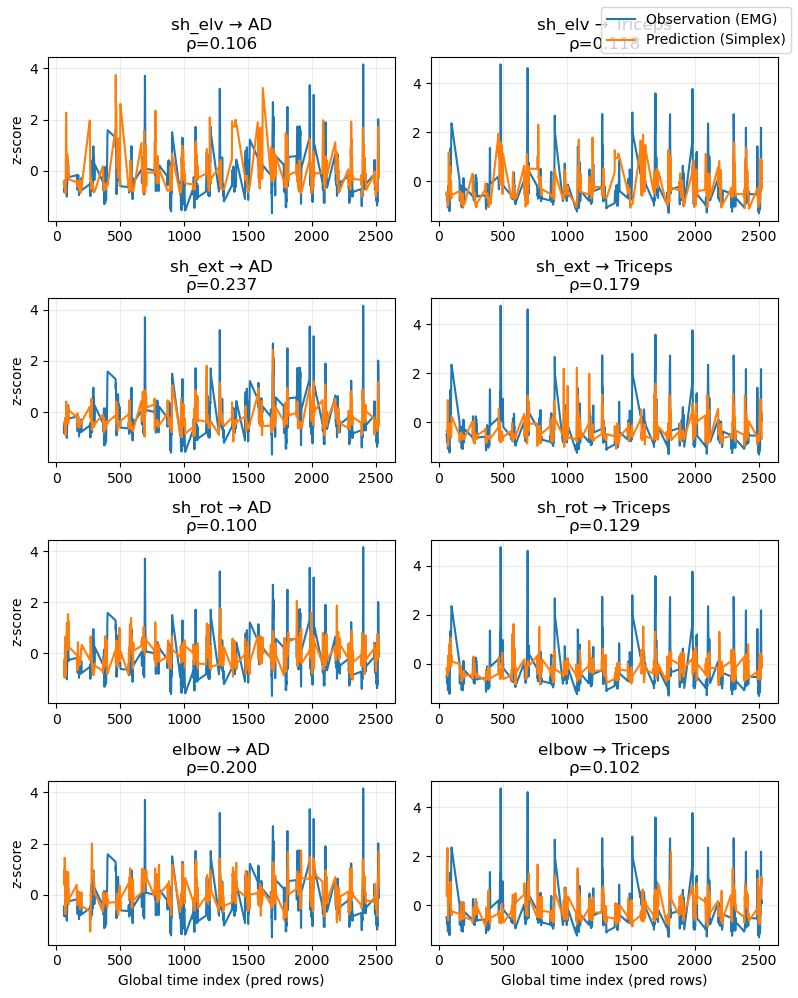

In [17]:
# === Plot Simplex predictions vs observations (first 1000 test samples) =========
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# Reuse your safe corr
def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def simplex_traces_joints_to_emg(
    df: pd.DataFrame,
    joint_cols: list[str],
    emg_cols: list[str],
    lib: str,
    pred: str,
    E: int,
    tau: int,
    Tp: int,
    first_N: int = 1000,
    out_dir: str = "simplex_traces"
):
    """
    For each (joint -> EMG) pair, run Simplex and plot Observations vs Predictions
    for the first_N rows of the prediction set. Saves one PNG per pair and a grid PNG.
    """
    os.makedirs(out_dir, exist_ok=True)
    pair_results = {}  # (joint, emg) -> dict(pred_df, rho)

    # 1) Collect predictions for each pair
    for j_col in tqdm(joint_cols, desc="Simplex traces (collect)"):
        for e_col in emg_cols:
            pred_df = Simplex(
                dataFrame=df, lib=lib, pred=pred,
                columns=j_col, target=e_col,
                E=E, tau=tau, Tp=Tp,
                ignoreNan=True, showPlot=False
            )
            obs = pred_df["Observations"].to_numpy()
            hat = pred_df["Predictions"].to_numpy()
            rho = _safe_corr(obs, hat, min_pairs=10)
            pair_results[(j_col, e_col)] = {"df": pred_df, "rho": rho}

            # 2) Per-pair plot (first_N)
            K = min(first_N, len(pred_df))
            t = pred_df["Time"] if "Time" in pred_df.columns else pd.Series(np.arange(len(pred_df)))
            t = t.iloc[:K].to_numpy()
            fig, ax = plt.subplots(figsize=(10, 3.5))
            ax.plot(t, obs[:K], label="Observation (EMG)", linewidth=2)
            ax.plot(t, hat[:K], label="Prediction (Simplex)", linewidth=2)
            ax.set_title(f"{j_col} → {e_col}  |  ρ={rho:.3f}  |  first {K} pred samples")
            ax.set_xlabel("Global time index (pred rows)")
            ax.set_ylabel("z-score")
            ax.legend(frameon=False)
            ax.grid(alpha=0.3)
            fig.tight_layout()
            fig.savefig(os.path.join(out_dir, f"trace_{j_col}_to_{e_col}.png"), dpi=150)
            plt.close(fig)

    # 3) Grid plot (rows=joints, cols=EMGs)
    n_rows, n_cols = len(joint_cols), len(emg_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2.5*n_rows), squeeze=False)
    for r, j_col in enumerate(joint_cols):
        for c, e_col in enumerate(emg_cols):
            ax = axes[r, c]
            pred_df = pair_results[(j_col, e_col)]["df"]
            rho     = pair_results[(j_col, e_col)]["rho"]
            obs = pred_df["Observations"].to_numpy()
            hat = pred_df["Predictions"].to_numpy()
            K = min(first_N, len(pred_df))
            t = pred_df["Time"] if "Time" in pred_df.columns else pd.Series(np.arange(len(pred_df)))
            t = t.iloc[:K].to_numpy()

            ax.plot(t, obs[:K], linewidth=1.5)
            ax.plot(t, hat[:K], linewidth=1.5)
            ax.set_title(f"{j_col} → {e_col}\nρ={rho:.3f}")
            if r == n_rows - 1:
                ax.set_xlabel("Global time index (pred rows)")
            if c == 0:
                ax.set_ylabel("z-score")
            ax.grid(alpha=0.25)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    if not handles:
        # add a tiny hidden legend by replotting two lines on an invisible axis
        fig.legend(["Observation (EMG)", "Prediction (Simplex)"], loc="upper right")
    else:
        fig.legend(handles, labels, loc="upper right")
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, "grid_traces_firstN.png"), dpi=150)
    plt.show()

    return pair_results

# --- Run it (reuses your big_df/lib/pred & params) -------------------------------
pair_results = simplex_traces_joints_to_emg(
    df=big_df,
    joint_cols=joint_cols,        # e.g., ['sh_elv','sh_ext','sh_rot','elbow']
    emg_cols=emg_cols,            # e.g., ['AD','Triceps','Biceps']
    lib=lib, pred=pred,
    E=9, tau=-1, Tp=Tp,          # or your chosen E/tau/Tp
    first_N=1000,
    out_dir="simplex_traces"
)


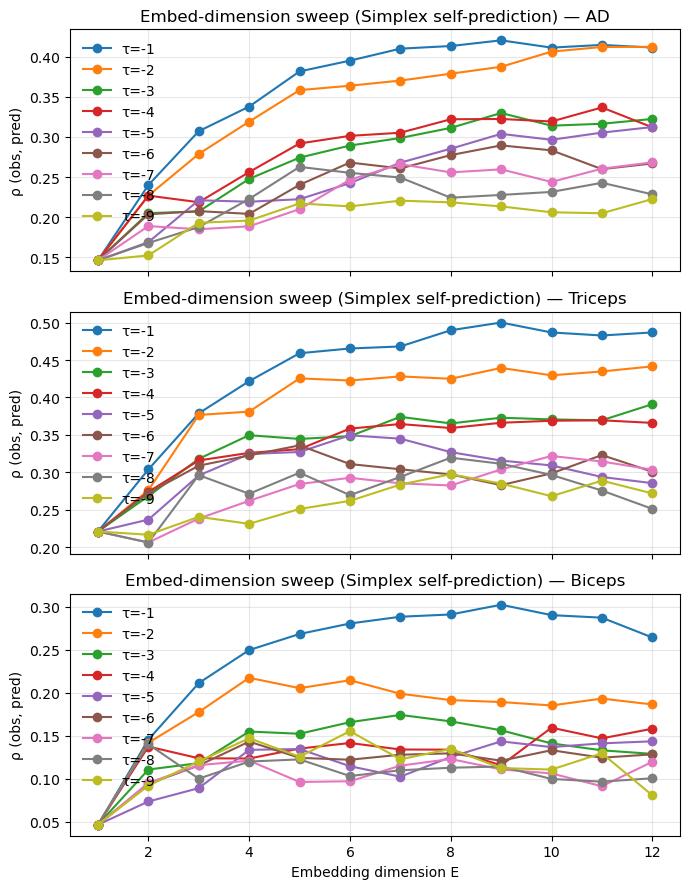


Best (E, rho) per EMG and τ:
    EMG  tau  E_best  rho_best
     AD   -1       9  0.420351
     AD   -2      12  0.412241
     AD   -4      11  0.336756
     AD   -3       9  0.329850
     AD   -5      12  0.312356
     AD   -6       9  0.289490
     AD   -7      12  0.268394
     AD   -8       5  0.262761
     AD   -9      12  0.222671
 Biceps   -1       9  0.302507
 Biceps   -2       4  0.217498
 Biceps   -3       7  0.174330
 Biceps   -4      10  0.159456
 Biceps   -9       6  0.155411
 Biceps   -5      12  0.143603
 Biceps   -6       4  0.143280
 Biceps   -8       2  0.140178
 Biceps   -7       8  0.123002
Triceps   -1       9  0.500083
Triceps   -2      12  0.441549
Triceps   -3      12  0.391031
Triceps   -4      11  0.369538
Triceps   -5       6  0.349490
Triceps   -6       5  0.336098
Triceps   -7      10  0.321922
Triceps   -8       8  0.319597
Triceps   -9       8  0.297546


In [81]:
# === Embed-dimension test on EMG (self-prediction via Simplex) ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import Simplex

# -------------------------------------------------------------------
# Config
# -------------------------------------------------------------------
emg_cols   = [c for c in ["AD", "Triceps", "Biceps"] if c in big_df.columns]  # your EMG series
Es         = list(range(1, 13))       # E sweep
tau_list   = [-1, -2, -3, -4, -5, -6, -7, -8, -9]             # try a few embedding delays (past lags)
Tp         = 1                        # 1-step forecast
min_pairs  = 10                       # min finite pairs to compute rho

# -------------------------------------------------------------------
def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def simplex_rho_self(df, col, lib, pred, E, tau, Tp):
    """Simplex self-prediction: columns=target=col; return Pearson rho."""
    pred_df = Simplex(
        dataFrame=df, lib=lib, pred=pred,
        columns=col, target=col,
        E=E, tau=tau, Tp=Tp,
        ignoreNan=True, showPlot=False
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    return _safe_corr(obs, hat, min_pairs=min_pairs)

# -------------------------------------------------------------------
# Sweep E (and tau) for each EMG channel
# -------------------------------------------------------------------
results = {}  # (emg, tau) -> pd.DataFrame with columns ["E","rho"]
for col in emg_cols:
    for tau in tau_list:
        rhos = []
        for E in Es:
            rho = simplex_rho_self(big_df, col, lib, pred, E=E, tau=tau, Tp=Tp)
            rhos.append(rho)
        results[(col, tau)] = pd.DataFrame({"E": Es, "rho": rhos})

# -------------------------------------------------------------------
# Plot: one panel per EMG, lines = different tau
# -------------------------------------------------------------------
n = len(emg_cols)
fig, axes = plt.subplots(n, 1, figsize=(7, 3*n), sharex=True)
if n == 1:
    axes = [axes]

for ax, col in zip(axes, emg_cols):
    for tau in tau_list:
        df_ct = results[(col, tau)]
        ax.plot(df_ct["E"], df_ct["rho"], marker="o", label=f"τ={tau}")
    ax.set_title(f"Embed-dimension sweep (Simplex self-prediction) — {col}")
    ax.set_ylabel("ρ (obs, pred)")
    ax.grid(alpha=0.3)
    ax.legend(frameon=False)

axes[-1].set_xlabel("Embedding dimension E")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# Report best E per EMG (and tau)
# -------------------------------------------------------------------
summary_rows = []
for col in emg_cols:
    for tau in tau_list:
        df_ct = results[(col, tau)]
        # take max rho ignoring NaNs
        i_best = int(np.nanargmax(df_ct["rho"].to_numpy()))
        E_best = int(df_ct["E"].iloc[i_best])
        rho_best = float(df_ct["rho"].iloc[i_best])
        summary_rows.append({"EMG": col, "tau": tau, "E_best": E_best, "rho_best": rho_best})

summary = pd.DataFrame(summary_rows).sort_values(["EMG","rho_best"], ascending=[True, False])
print("\nBest (E, rho) per EMG and τ:")
print(summary.to_string(index=False))


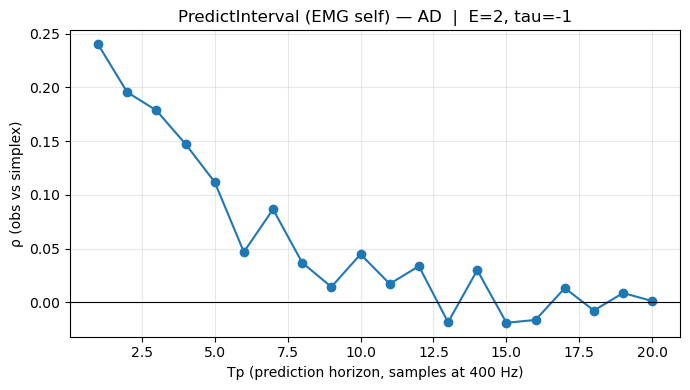

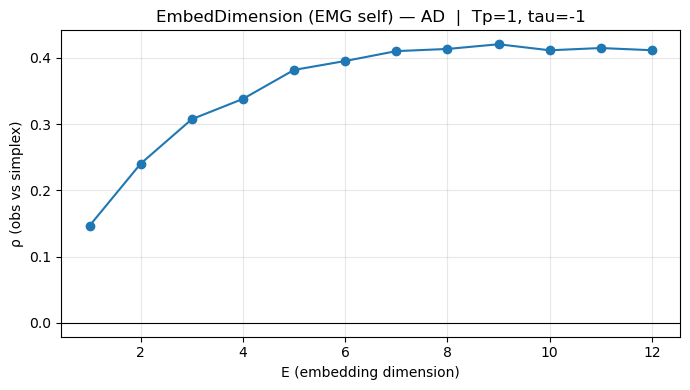

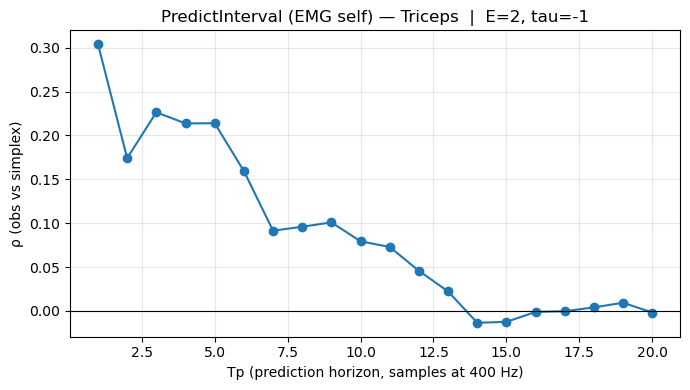

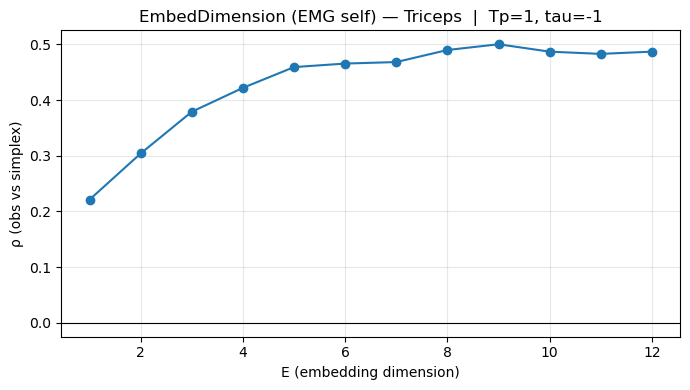

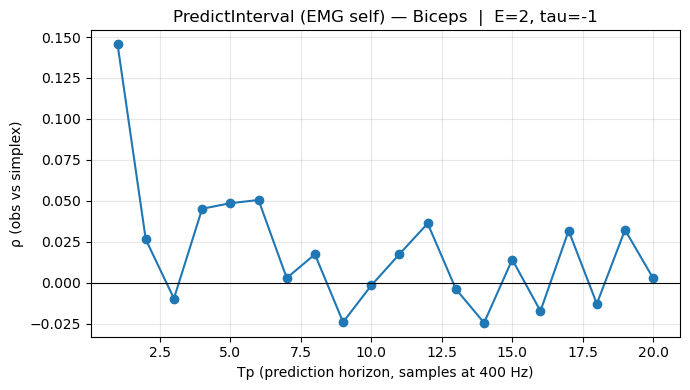

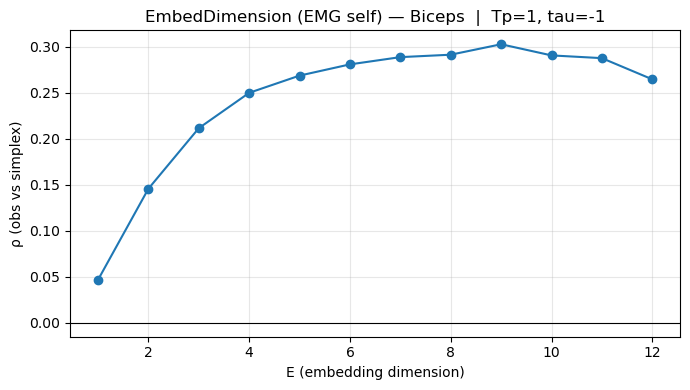

In [ ]:
# === EMG self-prediction diagnostics: PredictInterval & EmbedDimension ============
# Assumes you already have: big_df, lib, pred, emg_cols (e.g., ['AD','Triceps','Biceps'])
# If not, define them just like in your earlier EMG → ref_qpos code before running this cell.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import Simplex

# Safe Pearson ρ
def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs:
        return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12:
        return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

# PredictInterval-like scan: fix E, vary Tp
def predict_interval_scan(df, col, lib, pred, E=2, tau=-1, Tp_vals=range(1, 21)):
    rows = []
    for Tp in Tp_vals:
        pred_df = Simplex(
            dataFrame=df, lib=lib, pred=pred,
            columns=col, target=col,   # self-prediction (like TentMap)
            E=E, tau=tau, Tp=Tp,
            ignoreNan=True, showPlot=False
        )
        obs = pred_df["Observations"].to_numpy()
        hat = pred_df["Predictions"].to_numpy()
        rho = _safe_corr(obs, hat, min_pairs=10)
        rows.append({"Tp": Tp, "rho": rho, "n_pred": len(pred_df)})
    return pd.DataFrame(rows)

# EmbedDimension-like scan: fix Tp, vary E
def embed_dimension_scan(df, col, lib, pred, E_vals=range(1, 13), tau=-1, Tp=1):
    rows = []
    for E in E_vals:
        pred_df = Simplex(
            dataFrame=df, lib=lib, pred=pred,
            columns=col, target=col,   # self-prediction
            E=E, tau=tau, Tp=Tp,
            ignoreNan=True, showPlot=False
        )
        obs = pred_df["Observations"].to_numpy()
        hat = pred_df["Predictions"].to_numpy()
        rho = _safe_corr(obs, hat, min_pairs=10)
        rows.append({"E": E, "rho": rho, "n_pred": len(pred_df)})
    return pd.DataFrame(rows)

# ---------------- Run scans & plot per EMG channel --------------------------------
out_dir = "emg_edm_diagnostics"
os.makedirs(out_dir, exist_ok=True)

Tp_vals = range(1, 21)     # like PredictInterval over horizons 1..20
E_vals  = range(1, 13)     # try E=1..12

results = {}

for col in emg_cols:   # e.g., ['AD','Triceps','Biceps']
    # --- PredictInterval-style (fix E=2, vary Tp) ---
    df_tp = predict_interval_scan(big_df, col, lib, pred, E=2, tau=-1, Tp_vals=Tp_vals)
    df_tp.to_csv(os.path.join(out_dir, f"predict_interval_{col}.csv"), index=False)

    plt.figure(figsize=(7, 4))
    plt.plot(df_tp["Tp"], df_tp["rho"], marker="o")
    plt.axhline(0, color="k", linewidth=0.8)
    plt.title(f"PredictInterval (EMG self) — {col}  |  E=2, tau=-1")
    plt.xlabel("Tp (prediction horizon, samples at 400 Hz)")
    plt.ylabel("ρ (obs vs simplex)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"predict_interval_{col}.png"), dpi=150)
    plt.show()

    # --- EmbedDimension-style (fix Tp=1, vary E) ---
    df_E = embed_dimension_scan(big_df, col, lib, pred, E_vals=E_vals, tau=-1, Tp=9)
    df_E.to_csv(os.path.join(out_dir, f"embed_dimension_{col}.csv"), index=False)

    plt.figure(figsize=(7, 4))
    plt.plot(df_E["E"], df_E["rho"], marker="o")
    plt.axhline(0, color="k", linewidth=0.8)
    plt.title(f"EmbedDimension (EMG self) — {col}  |  Tp=1, tau=-1")
    plt.xlabel("E (embedding dimension)")
    plt.ylabel("ρ (obs vs simplex)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"embed_dimension_{col}.png"), dpi=150)
    plt.show()

    results[col] = {"predict_interval": df_tp, "embed_dimension": df_E}

# 'results' now holds DataFrames for each channel.


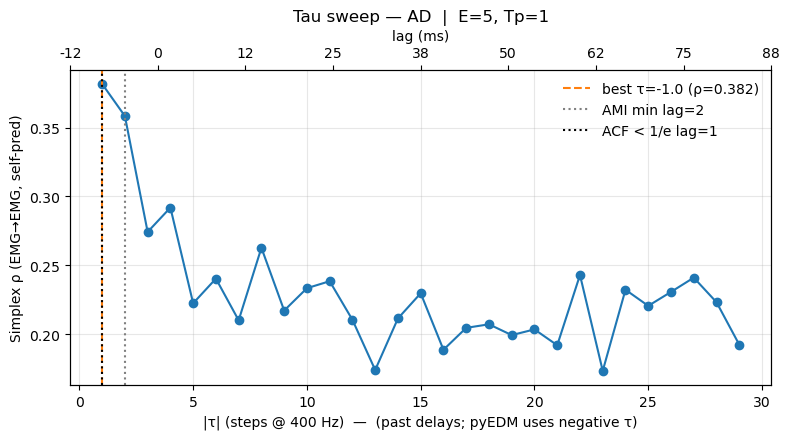

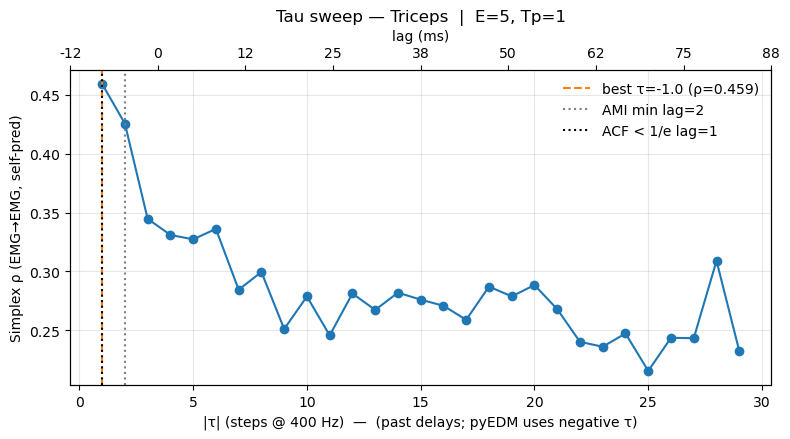

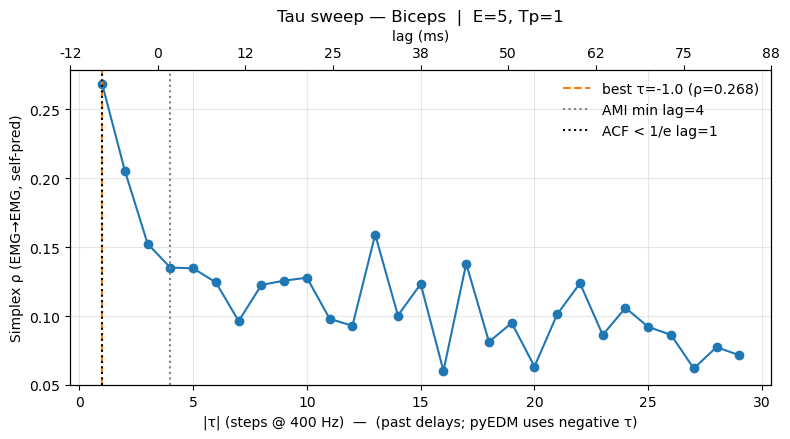


Tau selection summary (per EMG channel):
   channel  best_tau  best_rho  ami_min_lag  acf_1e_lag
0       AD      -1.0  0.381622            2           1
1  Triceps      -1.0  0.459097            2           1
2   Biceps      -1.0  0.268459            4           1


In [84]:
# === Tau search for EMG self-prediction (Simplex) ==================================
# Requires: big_df, lib, pred, emg_cols, target_fs (e.g., 400 Hz)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import Simplex

# ---------- helpers ----------
def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def _concat_non_nan(df, col):
    """Concatenate all non-NaN blocks of a column into one vector (for AMI/ACF)."""
    x = df[col].to_numpy()
    good = np.isfinite(x)
    # Split by NaN gaps
    edges = np.diff(np.concatenate([[0], good.view(np.int8), [0]]))
    starts = np.where(edges == 1)[0]
    ends   = np.where(edges == -1)[0]
    chunks = [x[s:e] for s, e in zip(starts, ends) if (e - s) >= 20]
    if not chunks: return np.array([])
    return np.concatenate(chunks)

def _ami(series, max_lag=80, n_bins=32):
    """Average Mutual Information for lags 1..max_lag using histogram MI (fast & simple)."""
    s = np.asarray(series, float)
    s = s[np.isfinite(s)]
    if s.size < max_lag + 5:
        return np.full(max_lag, np.nan)
    AMI = np.full(max_lag, np.nan)
    # Precompute histogram of s for marginals
    s_min, s_max = np.nanmin(s), np.nanmax(s)
    if not np.isfinite(s_min) or not np.isfinite(s_max) or s_min == s_max:
        return AMI
    for lag in range(1, max_lag + 1):
        x = s[:-lag]
        y = s[lag:]
        # joint histogram
        H, xedges, yedges = np.histogram2d(x, y, bins=n_bins, range=[[s_min, s_max], [s_min, s_max]])
        Pxy = H / np.maximum(H.sum(), 1.0)
        Px  = Pxy.sum(axis=1, keepdims=True)
        Py  = Pxy.sum(axis=0, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            frac = Pxy / (Px * Py + 1e-15)
            logf = np.where(Pxy > 0, np.log(frac + 1e-15), 0.0)
        AMI[lag - 1] = np.nansum(Pxy * logf)
    return AMI

def _acf(series, max_lag=80):
    """Autocorrelation (biased) for lags 0..max_lag, returns array length max_lag+1."""
    s = np.asarray(series, float)
    s = s[np.isfinite(s)]
    if s.size < max_lag + 5:
        return np.full(max_lag + 1, np.nan)
    s = (s - s.mean()) / (s.std(ddof=0) + 1e-12)
    ac = np.correlate(s, s, mode='full')
    ac = ac[ac.size // 2:]  # keep non-negative lags
    ac = ac[:max_lag + 1]
    return ac / (len(s))

def _first_local_min(arr):
    """Index (1-based lag) of first local minimum in arr (simple scan)."""
    a = np.asarray(arr, float)
    for i in range(1, len(a) - 1):
        if np.isfinite(a[i]) and a[i] < a[i - 1] and a[i] <= a[i + 1]:
            return i + 1  # convert to 1-based lag
    return None

def _first_below(arr, thresh):
    """Index (lag) of first element < thresh (1-based), ignoring lag 0."""
    a = np.asarray(arr, float)
    for i in range(1, len(a)):
        if np.isfinite(a[i]) and a[i] < thresh:
            return i  # 1-based for lag>0
    return None

# ---------- tau sweep (forecast-skill driven) ----------
def tau_sweep_simplex(df, col, lib, pred, E=5, Tp=1, tau_max_steps=60, target_fs=400):
    """
    Sweep negative tau (past delays) from -1..-K, constrained so (E-1)*|tau| < ~0.8*Tclip.
    Returns DataFrame with tau (negative), lag_ms, rho, n_pred.
    """
    # With 200-sample clips, keep a margin so embeddings don't collapse:
    Tclip = 200
    max_tau_by_length = max(1, int(0.8 * Tclip) // max(E - 1, 1))
    K = min(tau_max_steps, max_tau_by_length)

    rows = []
    for k in range(1, K + 1):
        tau = -k  # past
        try:
            pred_df = Simplex(
                dataFrame=df, lib=lib, pred=pred,
                columns=col, target=col,
                E=E, tau=tau, Tp=Tp,
                ignoreNan=True, showPlot=False
            )
            obs = pred_df["Observations"].to_numpy()
            hat = pred_df["Predictions"].to_numpy()
            rho = _safe_corr(obs, hat, min_pairs=10)
            rows.append({
                "tau": tau,
                "lag_ms": 1000.0 * (abs(tau) / float(target_fs)),
                "rho": rho,
                "n_pred": len(pred_df)
            })
        except Exception as e:
            rows.append({"tau": tau, "lag_ms": 1000.0 * (k / float(target_fs)), "rho": np.nan, "n_pred": 0})
    return pd.DataFrame(rows)

# ---------- run & plot per EMG ----------
out_dir = "emg_tau_search"
os.makedirs(out_dir, exist_ok=True)

# Set your preferred fixed E and Tp for the sweep
E_fixed = 5
Tp_fixed = 1
tau_max_steps = 60   # ~150 ms at 400 Hz

summaries = []

for col in emg_cols:
    # 1) Forecast-skill tau scan
    df_tau = tau_sweep_simplex(big_df, col, lib, pred,
                               E=E_fixed, Tp=Tp_fixed,
                               tau_max_steps=tau_max_steps,
                               target_fs=target_fs)
    df_tau.to_csv(os.path.join(out_dir, f"tau_scan_{col}.csv"), index=False)

    # Best tau by rho
    best_idx = int(np.nanargmax(df_tau["rho"].to_numpy())) if np.isfinite(df_tau["rho"]).any() else None
    best_tau = df_tau.iloc[best_idx]["tau"] if best_idx is not None else None
    best_rho = df_tau.iloc[best_idx]["rho"] if best_idx is not None else np.nan

    # 2) AMI/ACF heuristics (optional)
    s_all = _concat_non_nan(big_df, col)
    AMI = _ami(s_all, max_lag=tau_max_steps)
    ACF = _acf(s_all, max_lag=tau_max_steps)
    ami_min = _first_local_min(AMI)
    acf_1e  = _first_below(ACF, np.exp(-1.0))

    # 3) Plot ρ vs τ with heuristic markers
    fig, ax1 = plt.subplots(figsize=(8, 4.5))
    ax1.plot(-df_tau["tau"], df_tau["rho"], marker="o")  # plot by |tau| on x
    ax1.set_xlabel("|τ| (steps @ %d Hz)  —  (past delays; pyEDM uses negative τ)" % target_fs)
    ax1.set_ylabel("Simplex ρ (EMG→EMG, self-pred)")
    ax1.set_title(f"Tau sweep — {col}  |  E={E_fixed}, Tp={Tp_fixed}")

    # highlight best tau
    if best_idx is not None:
        ax1.axvline(-best_tau, color="C1", linestyle="--", label=f"best τ={best_tau} (ρ={best_rho:.3f})")

    # AMI & ACF suggestions
    if ami_min is not None:
        ax1.axvline(ami_min, color="grey", linestyle=":", label=f"AMI min lag={ami_min}")
    if acf_1e is not None:
        ax1.axvline(acf_1e, color="k", linestyle=":", label=f"ACF < 1/e lag={acf_1e}")

    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ticks = ax1.get_xticks()
    ms = (ticks / float(target_fs)) * 1000.0
    ax2.set_xticks(ticks)
    ax2.set_xticklabels([f"{m:.0f}" for m in ms])
    ax2.set_xlabel("lag (ms)")

    ax1.grid(alpha=0.3)
    ax1.legend(loc="best", frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"tau_scan_{col}.png"), dpi=150)
    plt.show()

    summaries.append({
        "channel": col,
        "best_tau": best_tau,
        "best_rho": best_rho,
        "ami_min_lag": ami_min,
        "acf_1e_lag": acf_1e
    })

# Print summary table
summary_df = pd.DataFrame(summaries)
print("\nTau selection summary (per EMG channel):")
print(summary_df)
summary_df.to_csv(os.path.join(out_dir, "tau_selection_summary.csv"), index=False)


In [45]:
# === FIX: Embedded Simplex with proper missing-column check ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    """Create manual time-delay embedding columns: [t0, t-1*lag, ..., t-(E-1)*lag]."""
    if prefix is None:
        prefix = base_col
    new_cols = []
    for k in range(E):
        name = f"{prefix}_t{-k}"
        df[name] = df[base_col].shift(k)  # k rows back = t-k
        new_cols.append(name)
    return new_cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def simplex_heatmap_embedded(
    df: pd.DataFrame,
    source_to_cols: dict[str, list[str]],   # source name -> its embedded col names
    targets: list[str],
    lib: str, pred: str,
    title: str,
    out_csv: str, out_png: str
) -> pd.DataFrame:
    # --- correct missing-column detection ---
    flat_src_cols = {c for cols in source_to_cols.values() for c in cols}
    need = flat_src_cols | set(targets)
    missing = sorted(need - set(df.columns))
    if missing:
        raise ValueError(f"Missing columns in big_df: {missing}")

    src_names = list(source_to_cols.keys())
    mat = np.full((len(src_names), len(targets)), np.nan, dtype=float)

    for si, s_name in enumerate(tqdm(src_names, desc=title)):
        s_cols = source_to_cols[s_name]         # these ARE the embedding
        E_dim  = len(s_cols)                    # E = number of columns with embedded=True
        for ti, t_col in enumerate(targets):
            pred_df = Simplex(
                dataFrame=df,
                lib=lib, pred=pred,
                columns=" ".join(s_cols),
                target=t_col,
                E=E_dim, tau=0, Tp=1,
                embedded=True,                # <-- use manual embedding
                ignoreNan=True, showPlot=True
            )
            obs = pred_df["Observations"].to_numpy()
            hat = pred_df["Predictions"].to_numpy()
            mat[si, ti] = _safe_corr(obs, hat, min_pairs=10)

    M = pd.DataFrame(mat, index=src_names, columns=targets)
    M.to_csv(out_csv, float_format="%.6f")

    # heatmap
    fig, ax = plt.subplots(figsize=(1.2*len(targets)+2, 1.2*len(src_names)+2))
    im = ax.imshow(M.values, aspect="auto")
    ax.set_xticks(range(len(targets))); ax.set_xticklabels(targets, rotation=45, ha="right")
    ax.set_yticks(range(len(src_names))); ax.set_yticklabels(src_names)
    ax.set_title(title + "  (embedded=True)")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
    for i in range(len(src_names)):
        for j in range(len(targets)):
            v = M.values[i, j]
            ax.text(j, i, "nan" if np.isnan(v) else f"{v:.2f}",
                    ha="center", va="center", fontsize=8, color="white")
    plt.tight_layout(); plt.savefig(out_png, dpi=150); plt.show()
    return M

# ---- rebuild the manual embeddings (run even if you did earlier) -----------------
lag_step = 1

# joints: 2-D embedding per joint
joint_embed_cols = {}
for j in qpos_names:  # assumes these are in big_df
    joint_embed_cols[j] = make_lagged_columns(
        big_df, base_col=j, E=2, lag_step=lag_step, prefix=f"{j}_emb2"
    )

# EMG: 9-D embedding per EMG
emg_cols = list(EMG_FILES.keys())
emg_embed_cols = {}
for e in emg_cols:    # assumes these are in big_df
    emg_embed_cols[e] = make_lagged_columns(
        big_df, base_col=e, E=7, lag_step=lag_step, prefix=f"{e}_emb9"
    )

# ---- run the two directions with embedded=True -----------------------------------
# 1) joints → EMG
M_j2e_emb = simplex_heatmap_embedded(
    df=big_df,
    source_to_cols=joint_embed_cols,
    targets=emg_cols,
    lib=lib, pred=pred,
    title="Simplex ρ (ref_qpos joints → EMG)",
    out_csv="simplex_refqpos_to_emg_embedded.csv",
    out_png="simplex_refqpos_to_emg_embedded.png"
)
print("joints → EMG (embedded=True)\n", M_j2e_emb.round(3), "\n")

# 2) EMG → joints
M_e2j_emb = simplex_heatmap_embedded(
    df=big_df,
    source_to_cols=emg_embed_cols,
    targets=qpos_names,
    lib=lib, pred=pred,
    title="Simplex ρ (EMG → ref_qpos joints)",
    out_csv="simplex_emg_to_refqpos_embedded.csv",
    out_png="simplex_emg_to_refqpos_embedded.png"
)
print("EMG → joints (embedded=True)\n", M_e2j_emb.round(3))


KeyError: 'sh_elv'

/tmp/ipykernel_1904807/1982851698.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)


Simplex lib:  1 18000
Simplex pred: 18001 18100 (N_total=18100)


Simplex (joints+actions → EMG):   0%|          | 0/3 [00:00<?, ?it/s]

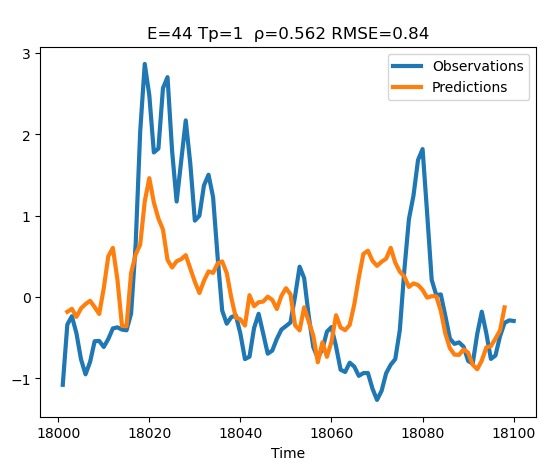

Simplex (joints+actions → EMG):  33%|███▎      | 1/3 [00:00<00:00,  7.76it/s]

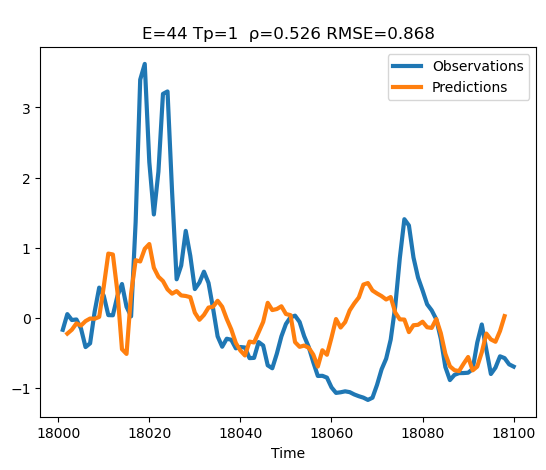

Simplex (joints+actions → EMG):  67%|██████▋   | 2/3 [00:00<00:00,  7.66it/s]

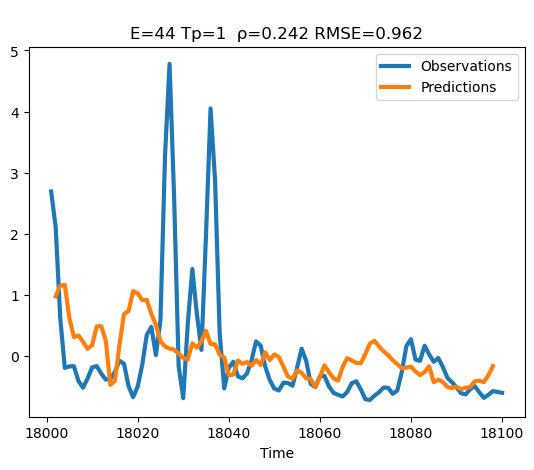

Simplex (joints+actions → EMG): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]



ρ (train 1–8000, test 8001–13000):
            rho
AD       0.562
Triceps  0.526
Biceps   0.242


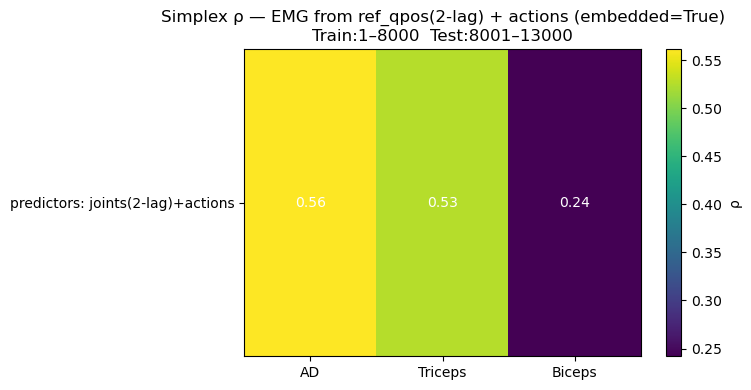


Saved: simplex_emg_from_joints_actions_fixedsplits/rho_joints_plus_actions_to_emg_fixedsplits.csv and plots in simplex_emg_from_joints_actions_fixedsplits/


In [15]:
# === Simplex: predict EMG from (ref_qpos joints + sim actions) ====================
# Train window: 1..8000 ; Test window: 8001..13000 (1-based, inclusive)
# Uses manual embedding + embedded=True (joints: t0,t-1; actions: t0 by default)
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm.h5"  # contains 'ref_qpos' and 'actions'
qpos_names = ["sh_elv", "sh_ext", "sh_rot", "elbow"]      # must match ref_qpos order
action_names = [f"act{i}" for i in range(9)]

# Embedding setup for predictors
JOINT_LAGS  = 2     # joints: [t0, t-1]
ACTION_LAGS = 4     # actions: [t0] (bump to 2+ if you want action history)
LAG_STEP    = -1

# Simplex params
Tp = 1               # 1-step ahead
OUT_DIR = "simplex_emg_from_joints_actions_fixedsplits"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    """Create manual lags [t0, t-1*lag_step, ... t-(E-1)*lag_step] as separate columns."""
    if prefix is None:
        prefix = base_col
    cols = []
    for k in range(E):
        name = f"{prefix}_t{-k}"
        df[name] = df[base_col].shift(k * lag_step)
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L:
        return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_nan_padded_full(emg_stack: dict[str, np.ndarray],
                           qpos_stack: np.ndarray,
                           act_stack: np.ndarray,
                           pad=100,
                           standardize=True):
    """
    Build a long NaN-padded DF with columns:
      time, [EMG names], [qpos_names], [act0..act8]
    Stacks have shapes:
      emg_stack[name] -> (N, T)
      qpos_stack      -> (N, T, 4)
      act_stack       -> (N, T, 9)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]
    A = act_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J):   pad_df[qpos_names[j]] = np.nan
            for a in range(A):   pad_df[action_names[a]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        # EMG
        for nm in emg_names:
            x = emg_stack[nm][c]
            data[nm] = zscore(x) if standardize else x
        # qpos
        for j in range(J):
            k = qpos_stack[c, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k
        # actions
        for a in range(A):
            v = act_stack[c, :, a]
            data[action_names[a]] = zscore(v) if standardize else v

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

# ---------------- Reuse your processed EMG & ref_qpos stacks -----------------------
# Assumes you already have:
#   - emg_stack  (dict name -> (N,200))  from your EMG-processing cell
#   - ref_sel    (N,200,4)                from your ref_qpos loading cell
#   - common_trials (list of trial indices)
if 'emg_stack' not in globals() or 'ref_sel' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel, common_trials).")

# ---------------- Load actions from H5 and align to the same trials ---------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (N_sim, T, 9) typically

# Ensure T=200 (same as EMG/ref_qpos)
target_samples = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_samples:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_samples)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to the EMG trials used earlier (common_trials ordering)
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]  # (N_common, 200, 9)
else:
    K = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:K]
    # also trim emg_stack and ref_sel to K if needed
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:K]
    ref_sel = ref_sel[:K]

# ---------------- Build long DF with EMG + qpos + actions -------------------------
PAD = 300
big_df_all, clip_ranges = concat_nan_padded_full(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    act_stack=act_sel,
    pad=PAD,
    standardize=True
)

# ---------------- Fixed global lib/pred windows -----------------------------------
N_total = len(big_df_all)
lib_end   = min(18000, N_total)            # 1..8000
pred_start= min(18001, N_total)            # 8001..
pred_end  = min(22000, N_total)           # ..13000
lib  = f"1 {lib_end}"
pred = f"{pred_start} {pred_end}"
print(f"Simplex lib:  {lib}")
print(f"Simplex pred: {pred} (N_total={N_total})")

# ---------------- Manual embedding columns (embedded=True) ------------------------
# joints: 2D (t0, t-1), actions: ACTION_LAGS (default 1 → t0 only)
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(big_df_all, base_col=j, E=JOINT_LAGS,
                                          lag_step=LAG_STEP, prefix=f"{j}_emb{JOINT_LAGS}")

action_emb_cols = []
for a in action_names:
    action_emb_cols += make_lagged_columns(big_df_all, base_col=a, E=ACTION_LAGS,
                                           lag_step=LAG_STEP, prefix=f"{a}_emb{ACTION_LAGS}")

predictor_cols = joint_emb_cols + action_emb_cols
emg_targets = list(emg_stack.keys())   # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df_all.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# ---------------- Run Simplex once per EMG target ---------------------------------
rhos = {}
pred_store = {}  # name -> DataFrame of obs/pred for plotting

E_dim = len(predictor_cols)  # embedded=True → E = number of predictor columns
for t in tqdm(emg_targets, desc="Simplex (joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df_all,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=E_dim, tau=-1, Tp=Tp,
        embedded=True,               # columns ARE the embedding; no time-delay
        ignoreNan=True, showPlot=True
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap --------------------------------------------
rho_df = pd.Series(rhos, name="rho").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_joints_plus_actions_to_emg_fixedsplits.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho", ascending=False)
print("\nρ (train 1–8000, test 8001–13000):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho"].to_numpy()[None, :]  # 1 × n_targets
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels(["predictors: joints(2-lag)+actions"])
ax.set_title("Simplex ρ — EMG from ref_qpos(2-lag) + actions (embedded=True)\nTrain:1–8000  Test:8001–13000")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
for j, v in enumerate(rho_df["rho"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_fixedsplits.png"), dpi=150)
plt.show()

# ---------------- Plot obs vs pred traces (first 1000 test rows) ------------------
FIRST_N = 600
for t in emg_targets:
    dfp = pred_store[t]
    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"] if "Time" in dfp.columns else pd.Series(np.arange(len(dfp)))
    t_axis = t_axis.iloc[:K].to_numpy()
    obs = dfp["Observations"].to_numpy()[:K]
    hat = dfp["Predictions"].to_numpy()[:K]

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(t_axis, obs, label="Observation (EMG)", linewidth=2)
    ax.plot(t_axis, hat, label="Prediction (Simplex)", linewidth=2)
    ax.set_title(f"(joints+actions) → {t} | ρ={rhos[t]:.3f} | first {K} test rows (global 8001+)")
    ax.set_xlabel("Global time index (pred rows)"); ax.set_ylabel("z-score")
    ax.grid(alpha=0.3); ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_fixedsplits.png"), dpi=150)
    plt.close(fig)

print(f"\nSaved: {rho_csv} and plots in {OUT_DIR}/")


In [4]:
# === Simplex: predict EMG from ref_qpos joints ONLY (no actions) ==================
# Train window: 1..8000 ; Test window: 8001..13000 (1-based, inclusive)
# Manual joint embedding: (t0, t-1), embedded=True
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
qpos_names = ["sh_elv", "sh_ext", "sh_rot", "elbow"]  # must match ref_qpos order
JOINT_LAGS  = 5      # joints: [t0, t-1]
LAG_STEP    = 3
Tp = 1
OUT_DIR = "simplex_emg_from_joints_only_fixedsplits"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    cols = []
    prefix = prefix or base_col
    for k in range(E):
        name = f"{prefix}_t{-k}"
        df[name] = df[base_col].shift(k * lag_step)
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_nan_padded_emg_qpos(emg_stack: dict[str, np.ndarray],
                               qpos_stack: np.ndarray,
                               pad=100,
                               standardize=True):
    """
    Build a long NaN-padded DF with columns:
      time, [EMG names], [qpos_names]
    Shapes:
      emg_stack[name] -> (N, T)
      qpos_stack      -> (N, T, 4)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0
    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J):   pad_df[qpos_names[j]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        # EMG
        for nm in emg_names:
            x = emg_stack[nm][c]
            data[nm] = zscore(x) if standardize else x
        # qpos
        for j in range(J):
            k = qpos_stack[c, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

# ---------------- Reuse your processed EMG & ref_qpos stacks -----------------------
# Must already exist from your earlier cell:
#   emg_stack  (dict name -> (N,200))
#   ref_sel    (N,200,4)
if 'emg_stack' not in globals() or 'ref_sel' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel).")

# ---------------- Build long DF with EMG + qpos (NO actions) ----------------------
PAD = 300
big_df, clip_ranges = concat_nan_padded_emg_qpos(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    pad=PAD,
    standardize=True
)

# ---------------- Fixed global lib/pred windows -----------------------------------
N_total   = len(big_df)
lib_end   = min(17000,  N_total)   # 1..8000
pred_start= min(17001,  N_total)   # 8001..
pred_end  = min(22700, N_total)   # ..13000
lib  = f"1 {lib_end}"
pred = f"{pred_start} {pred_end}"
print(f"Simplex lib:  {lib}")
print(f"Simplex pred: {pred} (N_total={N_total})")

# ---------------- Manual embedding columns (embedded=True) ------------------------
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(big_df, base_col=j, E=JOINT_LAGS,
                                          lag_step=LAG_STEP, prefix=f"{j}_emb{JOINT_LAGS}")

predictor_cols = joint_emb_cols
emg_targets = list(emg_stack.keys())   # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# ---------------- Run Simplex once per EMG target ---------------------------------
rhos = {}
pred_store = {}

E_dim = len(predictor_cols)  # embedded=True → E = number of predictor columns
for t in tqdm(emg_targets, desc="Simplex (joints → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=E_dim, tau=LAG_STEP, Tp=Tp,
        embedded=True,           # treat lag columns as the embedding coordinates
        ignoreNan=True, showPlot=True
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap --------------------------------------------
rho_df = pd.Series(rhos, name="rho").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_joints_only_to_emg_fixedsplits.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho", ascending=False)
print("\nρ (train 1–8000, test 8001–13000):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho"].to_numpy()[None, :]  # 1 × n_targets
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels(["predictors: joints(2-lag)"])
ax.set_title("Simplex ρ — EMG from ref_qpos(2-lag) (embedded=True)\nTrain:1–8000  Test:8001–13000")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
for j, v in enumerate(rho_df["rho"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_joints_only_fixedsplits.png"), dpi=150)
plt.show()

# ---------------- Plot obs vs pred traces (first 1000 test rows) ------------------
FIRST_N = 1000
for t in emg_targets:
    dfp = pred_store[t]
    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"] if "Time" in dfp.columns else pd.Series(np.arange(len(dfp)))
    t_axis = t_axis.iloc[:K].to_numpy()
    obs = dfp["Observations"].to_numpy()[:K]
    hat = dfp["Predictions"].to_numpy()[:K]

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(t_axis, obs, label="Observation (EMG)", linewidth=2)
    ax.plot(t_axis, hat, label="Prediction (Simplex)", linewidth=2)
    ax.set_title(f"(joints only) → {t} | ρ={rhos[t]:.3f} | first {K} test rows (global 8001+)")
    ax.set_xlabel("Global time index (pred rows)"); ax.set_ylabel("z-score")
    ax.grid(alpha=0.3); ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_joints_only_fixedsplits.png"), dpi=150)
    plt.close(fig)

print(f"\nSaved: {rho_csv} and plots in {OUT_DIR}/")


RuntimeError: Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel).

/tmp/ipykernel_18055/1782112274.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df[base_col].shift(shift_amt)  # positive shift => past values aligned at current t
/tmp/ipykernel_18055/1782112274.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df[base_col].shift(shift_amt)  # positive shift => past values aligned at current t
/tmp/ipykernel_18055/1782112274.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Simplex lib:  1 17000
Simplex pred: 17001 22700 (N_total=22700)
Embedding summary → joints: 2 lags @ step 3; actions: 9 lags @ step 3; total predictor dims: 89


Simplex (joints+actions → EMG):   0%|          | 0/2 [00:00<?, ?it/s]

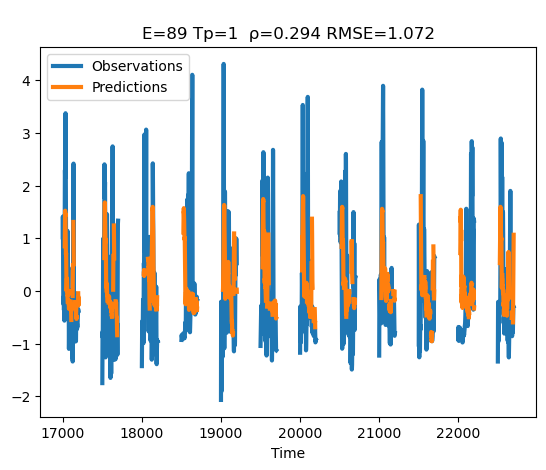

Simplex (joints+actions → EMG):  50%|█████     | 1/2 [00:00<00:00,  3.12it/s]

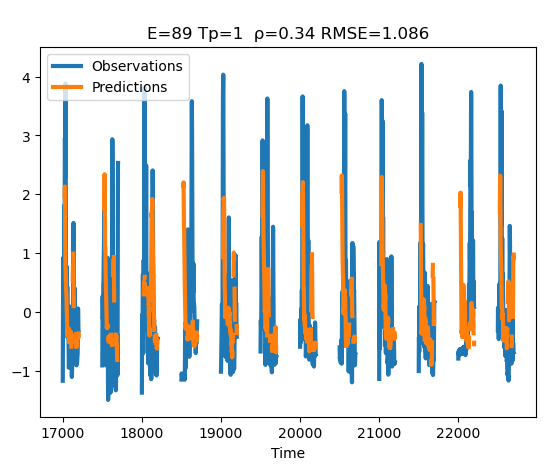

Simplex (joints+actions → EMG): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]



ρ (train 1–8000, test 8001–13000):
            rho
Triceps  0.340
AD       0.294


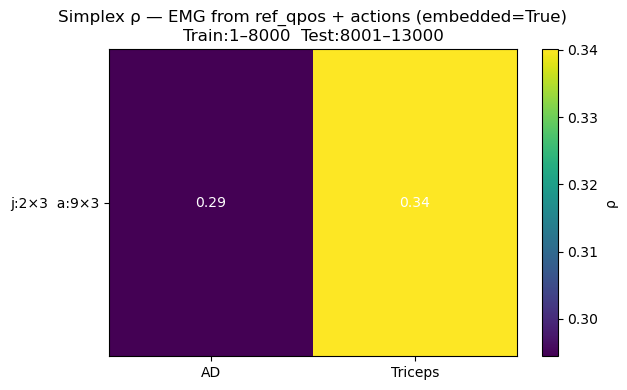


Saved: simplex_emg_from_joints_actions_fixedsplits/rho_joints_plus_actions_to_emg_fixedsplits.csv and plots in simplex_emg_from_joints_actions_fixedsplits/


In [42]:
# === Simplex: predict EMG from (ref_qpos joints + sim actions) ====================
# Train: 1..8000 ; Test: 8001..13000 (1-based, inclusive)
# Manual embedding with embedded=True
#   • Joints: JOINT_LAGS using JOINT_LAG_STEP (e.g., t0, t-1)
#   • Actions: ACTION_LAGS using ACTION_LAG_STEP (e.g., t0, t-10, t-20, ...)
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm_new.h5"  # contains 'ref_qpos' and 'actions'
qpos_names   = ["sh_elv", "sh_ext", "sh_rot", "elbow"]         # must match ref_qpos order
action_names = [f"act{i}" for i in range(9)]

# Embedding setup for predictors
JOINT_LAGS       = 2     # number of joint lags to include
JOINT_LAG_STEP   = 3     # step (in samples) between joint lags: 1 → t0, t-1
ACTION_LAGS      = 9     # number of action lags to include
ACTION_LAG_STEP  = 3    # step (in samples) between action lags: 10 → t0, t-10, t-20, ...
# NOTE: at 400 Hz, 10 samples ≈ 25 ms

# Simplex params
Tp = 1               # 1-step ahead
OUT_DIR = "simplex_emg_from_joints_actions_fixedsplits"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    """Create manual lags [t0, t-lag_step, t-2*lag_step, ...] as separate columns."""
    if prefix is None:
        prefix = base_col
    cols = []
    for k in range(E):
        shift_amt = k * lag_step
        name = f"{prefix}_t{-shift_amt}"
        df[name] = df[base_col].shift(shift_amt)  # positive shift => past values aligned at current t
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L: return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_nan_padded_full(emg_stack: dict[str, np.ndarray],
                           qpos_stack: np.ndarray,
                           act_stack: np.ndarray,
                           pad=100,
                           standardize=True):
    """
    Build a long NaN-padded DF with columns:
      time, [EMG names], [qpos_names], [act0..act8]
    Stacks have shapes:
      emg_stack[name] -> (N, T)
      qpos_stack      -> (N, T, 4)
      act_stack       -> (N, T, 9)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]
    A = act_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J):   pad_df[qpos_names[j]] = np.nan
            for a in range(A):   pad_df[action_names[a]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        # EMG
        for nm in emg_names:
            x = emg_stack[nm][c]
            data[nm] = zscore(x) if standardize else x
        # qpos
        for j in range(J):
            k = qpos_stack[c, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k
        # actions
        for a in range(A):
            v = act_stack[c, :, a]
            data[action_names[a]] = zscore(v) if standardize else v

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

# ---------------- Reuse your processed EMG & ref_qpos stacks -----------------------
# Requires: emg_stack (dict name->(N,200)), ref_sel (N,200,4), common_trials (list)
if 'emg_stack' not in globals() or 'ref_sel' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel, common_trials).")

# ---------------- Load actions from H5 and align to the same trials ---------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (N_sim, T, 9)

# Ensure T=200 (same as EMG/ref_qpos)
target_samples = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_samples:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_samples)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to the EMG trials used earlier (common_trials ordering)
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]  # (N_common, 200, 9)
else:
    K = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:K]
    # also trim emg_stack and ref_sel to K if needed
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:K]
    ref_sel = ref_sel[:K]

# ---------------- Build long DF with EMG + qpos + actions -------------------------
PAD = 300
big_df_all, clip_ranges = concat_nan_padded_full(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    act_stack=act_sel,
    pad=PAD,
    standardize=True   # <- keep as-is if you're z-scoring; switch off if you pre-normalize elsewhere
)

# ---------------- Fixed global lib/pred windows -----------------------------------
N_total = len(big_df_all)
lib_end    = min(17000, N_total)            # 1..8000
pred_start = min(17001, N_total)            # 8001..
pred_end   = min(22700, N_total)           # ..13000
lib  = f"1 {lib_end}"
pred = f"{pred_start} {pred_end}"
print(f"Simplex lib:  {lib}")
print(f"Simplex pred: {pred} (N_total={N_total})")

# ---------------- Manual embedding columns (embedded=True) ------------------------
# joints: use JOINT_LAG_STEP; actions: use ACTION_LAG_STEP
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(
        big_df_all, base_col=j, E=JOINT_LAGS, lag_step=JOINT_LAG_STEP,
        prefix=f"{j}_emb{JOINT_LAGS}x{JOINT_LAG_STEP}"
    )

action_emb_cols = []
for a in action_names:
    action_emb_cols += make_lagged_columns(
        big_df_all, base_col=a, E=ACTION_LAGS, lag_step=ACTION_LAG_STEP,
        prefix=f"{a}_emb{ACTION_LAGS}x{ACTION_LAG_STEP}"
    )

predictor_cols = joint_emb_cols + action_emb_cols
emg_targets = list(emg_stack.keys())   # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df_all.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print(f"Embedding summary → joints: {JOINT_LAGS} lags @ step {JOINT_LAG_STEP}; "
      f"actions: {ACTION_LAGS} lags @ step {ACTION_LAG_STEP}; "
      f"total predictor dims: {len(predictor_cols)}")

# ---------------- Run Simplex once per EMG target ---------------------------------
rhos = {}
pred_store = {}  # name -> DataFrame of obs/pred for plotting

# With embedded=True, the effective E is len(predictor_cols); tau is ignored
for t in tqdm(emg_targets, desc="Simplex (joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df_all,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=len(predictor_cols), tau=0, Tp=Tp,   # tau irrelevant when embedded=True
        embedded=True,
        ignoreNan=True, showPlot=True
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap --------------------------------------------
rho_df = pd.Series(rhos, name="rho").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_joints_plus_actions_to_emg_fixedsplits.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho", ascending=False)
print("\nρ (train 1–8000, test 8001–13000):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho"].to_numpy()[None, :]  # 1 × n_targets
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"j:{JOINT_LAGS}×{JOINT_LAG_STEP}  a:{ACTION_LAGS}×{ACTION_LAG_STEP}"])
ax.set_title("Simplex ρ — EMG from ref_qpos + actions (embedded=True)\nTrain:1–8000  Test:8001–13000")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
for j, v in enumerate(rho_df["rho"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_fixedsplits.png"), dpi=150)
plt.show()

# ---------------- Plot obs vs pred traces (first 1000 test rows) ------------------
FIRST_N = 1000
for t in emg_targets:
    dfp = pred_store[t]
    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"] if "Time" in dfp.columns else pd.Series(np.arange(len(dfp)))
    t_axis = t_axis.iloc[:K].to_numpy()
    obs = dfp["Observations"].to_numpy()[:K]
    hat = dfp["Predictions"].to_numpy()[:K]

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(t_axis, obs, label="Observation (EMG)", linewidth=2)
    ax.plot(t_axis, hat, label="Prediction (Simplex)", linewidth=2)
    ax.set_title(f"(joints+actions) → {t} | ρ={rhos[t]:.3f} | first {K} test rows (global 8001+)")
    ax.set_xlabel("Global time index (pred rows)"); ax.set_ylabel("z-score")
    ax.grid(alpha=0.3); ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_fixedsplits.png"), dpi=150)
    plt.close(fig)

print(f"\nSaved: {rho_csv} and plots in {OUT_DIR}/")


/tmp/ipykernel_1904807/2657893876.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)


Train reaches: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Test reaches: [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Library ranges: 32 segments
Prediction ranges: 14 segments
Simplex lib:  5 90 205 290 405 490 605 690 805 890 1005 1090 1205 1290 1405 1490 1605 1690 1805 1890 2005 2090 220...
Simplex pred: 6405 6490 6605 6690 6805 6890 7005 7090 7205 7290 7405 7490 7605 7690 7805 7890 8005 8090 8205 8290 ...


Simplex (joints → EMG): 100%|██████████| 3/3 [00:00<00:00, 66.16it/s]



ρ (reach-aware, train fraction=0.7):
            rho
Triceps  0.322
AD       0.247
Biceps   0.213


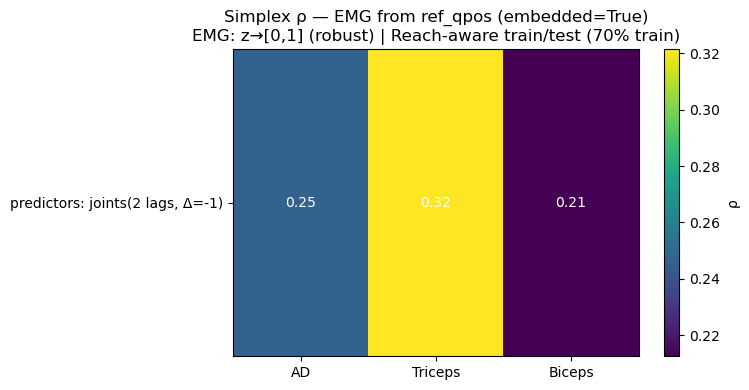


Saved: simplex_emg_from_joints_only_reachaware_unit01emg/rho_joints_only_to_emg_reachaware_unit01emg.csv and plots in simplex_emg_from_joints_only_reachaware_unit01emg/


In [18]:
# === Simplex: predict EMG from ref_qpos joints ONLY (reach-aware lib/pred) ========
# Uses padding structure to create proper train/test splits across reaches
# EMG: z-score -> robust [0,1] using percentiles, clipped to [0,1]
# Joints: z-scores (keeps relative weighting in state-space)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
qpos_names = ["sh_elv", "sh_ext", "sh_rot", "elbow"]  # must match ref_qpos order

# Manual embedding for joints
JOINT_LAGS      = 2     # number of lags to include: [t0, t-Δ, t-2Δ, ...]
JOINT_LAG_STEP  = -1     # Δ in samples (e.g., Δ=3 at 400 Hz ≈ 7.5 ms per lag)
Tp              = 5    # prediction horizon in samples

# Train/test split parameters
TRAIN_REACH_FRACTION = 0.7  # Use 70% of reaches for training
REACH_SPLIT_BUFFER = 5      # Sample buffer within each reach to avoid edge effects

OUT_DIR = "simplex_emg_from_joints_only_reachaware_unit01emg"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    cols = []
    prefix = prefix or base_col
    for k in range(E):
        shift_amt = k * lag_step
        name = f"{prefix}_t{-shift_amt}"
        df[name] = df[base_col].shift(shift_amt)
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def unit01_from_z(z, lo=1, hi=98, eps=1e-12):
    """Map z-scored vector to [0,1] using robust percentiles; clip outside."""
    p_lo = np.nanpercentile(z, lo)
    p_hi = np.nanpercentile(z, hi)
    denom = max(p_hi - p_lo, eps)
    return np.clip((z - p_lo) / denom, 0.0, 1.0)

def concat_nan_padded_emg_qpos(emg_stack: dict[str, np.ndarray],
                               qpos_stack: np.ndarray,
                               pad=100,
                               standardize=True,
                               emg_to01=True,
                               emg_pct=(1, 98),
                               joints_to01=False,
                               joints_pct=(1, 99)):
    """
    Build a long NaN-padded DF with columns: time, [EMG names], [qpos_names]
    - EMG: z-score -> optional robust [0,1] via percentiles (default on)
    - Joints: z-scores (default), optional [0,1] if joints_to01=True
    Shapes:
      emg_stack[name] -> (N, T)
      qpos_stack      -> (N, T, 4)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0
    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J):   pad_df[qpos_names[j]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}

        # EMG columns: z-score -> [0,1] robust
        for nm in emg_names:
            x = emg_stack[nm][c]
            if standardize:
                x = zscore(x)
                if emg_to01:
                    x = unit01_from_z(x, lo=emg_pct[0], hi=emg_pct[1])
            data[nm] = x

        # Joint columns: z-score (optionally to [0,1])
        for j in range(J):
            k = qpos_stack[c, :, j]
            if standardize:
                k = zscore(k)
                if joints_to01:
                    k = unit01_from_z(k, lo=joints_pct[0], hi=joints_pct[1])
            data[qpos_names[j]] = k

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

def create_reach_aware_lib_pred(clip_ranges: dict, 
                                train_fraction: float = 0.7,
                                buffer: int = 5,
                                max_lag: int = 2,
                                Tp: int = 1) -> tuple[str, str]:
    """
    Create library and prediction ranges using reach structure to avoid leakage.
    
    Args:
        clip_ranges: Dict from concat_nan_padded_emg_qpos {clip_idx: (start, end)}
        train_fraction: Fraction of reaches to use for training
        buffer: Sample buffer within each reach to avoid edge effects
        max_lag: Maximum lag from embedding (for edge protection)
        Tp: Prediction horizon (for edge protection)
    
    Returns:
        (lib_str, pred_str): pyEDM range strings
    """
    n_reaches = len(clip_ranges)
    n_train = int(np.floor(train_fraction * n_reaches))
    
    # Use first n_train reaches for library, rest for prediction
    train_reaches = list(range(n_train))
    test_reaches = list(range(n_train, n_reaches))
    
    lib_parts, pred_parts = [], []
    
    # Build library ranges (from training reaches)
    for reach_idx in train_reaches:
        start, end = clip_ranges[reach_idx]  # 1-based inclusive
        # Protect edges: start + max_lag, end - Tp - buffer
        safe_start = start + max_lag + buffer
        safe_end = end - Tp - buffer
        
        if safe_end > safe_start:
            lib_parts.extend([str(safe_start), str(safe_end)])
    
    # Build prediction ranges (from test reaches)
    for reach_idx in test_reaches:
        start, end = clip_ranges[reach_idx]  # 1-based inclusive
        # Protect edges: start + max_lag, end - Tp - buffer
        safe_start = start + max_lag + buffer
        safe_end = end - Tp - buffer
        
        if safe_end > safe_start:
            pred_parts.extend([str(safe_start), str(safe_end)])
    
    lib_str = " ".join(lib_parts)
    pred_str = " ".join(pred_parts)
    
    print(f"Train reaches: {train_reaches}")
    print(f"Test reaches: {test_reaches}")
    print(f"Library ranges: {len(lib_parts)//2} segments")
    print(f"Prediction ranges: {len(pred_parts)//2} segments")
    
    return lib_str, pred_str

# ---------------- Reuse your processed EMG & ref_qpos stacks -----------------------
# Must already exist from your earlier cell:
#   emg_stack  (dict name -> (N,200))  — EMG trial windows
#   ref_sel    (N,200,4)               — ref_qpos aligned to those trials
if 'emg_stack' not in globals() or 'ref_sel' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel).")

# ---------------- Build long DF with EMG + qpos (NO actions) ----------------------
PAD = 100
big_df, clip_ranges = concat_nan_padded_emg_qpos(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    pad=PAD,
    standardize=True,
    emg_to01=True,        # <-- EMG mapped to [0,1] after z-score
    emg_pct=(1, 98),
    joints_to01=False     # <-- keep joints as z-scores (recommended)
)

# ---------------- Create reach-aware lib/pred ranges -------------------------------
max_lag = (JOINT_LAGS - 1) * JOINT_LAG_STEP
lib, pred = create_reach_aware_lib_pred(
    clip_ranges=clip_ranges,
    train_fraction=TRAIN_REACH_FRACTION,
    buffer=REACH_SPLIT_BUFFER,
    max_lag=max_lag,
    Tp=Tp
)

print(f"Simplex lib:  {lib[:100]}{'...' if len(lib) > 100 else ''}")
print(f"Simplex pred: {pred[:100]}{'...' if len(pred) > 100 else ''}")

# ---------------- Manual embedding columns (embedded=True) ------------------------
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(
        big_df, base_col=j, E=JOINT_LAGS, lag_step=JOINT_LAG_STEP,
        prefix=f"{j}_emb{JOINT_LAGS}"
    )

predictor_cols = joint_emb_cols
emg_targets = list(emg_stack.keys())   # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# ---------------- Run Simplex once per EMG target ---------------------------------
rhos = {}
pred_store = {}

E_dim = len(predictor_cols)  # embedded=True → E = number of predictor columns
for t in tqdm(emg_targets, desc="Simplex (joints → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=E_dim, tau=0, Tp=Tp,      # tau ignored when embedded=True
        embedded=True,              # treat lag columns as the embedding coordinates
        ignoreNan=True, showPlot=False  # Set to False to reduce output
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap --------------------------------------------
rho_df = pd.Series(rhos, name="rho").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_joints_only_to_emg_reachaware_unit01emg.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho", ascending=False)
print(f"\nρ (reach-aware, train fraction={TRAIN_REACH_FRACTION}):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho"].to_numpy()[None, :]  # 1 × n_targets
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"predictors: joints({JOINT_LAGS} lags, Δ={JOINT_LAG_STEP})"])
ax.set_title(f"Simplex ρ — EMG from ref_qpos (embedded=True)\nEMG: z→[0,1] (robust) | Reach-aware train/test ({TRAIN_REACH_FRACTION:.0%} train)")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
for j, v in enumerate(rho_df["rho"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_joints_only_reachaware_unit01emg.png"), dpi=150)
plt.show()

# ---------------- Plot obs vs pred traces (first 1000 test rows) ------------------
FIRST_N = 1000
for t in emg_targets:
    dfp = pred_store[t]
    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"] if "Time" in dfp.columns else pd.Series(np.arange(len(dfp)))
    t_axis = t_axis.iloc[:K].to_numpy()
    obs = dfp["Observations"].to_numpy()[:K]
    hat = dfp["Predictions"].to_numpy()[:K]

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(t_axis, obs, label="Observation (EMG, 0–1)", linewidth=2)
    ax.plot(t_axis, hat, label="Prediction (Simplex)", linewidth=2)
    ax.set_title(f"(joints only) → {t} | ρ={rhos[t]:.3f} | first {K} test rows (reach-aware)")
    ax.set_xlabel("Global time index (pred rows)")
    ax.set_ylabel("scaled units")
    ax.grid(alpha=0.3); ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_joints_only_reachaware_unit01emg.png"), dpi=150)
    plt.close(fig)

print(f"\nSaved: {rho_csv} and plots in {OUT_DIR}/")

/tmp/ipykernel_1904807/2625479779.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat(frames, ignore_index=True)


Train reaches: [0, 1, 2, 3, 4]... (+36 total)
Test  reaches: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Embedding margin (samples): 10
lib: 11 90 411 490 811 890 1211 1290 1611 1690 2011 2090 2411 2490 2811 2890 3211 3290 3611 3690 4011 409...
pred: 14411 14490 14811 14890 15211 15290 15611 15690 16011 16090 16411 16490 16811 16890 17211 17290 1761...
Predictor dims (total embedded columns): 71


Simplex (embedded joints+actions → EMG): 100%|██████████| 3/3 [00:00<00:00, 19.54it/s]


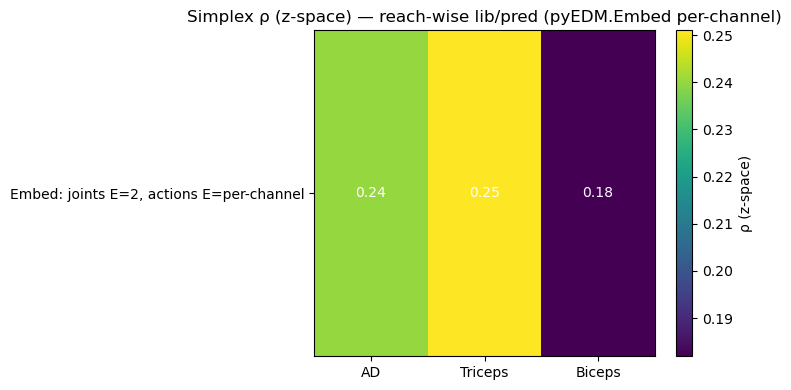

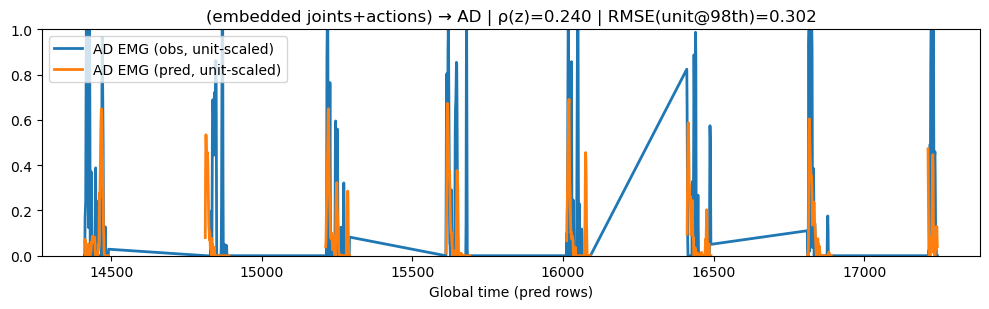

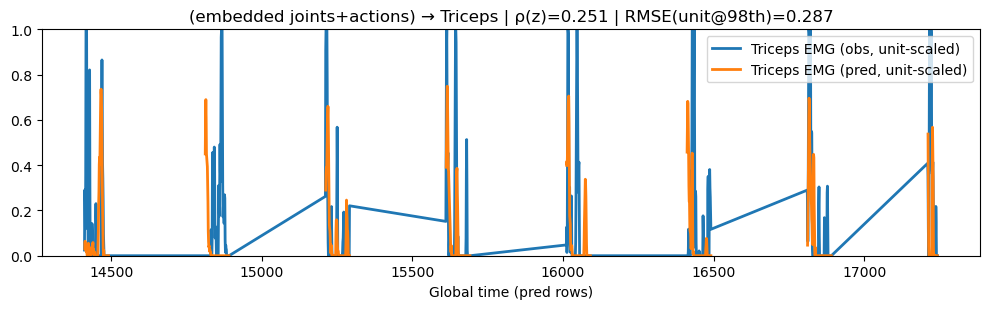

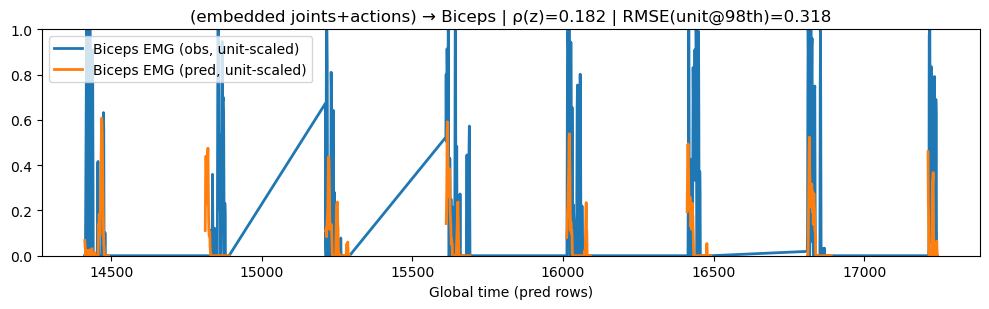

         rho_z  rmse_unit_p98
AD       0.240          0.302
Triceps  0.251          0.287
Biceps   0.182          0.318


In [19]:
# %%time
# === Simplex: EMG from (ref_qpos joints + actions) with pyEDM.Embed (per-channel E) ===
# - Per-reach z-scoring for fit (keeps geometry good for Simplex)
# - Variable embedding per action via pyEDM.Embed; joints E=2
# - Reach-aware lib/pred (padding-invariant)
# - ρ computed in z-space; optional 0–1 unit RMSE for interpretability (post-hoc)
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex, Embed

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm_new.h5"  # contains 'actions'
OUT_DIR = "simplex_embed_per_action_reachwise"
os.makedirs(OUT_DIR, exist_ok=True)

# Channels
qpos_names   = ["sh_elv", "sh_ext", "sh_rot", "elbow"]
action_names = [f"act{i}" for i in range(9)]

# Embedding design (per-channel E); tau<0 = past lags
JOINT_E  = 2
JOINT_TAU = -1

ACTION_E = {
    "act0": 6, "act1": 10, "act2": 5, "act3": 5, "act4": 10,
    "act5": 6, "act6": 8,  "act7": 6,  "act8": 7
}
ACTION_TAU = -1  # 1-sample step between action lags

Tp = 1          # prediction horizon (samples)
PAD = 300       # NaN gap between reaches (PAD-invariant lib/pred used)
TEST_REACHES_LAST = 10  # last R_test reaches for prediction

# Plot/RMSE unit scaling (post-hoc, does not affect fit or ρ)
DO_UNIT_RMSE_PLOTS = True
UNIT_PCT = 98
FIRST_N_PLOT = 600

# ---------------- Helpers ----------------------------------------------------------
def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_with_gaps_multi(emg_stack: dict[str, np.ndarray],
                           qpos_stack: np.ndarray,
                           act_stack: np.ndarray,
                           pad=100,
                           standardize=True):
    """
    Return:
      base_df: columns = Time, [EMG names], [qpos_names], [act0..act8]
      starts:  0-based start indices of each reach (in base_df rows)
      T:       number of timepoints per reach
    """
    emg_names = list(emg_stack.keys())
    R, T = next(iter(emg_stack.values())).shape
    J, A = qpos_stack.shape[-1], act_stack.shape[-1]

    frames, starts = [], []
    row_cursor = 0
    for r in range(R):
        if r > 0:
            pad_df = pd.DataFrame({"Time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names + qpos_names + action_names:
                pad_df[nm] = np.nan
            frames.append(pad_df); row_cursor += pad

        starts.append(row_cursor)  # 0-based row index where this reach block will start
        data = {"Time": np.arange(row_cursor+1, row_cursor+T+1)}

        # EMG (z-score per reach for fit geometry)
        for nm in emg_names:
            x = emg_stack[nm][r]
            data[nm] = zscore(x) if standardize else x

        # qpos
        for j in range(J):
            k = qpos_stack[r, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k

        # actions
        for a in range(A):
            v = act_stack[r, :, a]
            data[action_names[a]] = zscore(v) if standardize else v

        frames.append(pd.DataFrame(data))
        row_cursor += T

    base_df = pd.concat(frames, ignore_index=True)
    return base_df, np.asarray(starts, dtype=int), T

def reachwise_lib_pred_strings(starts, T, train_reaches, test_reaches, max_lag, Tp):
    """
    Make pyEDM range strings as union of [s,e] per reach with embedding margin.
    Uses 1-based inclusive indices.
    """
    emb_margin = int(max_lag + max(Tp, 0))

    def rng_1based(r):
        s = starts[r] + 1
        e = starts[r] + T
        s2 = s + emb_margin
        e2 = e - emb_margin
        if e2 <= s2:
            return None
        return (s2, e2)

    lib_parts, pred_parts = [], []
    for r in train_reaches:
        rge = rng_1based(r)
        if rge: lib_parts.extend([str(rge[0]), str(rge[1])])
    for r in test_reaches:
        rge = rng_1based(r)
        if rge: pred_parts.extend([str(rge[0]), str(rge[1])])

    lib_str  = " ".join(lib_parts)
    pred_str = " ".join(pred_parts)
    if not lib_str or not pred_str:
        raise RuntimeError("Empty lib/pred after margin guard; reduce lags/Tp or adjust splits.")
    return lib_str, pred_str, emb_margin

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L: return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def linear_unit_scale_pair(a, b, pct=98, clip=True):
    """
    Post-hoc linear scaling for plots/RMSE only (does not affect fit or ρ).
    Scales a & b so pct-th percentile of |[a,b]| maps to 1.
    """
    a = np.asarray(a, float); b = np.asarray(b, float)
    v = np.concatenate([a[np.isfinite(a)], b[np.isfinite(b)]])
    p = np.nanpercentile(np.abs(v), pct) if v.size else 1.0
    if not np.isfinite(p) or p <= 0: p = 1.0
    a2, b2 = a / p, b / p
    if clip:
        a2 = np.clip(a2, 0.0, 1.0); b2 = np.clip(b2, 0.0, 1.0)
    return a2, b2, p

# ---------------- Prereqs: emg_stack/ref_sel/common_trials expected ----------------
# emg_stack: dict name -> (R,T)   | ref_sel: (R,T,4)   | common_trials: list of reach idxs to use
if 'emg_stack' not in globals() or 'ref_sel' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing first (emg_stack, ref_sel, common_trials).")

# ---------------- Load & align actions --------------------------------------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (R_sim, T, 9)

target_T = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_T:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_T)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to the EMG trial list order
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]  # (R,T,9)
else:
    Rcap = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:Rcap]
    # also trim emg_stack/ref_sel if needed
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:Rcap]
    ref_sel = ref_sel[:Rcap]

# ---------------- Build base DataFrame (z-scored per reach) -----------------------
base_df, starts, T = concat_with_gaps_multi(
    emg_stack=emg_stack, qpos_stack=ref_sel, act_stack=act_sel,
    pad=PAD, standardize=True
)
R = len(starts)

# ---------------- Reach-wise lib/pred (padding-invariant) -------------------------
# Compute MAX_LAG from the largest (E-1)*|tau| across all embedded predictors
max_joint_lag = (JOINT_E - 1) * abs(JOINT_TAU)
max_action_lag = max((ACTION_E[a] - 1) * abs(ACTION_TAU) for a in ACTION_E)
MAX_LAG = max(max_joint_lag, max_action_lag)

test_reaches  = list(range(R - TEST_REACHES_LAST, R))
train_reaches = [r for r in range(R) if r not in test_reaches]

lib, pred, emb_margin = reachwise_lib_pred_strings(
    starts=starts, T=T, train_reaches=train_reaches, test_reaches=test_reaches,
    max_lag=MAX_LAG, Tp=Tp
)
print(f"Train reaches: {train_reaches[:5]}... (+{len(train_reaches)} total)")
print(f"Test  reaches: {test_reaches}")
print("Embedding margin (samples):", emb_margin)
print("lib:", lib[:100] + ("..." if len(lib) > 100 else ""))
print("pred:", pred[:100] + ("..." if len(pred) > 100 else ""))

# ---------------- Build embedded predictor columns with pyEDM.Embed ----------------
# We'll embed each predictor separately with its own E,tau and then concat all columns.
# Keep 'Time' and target EMG columns from base_df.
targets = list(emg_stack.keys())  # e.g., ['AD','Triceps','Biceps']

# Start with Time + targets in the final DataFrame
final_df = base_df[["Time"] + targets].copy()

# Joints: same E for all joints
joint_emb_cols_all = []
for j in qpos_names:
    # Embed returns only embedded columns; includeTime=False to avoid duplicate Time cols
    df_emb = Embed(dataFrame=base_df, E=JOINT_E, tau=JOINT_TAU, columns=[j], includeTime=False)
    # Make column names unique & informative (prefix with 'J:')
    df_emb.columns = [f"J:{j}|{c}" for c in df_emb.columns]
    final_df = final_df.join(df_emb)
    joint_emb_cols_all += list(df_emb.columns)

# Actions: per-action E per ACTION_E
action_emb_cols_all = []
for a in action_names:
    E_a = ACTION_E.get(a, 1)
    if E_a < 1:
        continue
    df_emb = Embed(dataFrame=base_df, E=E_a, tau=ACTION_TAU, columns=[a], includeTime=False)
    df_emb.columns = [f"A:{a}|{c}" for c in df_emb.columns]
    final_df = final_df.join(df_emb)
    action_emb_cols_all += list(df_emb.columns)

predictor_cols = joint_emb_cols_all + action_emb_cols_all
print(f"Predictor dims (total embedded columns): {len(predictor_cols)}")

# ---------------- Simplex (fit & ρ in z-space) ------------------------------------
rhos = {}
pred_store = {}

for t in tqdm(targets, desc="Simplex (embedded joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=final_df,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=len(predictor_cols), tau=0, Tp=Tp,   # tau ignored when embedded=True
        embedded=True,
        ignoreNan=True, showPlot=False
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)  # correlation in z-score space
    pred_store[t] = pred_df.copy()

# ---------------- Save ρ heatmap (z-space) ----------------------------------------
rho_df = pd.Series(rhos, name="rho_z").to_frame()
rho_df.to_csv(os.path.join(OUT_DIR, "rho_zspace_embed_per_action.csv"), float_format="%.6f")

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho_z"].to_numpy()[None, :]
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"Embed: joints E={JOINT_E}, actions E=per-channel"])
ax.set_title("Simplex ρ (z-space) — reach-wise lib/pred (pyEDM.Embed per-channel)")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ (z-space)")
for j, v in enumerate(rho_df["rho_z"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_zspace_embed_per_action.png"), dpi=150); plt.show()

# ---------------- Optional: 0–1 unit RMSE plots (post-hoc scaling) ----------------
if DO_UNIT_RMSE_PLOTS:
    rmse_unit = {}
    for t in targets:
        dfp = pred_store[t]
        obs_z = dfp["Observations"].to_numpy()
        hat_z = dfp["Predictions"].to_numpy()
        ou, hu, p = linear_unit_scale_pair(obs_z, hat_z, pct=UNIT_PCT, clip=True)
        rmse_u = float(np.sqrt(np.nanmean((ou - hu)**2)))
        rmse_unit[t] = rmse_u

        K = min(FIRST_N_PLOT, len(dfp))
        t_axis = dfp["Time"].iloc[:K].to_numpy() if "Time" in dfp.columns else np.arange(K)
        plt.figure(figsize=(10,3.2))
        plt.plot(t_axis, ou[:K], label=f"{t} EMG (obs, unit-scaled)", linewidth=2)
        plt.plot(t_axis, hu[:K], label=f"{t} EMG (pred, unit-scaled)", linewidth=2)
        plt.ylim(0, 1)
        plt.title(f"(embedded joints+actions) → {t} | ρ(z)={rhos[t]:.3f} | RMSE(unit@{UNIT_PCT}th)={rmse_u:.3f}")
        plt.xlabel("Global time (pred rows)"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_unitRMSE_embed_per_action.png"), dpi=150)
        plt.show()

    metrics_df = pd.DataFrame({"rho_z": pd.Series(rhos),
                               f"rmse_unit_p{UNIT_PCT}": pd.Series(rmse_unit)})
    metrics_df.to_csv(os.path.join(OUT_DIR, f"metrics_rhoZ_rmseUnit_embed_per_action_p{UNIT_PCT}.csv"),
                      float_format="%.6f")
    print(metrics_df.round(3))

/tmp/ipykernel_1904807/2644386046.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)
Simplex (joints → EMG):   0%|          | 0/3 [00:00<?, ?it/s]

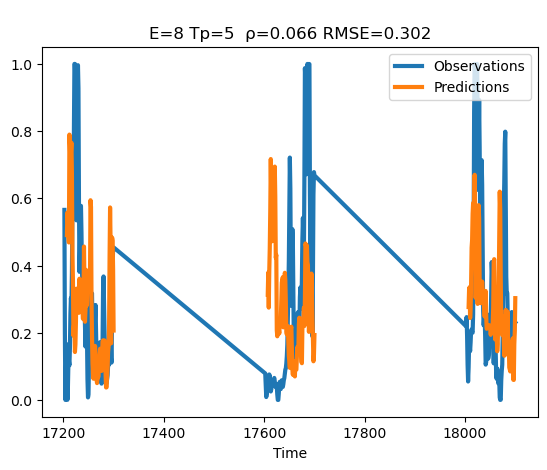

Simplex (joints → EMG):  33%|███▎      | 1/3 [00:00<00:00,  2.04it/s]

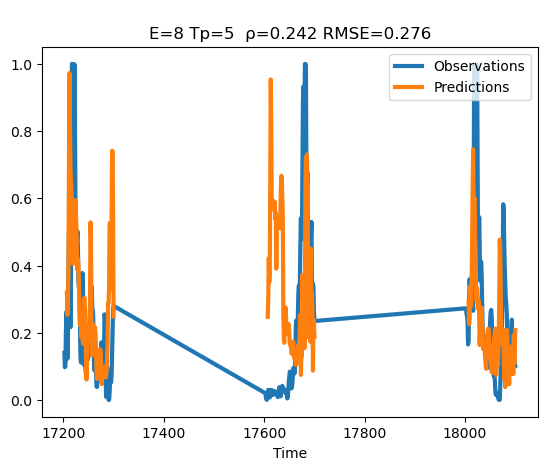

Simplex (joints → EMG):  67%|██████▋   | 2/3 [00:00<00:00,  2.07it/s]

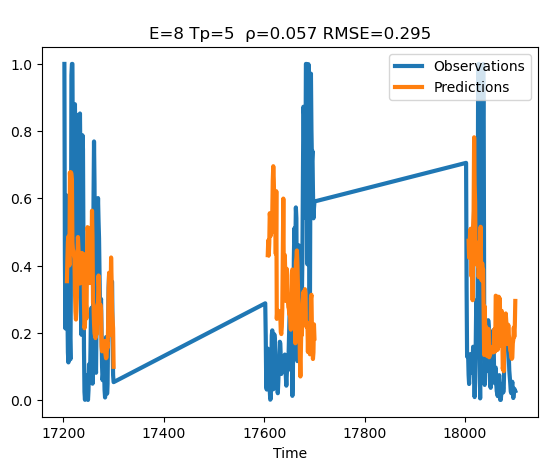

Simplex (joints → EMG): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]



ρ (padding-invariant; train 1–8000, test 8001–13000):
            rho
Triceps  0.242
AD       0.066
Biceps   0.057


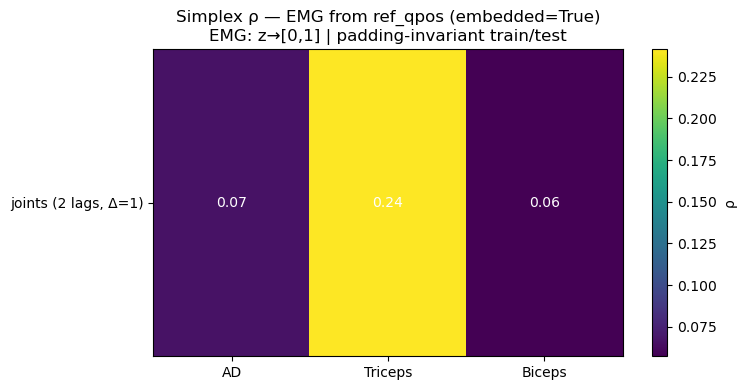


Saved: simplex_emg_from_joints_only_masked/rho_joints_only_masked.csv and plots in simplex_emg_from_joints_only_masked/


In [20]:
# === Simplex: predict EMG from ref_qpos joints ONLY (no actions), padding-invariant ===
# Train: 1..8000 ; Test: 8001..13000   (converted to valid ranges after masking)
# EMG: z-score -> robust [0,1] (percentiles), clipped to [0,1]
# Joints: z-scores
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
qpos_names      = ["sh_elv", "sh_ext", "sh_rot", "elbow"]   # must match ref_qpos order
JOINT_LAGS      = 2     # number of lags: [t0, t-Δ, t-2Δ, ...]
JOINT_LAG_STEP  = 1     # Δ in samples (400 Hz -> ~7.5 ms per lag)
Tp              = 5    # prediction horizon in samples
PAD             = 300   # NaN rows between clips (doesn't affect lib/pred with masks below)

OUT_DIR = "simplex_emg_from_joints_only_masked"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    cols = []
    prefix = prefix or base_col
    for k in range(E):
        name = f"{prefix}_t{-k*lag_step}"
        df[name] = df[base_col].shift(k * lag_step)
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def unit01_from_z(z, lo=1, hi=98, eps=1e-12):
    """Map z-scored vector to [0,1] using robust percentiles; clip outside."""
    p_lo = np.nanpercentile(z, lo)
    p_hi = np.nanpercentile(z, hi)
    denom = max(p_hi - p_lo, eps)
    return np.clip((z - p_lo) / denom, 0.0, 1.0)

def concat_nan_padded_emg_qpos(emg_stack: dict[str, np.ndarray],
                               qpos_stack: np.ndarray,
                               pad=100,
                               emg_to01=True,
                               emg_pct=(1, 98),
                               joints_to01=False,
                               joints_pct=(1, 99)):
    """
    Build a long NaN-padded DF with columns: time, [EMG names], [qpos_names]
    Shapes:
      emg_stack[name] -> (N, T)
      qpos_stack      -> (N, T, 4)
    Returns:
      big_df, clip_ranges (dict: clip_idx -> (start_row, end_row), 1-based inclusive)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0
    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J):   pad_df[qpos_names[j]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}

        # EMG: z-score -> [0,1] robust
        for nm in emg_names:
            x = emg_stack[nm][c]
            x = zscore(x)
            if emg_to01:
                x = unit01_from_z(x, lo=emg_pct[0], hi=emg_pct[1])
            data[nm] = x

        # Joints: z-scores (optionally to [0,1])
        for j in range(J):
            k = zscore(qpos_stack[c, :, j])
            if joints_to01:
                k = unit01_from_z(k, lo=joints_pct[0], hi=joints_pct[1])
            data[qpos_names[j]] = k

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

def mask_to_ranges(mask_bool: np.ndarray) -> str:
    """Convert boolean mask over rows (1..N) to pyEDM 'start stop ...' string (1-based)."""
    idx = np.flatnonzero(mask_bool)  # 0-based indices where True
    if idx.size == 0:
        return ""
    breaks = np.where(np.diff(idx) > 1)[0]
    starts = np.r_[idx[0], idx[breaks + 1]] + 1   # to 1-based
    stops  = np.r_[idx[breaks], idx[-1]] + 1
    parts = []
    for s, e in zip(starts, stops):
        parts.extend([str(int(s)), str(int(e))])
    return " ".join(parts)

# ---------------- Reuse your processed EMG & ref_qpos stacks -----------------------
# Must already exist:
#   emg_stack  (dict name -> (N,200))   — EMG trial windows
#   ref_sel    (N,200,4)                — ref_qpos aligned to those trials
if 'emg_stack' not in globals() or 'ref_sel' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel).")

# ---------------- Build long DF with EMG + qpos (NO actions) ----------------------
big_df, clip_ranges = concat_nan_padded_emg_qpos(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    pad=PAD,
    emg_to01=True,      # EMG mapped to [0,1] after z-score
    emg_pct=(1, 98),
    joints_to01=False   # keep joints as z-scores
)

# ---------------- Manual joint embedding (embedded=True) --------------------------
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(
        big_df, base_col=j, E=JOINT_LAGS, lag_step=JOINT_LAG_STEP,
        prefix=f"{j}_emb{JOINT_LAGS}"
    )

predictor_cols = joint_emb_cols
emg_targets = list(emg_stack.keys())  # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# ---------------- Padding-invariant lib/pred masks --------------------------------
N_total     = len(big_df)
TRAIN_START, TRAIN_END = 1,      min(17000,  N_total)
TEST_START,  TEST_END  = min(17001, N_total), min(22700, N_total)

row_ids = np.arange(N_total) + 1  # 1-based row indices
in_train = (row_ids >= TRAIN_START) & (row_ids <= TRAIN_END)
in_test  = (row_ids >= TEST_START)  & (row_ids <= TEST_END)

# Predictors must be finite for a row to be usable
valid_X = np.isfinite(big_df[predictor_cols]).all(axis=1).to_numpy()

# Ensure target-at-Tp exists within the same clip and lagged coords are finite
clip_keep = np.zeros(N_total, dtype=bool)
lag_edge  = (JOINT_LAGS - 1) * JOINT_LAG_STEP
for c, (s1, e1) in clip_ranges.items():  # 1-based inclusive
    s0, e0 = s1 - 1, e1 - 1
    start_ok = s0 + lag_edge
    end_ok   = e0 - Tp
    if end_ok >= start_ok:
        clip_keep[start_ok:end_ok+1] = True

rhos = {}
pred_store = {}
E_dim = len(predictor_cols)   # embedded=True → E = number of predictor columns

for t in tqdm(emg_targets, desc="Simplex (joints → EMG)"):
    # target-at-Tp must exist (future obs)
    valid_y_Tp = np.isfinite(big_df[t].shift(-Tp)).to_numpy()

    lib_mask  = valid_X & valid_y_Tp & clip_keep & in_train
    pred_mask = valid_X & valid_y_Tp & clip_keep & in_test

    lib_ranges  = mask_to_ranges(lib_mask)
    pred_ranges = mask_to_ranges(pred_mask)

    if not lib_ranges or not pred_ranges:
        print(f"[WARN] {t}: empty lib/pred after masking — skipping.")
        rhos[t] = np.nan
        continue

    # NOTE: validLib MUST be a pandas Series, not a list
    validLib_series = pd.Series(lib_mask)

    pred_df = Simplex(
        dataFrame=big_df,
        lib=lib_ranges, pred=pred_ranges,
        columns=" ".join(predictor_cols),
        target=t,
        E=E_dim, tau=-1, Tp=Tp,            # tau ignored with embedded=True
        embedded=True, validLib=validLib_series,
        exclusionRadius=Tp,               # avoid trivial neighbors
        ignoreNan=True, showPlot=True
    )

    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap --------------------------------------------
rho_df = pd.Series(rhos, name="rho").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_joints_only_masked.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho", ascending=False)
print("\nρ (padding-invariant; train 1–8000, test 8001–13000):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho"].to_numpy()[None, :]
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"joints ({JOINT_LAGS} lags, Δ={JOINT_LAG_STEP})"])
ax.set_title("Simplex ρ — EMG from ref_qpos (embedded=True)\nEMG: z→[0,1] | padding-invariant train/test")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
for j, v in enumerate(rho_df["rho"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_joints_only_masked.png"), dpi=150)
plt.show()

# ---------------- Plot obs vs pred traces (first 300 test rows) -------------------
FIRST_N = 300
for t in emg_targets:
    dfp = pred_store.get(t)
    if dfp is None or dfp.empty: 
        continue
    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"] if "Time" in dfp.columns else pd.Series(np.arange(len(dfp)))
    t_axis = t_axis.iloc[:K].to_numpy()
    obs = dfp["Observations"].to_numpy()[:K]
    hat = dfp["Predictions"].to_numpy()[:K]

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(t_axis, obs, label="Observation (EMG, 0–1)", linewidth=2)
    ax.plot(t_axis, hat, label="Prediction (Simplex)", linewidth=2)
    ax.set_title(f"(joints only) → {t} | ρ={rhos[t]:.3f} | first {K} test rows")
    ax.set_xlabel("Global time index (pred rows)")
    ax.set_ylabel("scaled units")
    ax.grid(alpha=0.3); ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_masked.png"), dpi=150)
    plt.close(fig)

print(f"\nSaved: {rho_csv} and plots in {OUT_DIR}/")


/tmp/ipykernel_1904807/1652213470.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)


Simplex lib:  1 17000
Simplex pred: 17001 18100 (N_total=18100)


Simplex (actions → EMG):   0%|          | 0/3 [00:00<?, ?it/s]

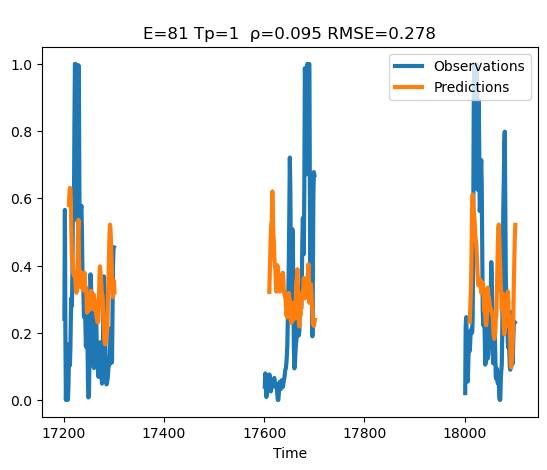

Simplex (actions → EMG):  33%|███▎      | 1/3 [00:00<00:01,  1.69it/s]

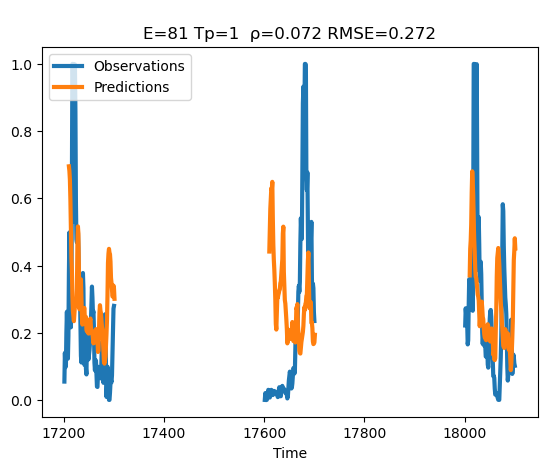

Simplex (actions → EMG):  67%|██████▋   | 2/3 [00:01<00:00,  1.70it/s]

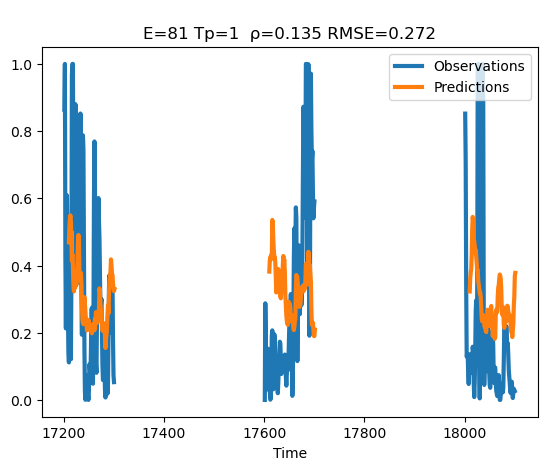

Simplex (actions → EMG): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]



ρ (train 1–8000, test 8001–13000):
            rho
Biceps   0.135
AD       0.095
Triceps  0.072


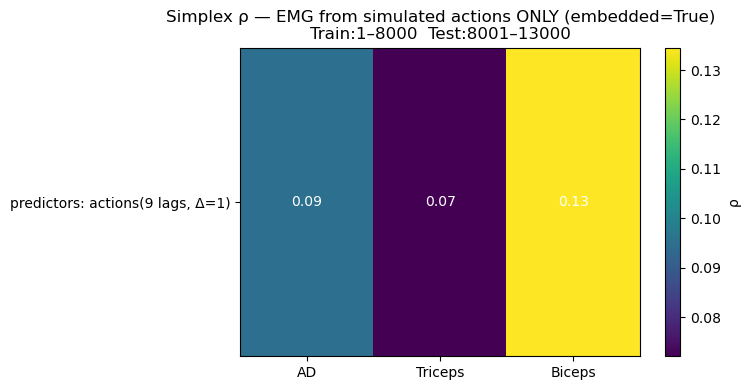


Saved: simplex_emg_from_actions_only_fixedsplits/rho_actions_only_to_emg_fixedsplits.csv and plots in simplex_emg_from_actions_only_fixedsplits/


In [21]:
# === Simplex: predict EMG from simulated actions ONLY (no qpos) ===================
# Train window: 1..8000 ; Test window: 8001..13000 (1-based, inclusive)
# EMG: z-score -> robust [0,1] using percentiles, clipped to [0,1]
# Actions: clipped to [0,1], manual time-lag embedding, embedded=True
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm_new.h5"  # must contain dataset 'actions'
action_names = [f"act{i}" for i in range(9)]

# Action embedding (your note: action lag ~ -10)
ACTION_LAGS      = 9   # produces [t0, t-1, ..., t-10]
ACTION_LAG_STEP  = 1    # step between lags (in samples)
Tp               = 1   # prediction horizon (samples at 400 Hz)
PAD              = 300  # NaN gap between clips (prevents cross-clip neighbors)
OUT_DIR = "simplex_emg_from_actions_only_fixedsplits"
os.makedirs(OUT_DIR, exist_ok=True)

# Optional: set a cap on knn (default Simplex uses E+1)
KNN = None  # e.g., set to 25 to limit neighbors; leave None for default

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    cols = []
    prefix = prefix or base_col
    for k in range(E):
        name = f"{prefix}_t{-k*lag_step}"
        df[name] = df[base_col].shift(k * lag_step)
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def unit01_from_z(z, lo=1, hi=98, eps=1e-12):
    """Map z-scored vector to [0,1] using robust percentiles; clip outside."""
    p_lo = np.nanpercentile(z, lo)
    p_hi = np.nanpercentile(z, hi)
    denom = max(p_hi - p_lo, eps)
    return np.clip((z - p_lo) / denom, 0.0, 1.0)

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L:
        return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def concat_nan_padded_emg_actions(emg_stack: dict[str, np.ndarray],
                                  actions_stack: np.ndarray,
                                  pad=300,
                                  emg_to01=True,
                                  emg_pct=(1, 98),
                                  clip_actions=True):
    """
    Build a long NaN-padded DF with columns: time, [EMG names], [act0..act8]
    Shapes:
      emg_stack[name] -> (N, T)
      actions_stack   -> (N, T, 9)
    EMG: z-score -> robust [0,1]
    Actions: clipped to [0,1] (no z-score)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    A = actions_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0
    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for a in range(A):   pad_df[action_names[a]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}

        # EMG columns: z-score -> [0,1] robust
        for nm in emg_names:
            x = emg_stack[nm][c]
            x = zscore(x)
            if emg_to01:
                x = unit01_from_z(x, lo=emg_pct[0], hi=emg_pct[1])
            data[nm] = x

        # Action columns: clip to [0,1]
        for a in range(A):
            v = actions_stack[c, :, a]
            if clip_actions:
                v = np.clip(v, 0.0, 1.0)
            data[action_names[a]] = v

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

# ---------------- Reuse your processed EMG stacks & trial alignment ----------------
# Must already exist from your earlier pipeline:
#   emg_stack  (dict name -> (N,200))    — EMG trial windows
#   common_trials (list of aligned trial indices)
if 'emg_stack' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Please run your EMG-processing cell first (emg_stack, common_trials).")

# ---------------- Load actions from H5 and align to the same trials ---------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (N_sim, T, 9)

# Ensure T=200 (same as EMG trial windows)
target_samples = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_samples:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_samples)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to EMG trials
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]               # (N_common, 200, 9)
else:
    K = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:K]
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:K]

# ---------------- Build long DF with EMG + actions (NO joints) --------------------
big_df, clip_ranges = concat_nan_padded_emg_actions(
    emg_stack=emg_stack,
    actions_stack=act_sel,
    pad=PAD,
    emg_to01=True,        # EMG scaled to [0,1] robustly (1–98th pct)
    emg_pct=(1, 98),
    clip_actions=True     # actions clipped to [0,1]
)

# ---------------- Fixed global lib/pred windows -----------------------------------
N_total   = len(big_df)
lib_end   = min(17000,  N_total)   # 1..8000
pred_start= min(17001,  N_total)   # 8001..
pred_end  = min(22700, N_total)   # ..13000
lib  = f"1 {lib_end}"
pred = f"{pred_start} {pred_end}"
print(f"Simplex lib:  {lib}")
print(f"Simplex pred: {pred} (N_total={N_total})")

# ---------------- Manual embedding of actions (embedded=True) ---------------------
action_emb_cols = []
for a in action_names:
    action_emb_cols += make_lagged_columns(
        big_df, base_col=a, E=ACTION_LAGS, lag_step=ACTION_LAG_STEP,
        prefix=f"{a}_emb{ACTION_LAGS}"
    )

predictor_cols = action_emb_cols
emg_targets = list(emg_stack.keys())  # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# ---------------- validLib mask (require finite predictors & t, and t+Tp) ---------
pred_ok = np.isfinite(big_df[emg_targets]).all(axis=1)
pred_ok_future = big_df[emg_targets].shift(-Tp).apply(np.isfinite).all(axis=1)
X_ok = np.isfinite(big_df[predictor_cols]).all(axis=1)
lib_mask = (pred_ok & pred_ok_future & X_ok)
lib_mask = pd.Series(lib_mask.values, index=big_df.index)  # pyEDM expects a Series

# ---------------- Run Simplex once per EMG target ---------------------------------
rhos = {}
pred_store = {}

E_dim = len(predictor_cols)  # embedded=True → E = number of predictor columns
for t in tqdm(emg_targets, desc="Simplex (actions → EMG)"):
    # If this target is mostly NaN in pred window, skip gracefully
    if not np.isfinite(big_df.loc[pred_start-1:pred_end-1, t]).any():
        rhos[t] = np.nan
        continue

    kwargs = dict(
        dataFrame=big_df,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=E_dim, tau=-1, Tp=Tp,
        embedded=True,
        validLib=lib_mask,           # boolean Series
        exclusionRadius=Tp,          # avoid trivial neighbors
        ignoreNan=True, showPlot=True
    )
    if KNN is not None:
        kwargs["knn"] = int(KNN)

    pred_df = Simplex(**kwargs)

    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap --------------------------------------------
rho_df = pd.Series(rhos, name="rho").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_actions_only_to_emg_fixedsplits.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho", ascending=False)
print("\nρ (train 1–8000, test 8001–13000):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho"].to_numpy()[None, :]  # 1 × n_targets
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"predictors: actions({ACTION_LAGS} lags, Δ={ACTION_LAG_STEP})"])
ax.set_title("Simplex ρ — EMG from simulated actions ONLY (embedded=True)\nTrain:1–8000  Test:8001–13000")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
for j, v in enumerate(rho_df["rho"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_actions_only_fixedsplits.png"), dpi=150)
plt.show()

# ---------------- Plot obs vs pred traces (first 750 test rows) -------------------
FIRST_N = 750
for t in emg_targets:
    if t not in pred_store:  # skipped due to NaNs
        continue
    dfp = pred_store[t]
    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"] if "Time" in dfp.columns else pd.Series(np.arange(len(dfp)))
    t_axis = t_axis.iloc[:K].to_numpy()
    obs = dfp["Observations"].to_numpy()[:K]
    hat = dfp["Predictions"].to_numpy()[:K]

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(t_axis, obs, label="Observation (EMG, 0–1)", linewidth=2)
    ax.plot(t_axis, hat, label="Prediction (Simplex)", linewidth=2)
    ax.set_title(f"(actions only) → {t} | ρ={rhos[t]:.3f} | first {K} test rows (global 8001+)")
    ax.set_xlabel("Global time index (pred rows)"); ax.set_ylabel("scaled units")
    ax.grid(alpha=0.3); ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_actions_only_fixedsplits.png"), dpi=150)
    plt.close(fig)

print(f"\nSaved: {rho_csv} and plots in {OUT_DIR}/")


/tmp/ipykernel_1904807/1287899613.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)


Simplex lib:  1 18000
Simplex pred: 18001 18100 (N_total=18100)
Embedding summary → joints: 2 lags @ step -1; actions: 5 lags @ step -1; total predictor dims: 53


Simplex (joints+actions → EMG):   0%|          | 0/3 [00:00<?, ?it/s]

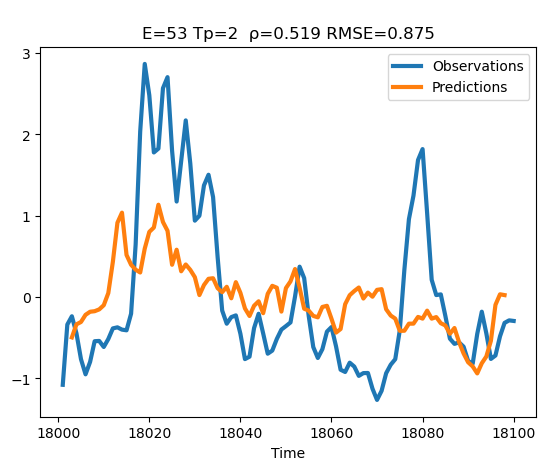

Simplex (joints+actions → EMG):  33%|███▎      | 1/3 [00:00<00:00,  7.79it/s]

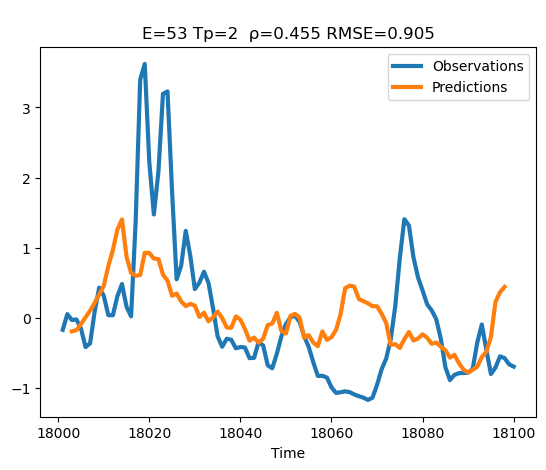

Simplex (joints+actions → EMG):  67%|██████▋   | 2/3 [00:00<00:00,  7.76it/s]

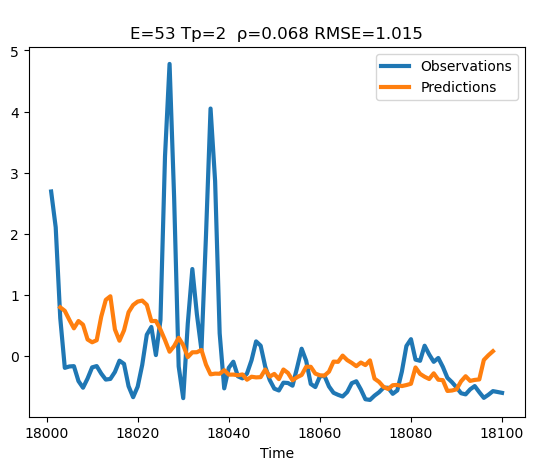

Simplex (joints+actions → EMG): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]



ρ (train 1–8000, test 8001–13000):
            rho
AD       0.519
Triceps  0.455
Biceps   0.068


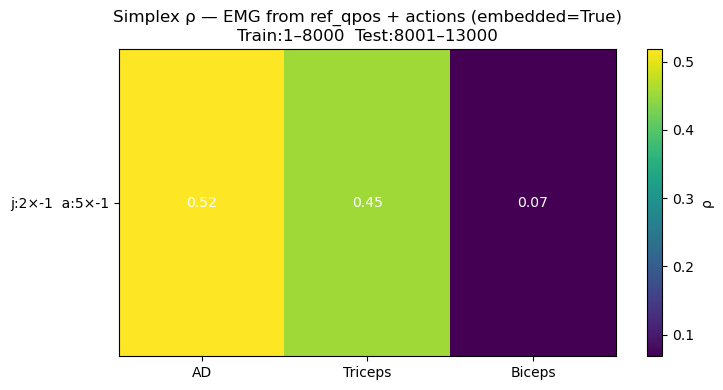


Saved: simplex_emg_from_joints_actions_fixedsplits/rho_joints_plus_actions_to_emg_fixedsplits.csv and plots in simplex_emg_from_joints_actions_fixedsplits/


In [23]:
# === Simplex: predict EMG from (ref_qpos joints + sim actions) ====================
# Train: 1..8000 ; Test: 8001..13000 (1-based, inclusive)
# Manual embedding with embedded=True
#   • Joints: JOINT_LAGS using JOINT_LAG_STEP (e.g., t0, t-1)
#   • Actions: ACTION_LAGS using ACTION_LAG_STEP (e.g., t0, t-10, t-20, ...)
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm_new.h5"  # contains 'ref_qpos' and 'actions'
qpos_names   = ["sh_elv", "sh_ext", "sh_rot", "elbow"]         # must match ref_qpos order
action_names = [f"act{i}" for i in range(9)]

# Embedding setup for predictors
JOINT_LAGS       = 2     # number of joint lags to include
JOINT_LAG_STEP   = -1     # step (in samples) between joint lags: 1 → t0, t-1
ACTION_LAGS      = 5     # number of action lags to include
ACTION_LAG_STEP  = -1    # step (in samples) between action lags: 10 → t0, t-10, t-20, ...
# NOTE: at 400 Hz, 10 samples ≈ 25 ms

# Simplex params
Tp = 2              # 1-step ahead
OUT_DIR = "simplex_emg_from_joints_actions_fixedsplits"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    """Create manual lags [t0, t-lag_step, t-2*lag_step, ...] as separate columns."""
    if prefix is None:
        prefix = base_col
    cols = []
    for k in range(E):
        shift_amt = k * lag_step
        name = f"{prefix}_t{-shift_amt}"
        df[name] = df[base_col].shift(shift_amt)  # positive shift => past values aligned at current t
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L: return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_nan_padded_full(emg_stack: dict[str, np.ndarray],
                           qpos_stack: np.ndarray,
                           act_stack: np.ndarray,
                           pad=100,
                           standardize=True):
    """
    Build a long NaN-padded DF with columns:
      time, [EMG names], [qpos_names], [act0..act8]
    Stacks have shapes:
      emg_stack[name] -> (N, T)
      qpos_stack      -> (N, T, 4)
      act_stack       -> (N, T, 9)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]
    A = act_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J):   pad_df[qpos_names[j]] = np.nan
            for a in range(A):   pad_df[action_names[a]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        # EMG
        for nm in emg_names:
            x = emg_stack[nm][c]
            data[nm] = zscore(x) if standardize else x
        # qpos
        for j in range(J):
            k = qpos_stack[c, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k
        # actions
        for a in range(A):
            v = act_stack[c, :, a]
            data[action_names[a]] = zscore(v) if standardize else v

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

# ---------------- Reuse your processed EMG & ref_qpos stacks -----------------------
# Requires: emg_stack (dict name->(N,200)), ref_sel (N,200,4), common_trials (list)
if 'emg_stack' not in globals() or 'ref_sel' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel, common_trials).")

# ---------------- Load actions from H5 and align to the same trials ---------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (N_sim, T, 9)

# Ensure T=200 (same as EMG/ref_qpos)
target_samples = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_samples:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_samples)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to the EMG trials used earlier (common_trials ordering)
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]  # (N_common, 200, 9)
else:
    K = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:K]
    # also trim emg_stack and ref_sel to K if needed
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:K]
    ref_sel = ref_sel[:K]

# ---------------- Build long DF with EMG + qpos + actions -------------------------
PAD = 300
big_df_all, clip_ranges = concat_nan_padded_full(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    act_stack=act_sel,
    pad=PAD,
    standardize=True   # <- keep as-is if you're z-scoring; switch off if you pre-normalize elsewhere
)

# ---------------- Fixed global lib/pred windows -----------------------------------
N_total = len(big_df_all)
lib_end    = min(18000, N_total)            # 1..8000
pred_start = min(18001, N_total)            # 8001..
pred_end   = min(22700, N_total)           # ..13000
lib  = f"1 {lib_end}"
pred = f"{pred_start} {pred_end}"
print(f"Simplex lib:  {lib}")
print(f"Simplex pred: {pred} (N_total={N_total})")

# ---------------- Manual embedding columns (embedded=True) ------------------------
# joints: use JOINT_LAG_STEP; actions: use ACTION_LAG_STEP
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(
        big_df_all, base_col=j, E=JOINT_LAGS, lag_step=JOINT_LAG_STEP,
        prefix=f"{j}_emb{JOINT_LAGS}x{JOINT_LAG_STEP}"
    )

action_emb_cols = []
for a in action_names:
    action_emb_cols += make_lagged_columns(
        big_df_all, base_col=a, E=ACTION_LAGS, lag_step=ACTION_LAG_STEP,
        prefix=f"{a}_emb{ACTION_LAGS}x{ACTION_LAG_STEP}"
    )

predictor_cols = joint_emb_cols + action_emb_cols
emg_targets = list(emg_stack.keys())   # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df_all.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print(f"Embedding summary → joints: {JOINT_LAGS} lags @ step {JOINT_LAG_STEP}; "
      f"actions: {ACTION_LAGS} lags @ step {ACTION_LAG_STEP}; "
      f"total predictor dims: {len(predictor_cols)}")

# ---------------- Run Simplex once per EMG target ---------------------------------
rhos = {}
pred_store = {}  # name -> DataFrame of obs/pred for plotting

# With embedded=True, the effective E is len(predictor_cols); tau is ignored
for t in tqdm(emg_targets, desc="Simplex (joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df_all,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=len(predictor_cols), tau=0, Tp=Tp,   # tau irrelevant when embedded=True
        embedded=True,
        ignoreNan=True, showPlot=True
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap --------------------------------------------
rho_df = pd.Series(rhos, name="rho").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_joints_plus_actions_to_emg_fixedsplits.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho", ascending=False)
print("\nρ (train 1–8000, test 8001–13000):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho"].to_numpy()[None, :]  # 1 × n_targets
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"j:{JOINT_LAGS}×{JOINT_LAG_STEP}  a:{ACTION_LAGS}×{ACTION_LAG_STEP}"])
ax.set_title("Simplex ρ — EMG from ref_qpos + actions (embedded=True)\nTrain:1–8000  Test:8001–13000")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ")
for j, v in enumerate(rho_df["rho"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_fixedsplits.png"), dpi=150)
plt.show()

# ---------------- Plot obs vs pred traces (first 1000 test rows) ------------------
FIRST_N = 1000
for t in emg_targets:
    dfp = pred_store[t]
    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"] if "Time" in dfp.columns else pd.Series(np.arange(len(dfp)))
    t_axis = t_axis.iloc[:K].to_numpy()
    obs = dfp["Observations"].to_numpy()[:K]
    hat = dfp["Predictions"].to_numpy()[:K]

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(t_axis, obs, label="Observation (EMG)", linewidth=2)
    ax.plot(t_axis, hat, label="Prediction (Simplex)", linewidth=2)
    ax.set_title(f"(joints+actions) → {t} | ρ={rhos[t]:.3f} | first {K} test rows (global 8001+)")
    ax.set_xlabel("Global time index (pred rows)"); ax.set_ylabel("z-score")
    ax.grid(alpha=0.3); ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_fixedsplits.png"), dpi=150)
    plt.close(fig)

print(f"\nSaved: {rho_csv} and plots in {OUT_DIR}/")


/tmp/ipykernel_245238/3677837629.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat(frames, ignore_index=True)
/tmp/ipykernel_245238/3677837629.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df[base_col].shift(shift_amt)  # positive shift => past aligned at current t
/tmp/ipykernel_245238/3677837629.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

Simplex lib:  1 18000
Simplex pred: 18001 18100 (N_total=18100)
Embedding summary → joints: 2 lags @ step 1; actions: 9 lags @ step 1; total predictor dims: 89


Simplex (joints+actions → EMG): 100%|██████████| 2/2 [00:00<00:00, 21.89it/s]



ρ (z-space; train 1–8000, test 8001–13000):
          rho_z
AD      -0.028
Triceps -0.073


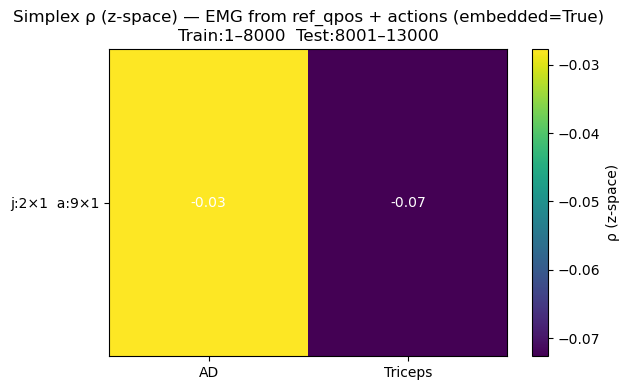

ρ by EMG target (fit/ρ in z-score space): {'AD': -0.028, 'Triceps': -0.073}


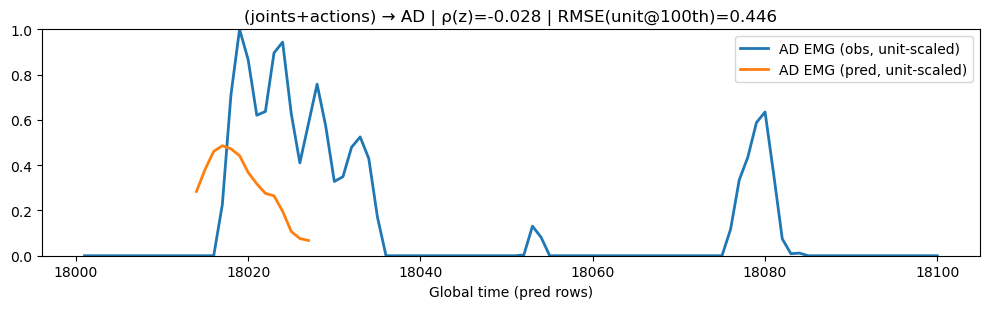

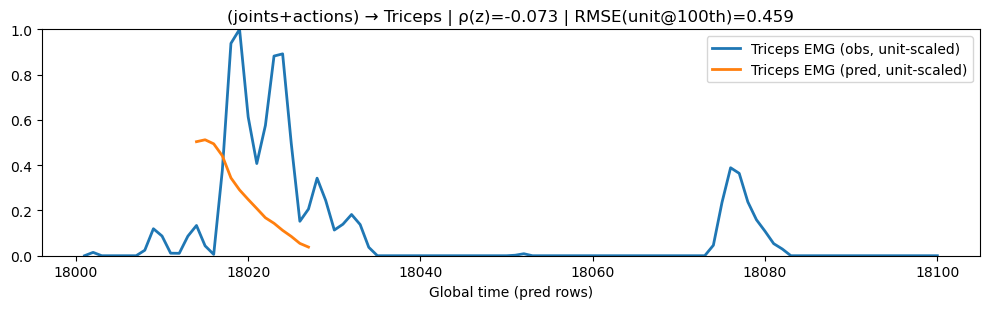


Saved metrics:
          rho_z  rmse_unit_p100
AD      -0.028           0.446
Triceps -0.073           0.459

Saved: simplex_emg_from_joints_actions_fixedsplits/rho_zspace_joints_plus_actions_to_emg_fixedsplits.csv, rho_heatmap_zspace_fixedsplits.png, and unit-RMSE plots in simplex_emg_from_joints_actions_fixedsplits/


In [6]:
# %%time
# === Simplex: predict EMG from (ref_qpos joints + sim actions) ====================
# Train: 1..8000 ; Test: 8001..13000 (1-based, inclusive)
# Fit on z-scored EMG/qpos/actions (keeps high ρ), but compute/plot RMSE on a 0–1 unit scale
# via linear percentile scaling applied AFTER Simplex (doesn't affect ρ).
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm_new.h5"  # contains 'actions'
qpos_names   = ["sh_elv", "sh_ext", "sh_rot", "elbow"]         # must match ref_qpos order
action_names = [f"act{i}" for i in range(9)]

# Embedding setup for predictors
JOINT_LAGS       = 2     # number of joint lags to include
JOINT_LAG_STEP   = 1     # step (in samples) between joint lags: 1 → t0, t-1
ACTION_LAGS      = 9     # number of action lags to include
ACTION_LAG_STEP  = 1     # step between action lags: 1 → t0..t-8

# Simplex params
Tp = 5
OUT_DIR = "simplex_emg_from_joints_actions_fixedsplits"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    """Create manual lags [t0, t-lag_step, t-2*lag_step, ...] as separate columns."""
    if prefix is None:
        prefix = base_col
    cols = []
    for k in range(E):
        shift_amt = k * lag_step
        name = f"{prefix}_t{-shift_amt}"
        df[name] = df[base_col].shift(shift_amt)  # positive shift => past aligned at current t
        cols.append(name)
    return cols

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L: return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_nan_padded_full(emg_stack: dict[str, np.ndarray],
                           qpos_stack: np.ndarray,
                           act_stack: np.ndarray,
                           pad=100,
                           standardize=True):
    """
    Build a long NaN-padded DF with columns:
      time, [EMG names], [qpos_names], [act0..act8]
    Stacks have shapes:
      emg_stack[name] -> (N, T)
      qpos_stack      -> (N, T, 4)
      act_stack       -> (N, T, 9)
    """
    emg_names = list(emg_stack.keys())
    N, T = next(iter(emg_stack.values())).shape
    J = qpos_stack.shape[-1]
    A = act_stack.shape[-1]

    frames, clip_ranges = [], {}
    row_cursor = 0

    for c in range(N):
        if c > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names: pad_df[nm] = np.nan
            for j in range(J):   pad_df[qpos_names[j]] = np.nan
            for a in range(A):   pad_df[action_names[a]] = np.nan
            frames.append(pad_df); row_cursor += pad

        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}
        # EMG
        for nm in emg_names:
            x = emg_stack[nm][c]
            data[nm] = zscore(x) if standardize else x
        # qpos
        for j in range(J):
            k = qpos_stack[c, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k
        # actions
        for a in range(A):
            v = act_stack[c, :, a]
            data[action_names[a]] = zscore(v) if standardize else v

        clip_df = pd.DataFrame(data)
        start, end = row_cursor+1, row_cursor+T
        clip_ranges[c] = (start, end)
        frames.append(clip_df); row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, clip_ranges

# --- add this near your helpers ---
def linear_unit_scale_pair(a, b, pct=98, clip=True):
    """
    Linearly rescale a & b together so that the pct-th percentile of |[a,b]| maps to 1.
    Optionally clip to [0,1] for interpretable RMSE/plots. This does NOT change rho
    because rho is computed on the original z-scored series.
    """
    a = np.asarray(a, float); b = np.asarray(b, float)
    v = np.concatenate([a[np.isfinite(a)], b[np.isfinite(b)]])
    p = np.nanpercentile(np.abs(v), pct) if v.size else 1.0
    if not np.isfinite(p) or p <= 0: p = 1.0
    a2, b2 = a / p, b / p
    if clip:
        a2 = np.clip(a2, 0.0, 1.0)
        b2 = np.clip(b2, 0.0, 1.0)
    return a2, b2, p

# ---------------- Reuse your processed EMG & ref_qpos stacks -----------------------
# Requires: emg_stack (dict name->(N,200)), ref_sel (N,200,4), common_trials (list)
if 'emg_stack' not in globals() or 'ref_sel' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing cell first (emg_stack, ref_sel, common_trials).")

# ---------------- Load actions from H5 and align to the same trials ---------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (N_sim, T, 9)

# Ensure T=200 (same as EMG/ref_qpos)
target_samples = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_samples:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_samples)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to the EMG trials used earlier (common_trials ordering)
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]  # (N_common, 200, 9)
else:
    K = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:K]
    # also trim emg_stack and ref_sel to K if needed
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:K]
    ref_sel = ref_sel[:K]

# ---------------- Build long DF with EMG + qpos + actions -------------------------
PAD = 300
big_df_all, clip_ranges = concat_nan_padded_full(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    act_stack=act_sel,
    pad=PAD,
    standardize=True   # fit in z-score space (keeps high ρ)
)

# ---------------- Fixed global lib/pred windows -----------------------------------
N_total = len(big_df_all)
lib_end    = min(18000, N_total)
pred_start = min(18001, N_total)
pred_end   = min(22700, N_total)
lib  = f"1 {lib_end}"
pred = f"{pred_start} {pred_end}"
print(f"Simplex lib:  {lib}")
print(f"Simplex pred: {pred} (N_total={N_total})")

# ---------------- Manual embedding columns (embedded=True) ------------------------
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(
        big_df_all, base_col=j, E=JOINT_LAGS, lag_step=JOINT_LAG_STEP,
        prefix=f"{j}_emb{JOINT_LAGS}x{JOINT_LAG_STEP}"
    )

action_emb_cols = []
for a in action_names:
    action_emb_cols += make_lagged_columns(
        big_df_all, base_col=a, E=ACTION_LAGS, lag_step=ACTION_LAG_STEP,
        prefix=f"{a}_emb{ACTION_LAGS}x{ACTION_LAG_STEP}"
    )

predictor_cols = joint_emb_cols + action_emb_cols
emg_targets = list(emg_stack.keys())   # e.g., ['AD','Triceps','Biceps']

# sanity
missing = sorted(set(predictor_cols + emg_targets) - set(big_df_all.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print(f"Embedding summary → joints: {JOINT_LAGS} lags @ step {JOINT_LAG_STEP}; "
      f"actions: {ACTION_LAGS} lags @ step {ACTION_LAG_STEP}; "
      f"total predictor dims: {len(predictor_cols)}")

# ---------------- Run Simplex once per EMG target (fit on z-scored data) ----------
rhos = {}
pred_store = {}  # name -> DataFrame of obs/pred for plotting

for t in tqdm(emg_targets, desc="Simplex (joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df_all,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=len(predictor_cols), tau=0, Tp=Tp,   # tau irrelevant when embedded=True
        embedded=True,
        ignoreNan=True, showPlot=False
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)  # ρ in z-score space
    pred_store[t] = pred_df.copy()

# ---------------- Save table & heatmap (ρ in z-space) -----------------------------
rho_df = pd.Series(rhos, name="rho_z").to_frame()
rho_csv = os.path.join(OUT_DIR, "rho_zspace_joints_plus_actions_to_emg_fixedsplits.csv")
rho_df.to_csv(rho_csv, float_format="%.6f")

rho_sorted = rho_df.sort_values("rho_z", ascending=False)
print("\nρ (z-space; train 1–8000, test 8001–13000):\n", rho_sorted.round(3))

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho_z"].to_numpy()[None, :]  # 1 × n_targets
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"j:{JOINT_LAGS}×{JOINT_LAG_STEP}  a:{ACTION_LAGS}×{ACTION_LAG_STEP}"])
ax.set_title("Simplex ρ (z-space) — EMG from ref_qpos + actions (embedded=True)\nTrain:1–8000  Test:8001–13000")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ (z-space)")
for j, v in enumerate(rho_df["rho_z"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_zspace_fixedsplits.png"), dpi=150)
plt.show()

# ---------------- Quick summary & 0–1 RMSE plots (ρ in z-space, RMSE in unit space) ---------------
print("ρ by EMG target (fit/ρ in z-score space):", {k: (None if v is np.nan else round(v,3)) for k,v in rhos.items()})

FIRST_N = 2000
UNIT_PCT = 100  # unit scaling percentile for plots/RMSE

rmse_unit = {}
for t in emg_targets:
    dfp = pred_store[t]
    # Full predicted window arrays
    obs_z = dfp["Observations"].to_numpy()
    hat_z = dfp["Predictions"].to_numpy()
    rho_z = _safe_corr(obs_z, hat_z, min_pairs=10)

    # Linearly scale for interpretability ONLY
    obs_u, hat_u, p = linear_unit_scale_pair(obs_z, hat_z, pct=UNIT_PCT, clip=True)
    rmse_u = float(np.sqrt(np.nanmean((obs_u - hat_u)**2)))
    rmse_unit[t] = rmse_u

    # Plot a segment with 0–1 axis
    K = min(FIRST_N, len(dfp))
    t_axis = (dfp["Time"].iloc[:K].to_numpy() if "Time" in dfp.columns else np.arange(K))
    plt.figure(figsize=(10,3.2))
    plt.plot(t_axis, obs_u[:K], label=f"{t} EMG (obs, unit-scaled)", linewidth=2)
    plt.plot(t_axis, hat_u[:K], label=f"{t} EMG (pred, unit-scaled)", linewidth=2)
    plt.ylim(0, 1)
    plt.title(f"(joints+actions) → {t} | ρ(z)={rho_z:.3f} | RMSE(unit@{UNIT_PCT}th)={rmse_u:.3f}")
    plt.xlabel("Global time (pred rows)"); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_unitRMSE.png"), dpi=150)
    plt.show()

# Save combined metrics
metrics_df = pd.DataFrame({"rho_z": pd.Series(rhos), f"rmse_unit_p{UNIT_PCT}": pd.Series(rmse_unit)})
metrics_df.to_csv(os.path.join(OUT_DIR, f"metrics_rhoZ_rmseUnit_p{UNIT_PCT}.csv"), float_format="%.6f")
print("\nSaved metrics:\n", metrics_df.round(3))
print(f"\nSaved: {rho_csv}, rho_heatmap_zspace_fixedsplits.png, and unit-RMSE plots in {OUT_DIR}/")

/tmp/ipykernel_3530279/516554714.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df[base_col].shift(sh)   # positive shift = past aligned at current t
/tmp/ipykernel_3530279/516554714.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df[base_col].shift(sh)   # positive shift = past aligned at current t
/tmp/ipykernel_3530279/516554714.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

lib:  10 191 510 691 1010 1191 1510 1691 2010 2191 2510 2691 3010 3191 3510 3691 4010 ...
pred: 18010 18191 18510 18691 19010 19191 19510 19691 20010 20191 20510 20691 21010 21...
Embedding margin (samples): 9
Predictor dims: 89 | R=46 reaches | T=200 per reach | PAD=300


Simplex (joints+actions → EMG):   0%|          | 0/3 [00:00<?, ?it/s]

Simplex (joints+actions → EMG): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


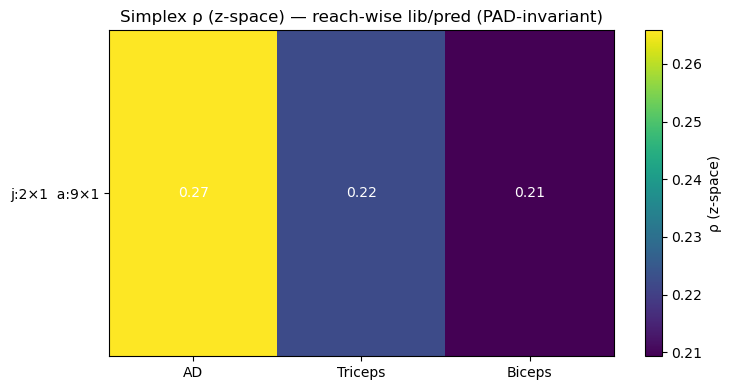

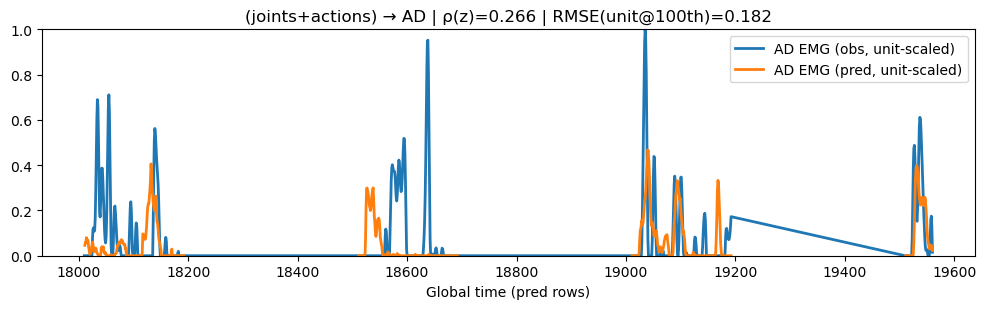

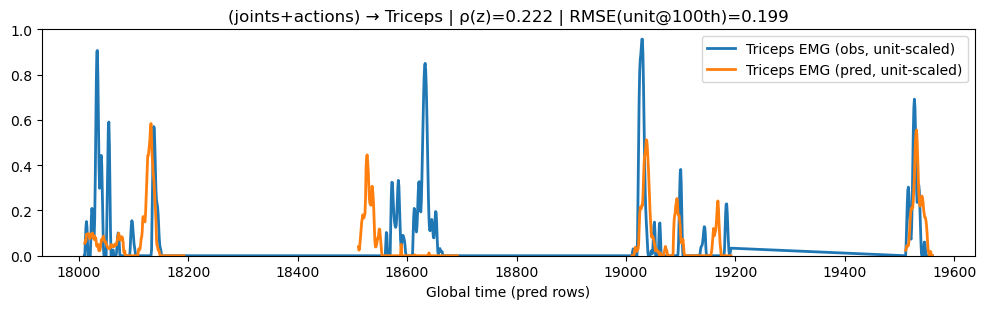

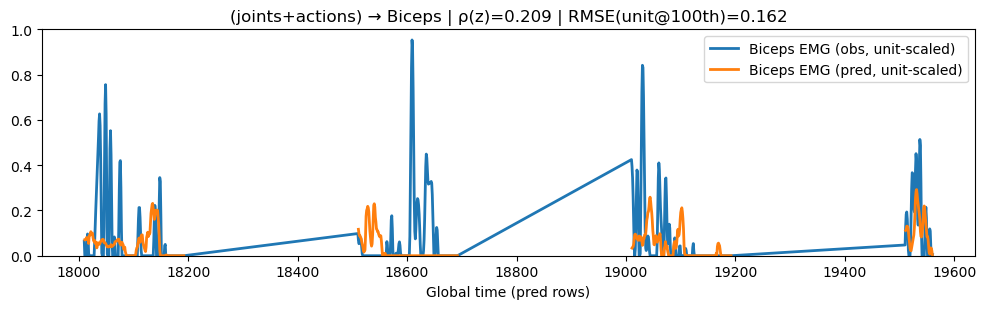

         rho_z  rmse_unit_p100
AD       0.266           0.182
Triceps  0.222           0.199
Biceps   0.209           0.162


In [91]:
# %%time
# === Simplex: EMG from (ref_qpos joints + actions), reach-wise lib/pred (PAD-invariant) ===
# Fit in z-score space; report ρ (z-space) and RMSE on 0–1 unit scale for interpretability.
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm_new.h5"  # contains 'actions'
qpos_names   = ["sh_elv", "sh_ext", "sh_rot", "elbow"]         # must match ref_qpos order
action_names = [f"act{i}" for i in range(9)]

# Embedding setup for predictors (manual lags; embedded=True)
JOINT_LAGS,  JOINT_LAG_STEP  = 2, 1   # joints: t0, t-1
ACTION_LAGS, ACTION_LAG_STEP = 9, 1   # actions: t0..t-8
Tp = 1                                 # prediction horizon (samples)

# Reach-wise split (pad-invariant): choose which reaches are train vs test
# e.g., last 10 reaches as test, rest train. Adjust as you like.
TEST_REACHES_LAST = 10

PAD = 300                               # NaN gap length (can change freely now)
OUT_DIR = "simplex_emg_from_joints_actions_reachwise"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Helpers ----------------------------------------------------------
def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def make_lagged_columns(df: pd.DataFrame, base_col: str, E: int, lag_step: int = 1,
                        prefix: str | None = None) -> list[str]:
    cols = []
    pref = prefix or base_col
    for k in range(E):
        sh = k * lag_step
        name = f"{pref}_t{-sh}"
        df[name] = df[base_col].shift(sh)   # positive shift = past aligned at current t
        cols.append(name)
    return cols

def concat_with_gaps_multi(emg_stack: dict[str, np.ndarray],
                           qpos_stack: np.ndarray,
                           act_stack: np.ndarray,
                           pad=100,
                           standardize=True):
    """
    Return:
      big_df: columns = time, [EMG names], [qpos_names], [act0..act8]
      starts: 1D array of start indices (0-based) of each reach in big_df
      T:      number of timepoints per reach (assumed constant across stacks)
    """
    emg_names = list(emg_stack.keys())
    R, T = next(iter(emg_stack.values())).shape
    J, A = qpos_stack.shape[-1], act_stack.shape[-1]

    frames, starts = [], []
    row_cursor = 0
    for r in range(R):
        if r > 0:
            pad_df = pd.DataFrame({"time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names + qpos_names + action_names:
                pad_df[nm] = np.nan
            frames.append(pad_df)
            row_cursor += pad

        starts.append(row_cursor)  # 0-based start (before adding the reach block)
        data = {"time": np.arange(row_cursor+1, row_cursor+T+1)}

        # EMG (z-score per reach if requested)
        for nm in emg_names:
            x = emg_stack[nm][r]
            data[nm] = zscore(x) if standardize else x

        # qpos (z-score per reach if requested)
        for j in range(J):
            k = qpos_stack[r, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k

        # actions (z-score per reach if requested)
        for a in range(A):
            v = act_stack[r, :, a]
            data[action_names[a]] = zscore(v) if standardize else v

        frames.append(pd.DataFrame(data))
        row_cursor += T

    big_df = pd.concat(frames, ignore_index=True)
    return big_df, np.asarray(starts, dtype=int), T

def reachwise_lib_pred_strings(starts, T, train_reaches, test_reaches, max_lag, Tp):
    """
    Build pyEDM lib/pred strings as a union of (start,end) pairs per reach,
    guarding edges by max_lag (from manual embedding) and Tp.
    Indices are 1-based inclusive.
    """
    emb_margin = int(max_lag + max(Tp, 0))

    def rng_1based(r):
        s = starts[r] + 1
        e = starts[r] + T
        s2 = s + emb_margin
        e2 = e - emb_margin
        if e2 <= s2:
            return None
        return (s2, e2)

    lib_parts, pred_parts = [], []
    for r in train_reaches:
        rge = rng_1based(r)
        if rge: lib_parts.extend([str(rge[0]), str(rge[1])])
    for r in test_reaches:
        rge = rng_1based(r)
        if rge: pred_parts.extend([str(rge[0]), str(rge[1])])

    lib_str  = " ".join(lib_parts)
    pred_str = " ".join(pred_parts)
    if not lib_str or not pred_str:
        raise RuntimeError("Empty lib/pred after margin guard; reduce lags/Tp or adjust splits.")
    return lib_str, pred_str, emb_margin

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L: return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def linear_unit_scale_pair(a, b, pct=98, clip=True):
    """
    Linearly rescale a & b together so that the pct-th percentile of |[a,b]| maps to 1.
    Optionally clip to [0,1] for interpretable RMSE/plots. ρ is computed in z-space.
    """
    a = np.asarray(a, float); b = np.asarray(b, float)
    v = np.concatenate([a[np.isfinite(a)], b[np.isfinite(b)]])
    p = np.nanpercentile(np.abs(v), pct) if v.size else 1.0
    if not np.isfinite(p) or p <= 0: p = 1.0
    a2, b2 = a / p, b / p
    if clip:
        a2 = np.clip(a2, 0.0, 1.0); b2 = np.clip(b2, 0.0, 1.0)
    return a2, b2, p

# ---------------- Prereqs check ---------------------------------------------------
# Requires: emg_stack (dict name->(R,T)), ref_sel (R,T,4), common_trials (list)
if 'emg_stack' not in globals() or 'ref_sel' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Run your EMG/ref_qpos processing first (defines emg_stack, ref_sel, common_trials).")

# ---------------- Load actions and align to EMG trials ----------------------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (N_sim, T, 9)

target_T = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_T:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_T)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to the EMG trials used earlier (common_trials ordering)
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]  # (R_common, T, 9)
else:
    Rcap = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:Rcap]
    # also trim emg_stack and ref_sel to Rcap if needed
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:Rcap]
    ref_sel = ref_sel[:Rcap]

# ---------------- Build long DF with gaps (fit in z-score space) ------------------
big_df_all, starts, T = concat_with_gaps_multi(
    emg_stack=emg_stack,
    qpos_stack=ref_sel,
    act_stack=act_sel,
    pad=PAD,
    standardize=True
)
R = len(starts)

# ---------------- Reach-wise split (pad-invariant) --------------------------------
test_reaches  = list(range(R - TEST_REACHES_LAST, R))
train_reaches = [r for r in range(R) if r not in test_reaches]

# Compute max lag from manual embedding (for edge guard)
max_lag = max((JOINT_LAGS - 1) * JOINT_LAG_STEP,
              (ACTION_LAGS - 1) * ACTION_LAG_STEP)

lib, pred, emb_margin = reachwise_lib_pred_strings(
    starts=starts, T=T,
    train_reaches=train_reaches, test_reaches=test_reaches,
    max_lag=max_lag, Tp=Tp
)
print(f"lib:  {lib[:80]}{'...' if len(lib)>80 else ''}")
print(f"pred: {pred[:80]}{'...' if len(pred)>80 else ''}")
print("Embedding margin (samples):", emb_margin)

# ---------------- Manual embedding columns (embedded=True) ------------------------
joint_emb_cols = []
for j in qpos_names:
    joint_emb_cols += make_lagged_columns(
        big_df_all, base_col=j, E=JOINT_LAGS, lag_step=JOINT_LAG_STEP,
        prefix=f"{j}_emb{JOINT_LAGS}x{JOINT_LAG_STEP}"
    )

action_emb_cols = []
for a in action_names:
    action_emb_cols += make_lagged_columns(
        big_df_all, base_col=a, E=ACTION_LAGS, lag_step=ACTION_LAG_STEP,
        prefix=f"{a}_emb{ACTION_LAGS}x{ACTION_LAG_STEP}"
    )

predictor_cols = joint_emb_cols + action_emb_cols
emg_targets = list(emg_stack.keys())

missing = sorted(set(predictor_cols + emg_targets) - set(big_df_all.columns))
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print(f"Predictor dims: {len(predictor_cols)} | R={R} reaches | T={T} per reach | PAD={PAD}")

# ---------------- Run Simplex (fit/ρ in z-space) ----------------------------------
rhos = {}
pred_store = {}

for t in tqdm(emg_targets, desc="Simplex (joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=big_df_all,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=len(predictor_cols), tau=0, Tp=Tp,
        embedded=True,
        ignoreNan=True, showPlot=False
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)  # ρ in z-score space
    pred_store[t] = pred_df.copy()

# ---------------- Save ρ heatmap (z-space) ----------------------------------------
rho_df = pd.Series(rhos, name="rho_z").to_frame()
rho_df.to_csv(os.path.join(OUT_DIR, "rho_zspace_reachwise.csv"), float_format="%.6f")

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho_z"].to_numpy()[None, :]
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"j:{JOINT_LAGS}×{JOINT_LAG_STEP}  a:{ACTION_LAGS}×{ACTION_LAG_STEP}"])
ax.set_title("Simplex ρ (z-space) — reach-wise lib/pred (PAD-invariant)")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ (z-space)")
for j, v in enumerate(rho_df["rho_z"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_zspace_reachwise.png"), dpi=150); plt.show()

# ---------------- 0–1 unit RMSE plots (doesn't affect ρ) --------------------------
FIRST_N = 600
UNIT_PCT = 100  # percentile for unit scaling of plots/RMSE

rmse_unit = {}
for t in emg_targets:
    dfp = pred_store[t]
    obs_z = dfp["Observations"].to_numpy()
    hat_z = dfp["Predictions"].to_numpy()

    obs_u, hat_u, p = linear_unit_scale_pair(obs_z, hat_z, pct=UNIT_PCT, clip=True)
    rmse_u = float(np.sqrt(np.nanmean((obs_u - hat_u)**2)))
    rmse_unit[t] = rmse_u

    K = min(FIRST_N, len(dfp))
    t_axis = dfp["Time"].iloc[:K].to_numpy() if "Time" in dfp.columns else np.arange(K)
    plt.figure(figsize=(10,3.2))
    plt.plot(t_axis, obs_u[:K], label=f"{t} EMG (obs, unit-scaled)", linewidth=2)
    plt.plot(t_axis, hat_u[:K], label=f"{t} EMG (pred, unit-scaled)", linewidth=2)
    plt.ylim(0, 1)
    plt.title(f"(joints+actions) → {t} | ρ(z)={rhos[t]:.3f} | RMSE(unit@{UNIT_PCT}th)={rmse_u:.3f}")
    plt.xlabel("Global time (pred rows)"); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_unitRMSE_reachwise.png"), dpi=150)
    plt.show()

metrics_df = pd.DataFrame({"rho_z": pd.Series(rhos), f"rmse_unit_p{UNIT_PCT}": pd.Series(rmse_unit)})
metrics_df.to_csv(os.path.join(OUT_DIR, f"metrics_rhoZ_rmseUnit_reachwise_p{UNIT_PCT}.csv"), float_format="%.6f")
print(metrics_df.round(3))

Plotting joints: 100%|██████████| 4/4 [00:00<00:00, 162.07it/s]


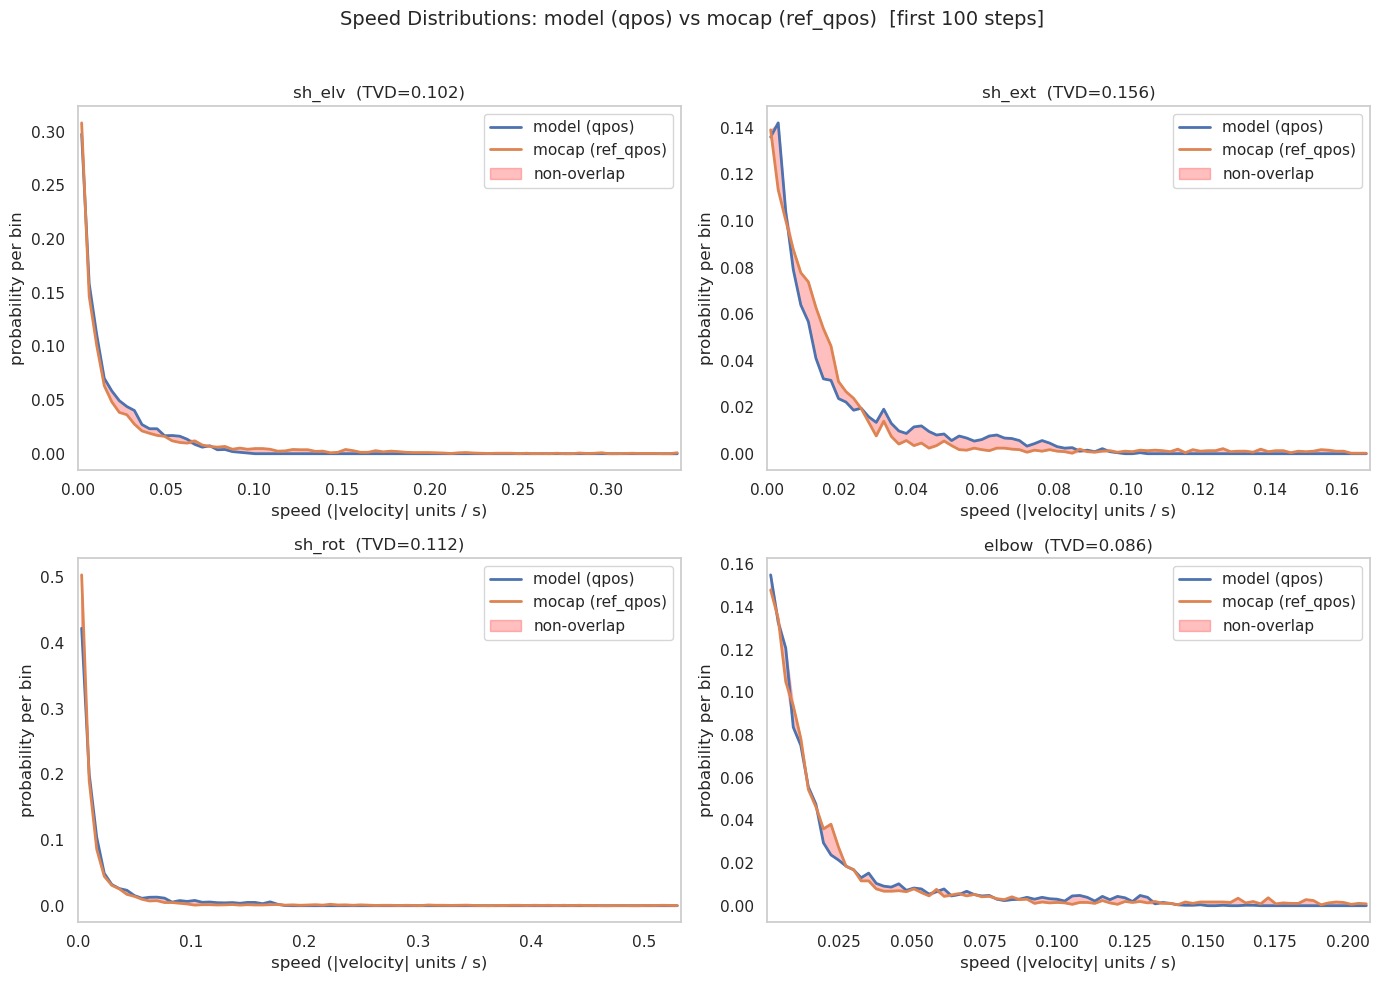

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def compute_velocities(arr: np.ndarray, dt: float = 1.0, method: str = "central") -> np.ndarray:
    """
    Compute time-derivatives (velocities) along the time axis for a batch of clips.

    Args:
        arr: Array shaped (num_clips, T, D), e.g., (46, 200, 4) for qpos.
        dt:  Sample period in seconds. If your sampling rate is Fs Hz, use dt=1/Fs.
        method: One of {"central", "forward"}; "central" uses np.gradient for smoother diffs.

    Returns:
        vel: Array shaped (num_clips, T, D) with per-timestep velocities.
    """
    if method not in {"central", "forward"}:
        raise ValueError("method must be 'central' or 'forward'")

    if method == "central":
        vel = np.gradient(arr, dt, axis=1)  # preserves length T
    else:
        diff = np.diff(arr, axis=1, prepend=arr[:, :1, :])
        vel = diff / dt
    return vel


def plot_velocity_histograms_with_nonoverlap(
    qpos: np.ndarray,
    ref_qpos: np.ndarray,
    qpos_names: list,
    bins: int = 80,
    dt: float = 1.0,
    figsize: tuple = (14, 10),
    suptitle: str = "Speed Distributions: model (qpos) vs mocap (ref_qpos)",
    kde: bool = False,
    robust_percentiles: tuple = (0.5, 99.5),
    epsilon: float = 1e-9,
    T_slice: int = 100,
):
    """
    Compare absolute velocity (speed) histograms per joint for model vs mocap, using only
    the first T_slice timesteps of each clip. Normalize each histogram to sum to 1 and
    shade the non-overlap (red) between the two per-bin probabilities.

    Args:
        qpos:       (N, T, D) model joint angles.
        ref_qpos:   (N, T, D) mocap joint angles.
        qpos_names: List of D joint names (len == D).
        bins:       Number of bins (shared) for the discrete distributions.
        dt:         Sample period in seconds for velocity computation.
        figsize:    Matplotlib figure size.
        suptitle:   Title for the entire figure.
        kde:        If True, overlay seaborn KDE lines (visual only).
        robust_percentiles: Percentile range to set x-limits robustly, e.g. (0.5, 99.5).
        epsilon:    Threshold for declaring non-overlap (binwise difference).
        T_slice:    Number of timesteps to include from the start of each clip.

    Returns:
        None. Displays the figure.
    """
    assert qpos.shape == ref_qpos.shape, "qpos and ref_qpos must have identical shape (N, T, D)"
    N, T, D = qpos.shape
    assert D == len(qpos_names), "qpos_names length must match last dim of qpos/ref_qpos"
    T_slice = min(T_slice, T)

    sns.set(style="whitegrid")

    # Velocities (absolute value = speed)
    v_model = np.abs(compute_velocities(qpos, dt=dt, method="central"))
    v_ref   = np.abs(compute_velocities(ref_qpos, dt=dt, method="central"))

    # Only keep first T_slice timesteps; flatten across clips and time => (N*T_slice,)
    v_model_flat = [v_model[:, :T_slice, j].reshape(-1) for j in range(D)]
    v_ref_flat   = [v_ref[:, :T_slice, j].reshape(-1)   for j in range(D)]

    ncols = min(2, D)
    nrows = int(np.ceil(D / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for j in tqdm(range(D), desc="Plotting joints"):
        ax = axes[j // ncols, j % ncols]
        xm = v_model_flat[j]
        xr = v_ref_flat[j]

        # Robust common x-range from percentiles
        lo = np.nanmin([
            np.percentile(xm, robust_percentiles[0]),
            np.percentile(xr, robust_percentiles[0])
        ])
        hi = np.nanmax([
            np.percentile(xm, robust_percentiles[1]),
            np.percentile(xr, robust_percentiles[1])
        ])

        # Shared edges; compute discrete probabilities (sum to 1)
        bins_edges = np.linspace(lo, hi, bins + 1)
        m_counts, _ = np.histogram(xm, bins=bins_edges, density=False)
        r_counts, _ = np.histogram(xr, bins=bins_edges, density=False)

        m_hist = m_counts / max(np.sum(m_counts), 1)
        r_hist = r_counts / max(np.sum(r_counts), 1)

        centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])

        # Plot
        ax.plot(centers, m_hist, label="model (qpos)", linewidth=2)
        ax.plot(centers, r_hist, label="mocap (ref_qpos)", linewidth=2)

        # Shade non-overlap
        upper = np.maximum(m_hist, r_hist)
        lower = np.minimum(m_hist, r_hist)
        diff  = upper - lower
        mask  = diff > epsilon
        if np.any(mask):
            ax.fill_between(centers, lower, upper, where=mask,
                            alpha=0.25, color="red", interpolate=True, label="non-overlap")

        if kde:
            sns.kdeplot(x=xm, ax=ax, lw=1, alpha=0.7)
            sns.kdeplot(x=xr, ax=ax, lw=1, alpha=0.7)

        tvd = 0.5 * np.sum(np.abs(m_hist - r_hist))
        ax.set_title(f"{qpos_names[j]}  (TVD={tvd:.3f})", fontsize=12)
        ax.set_xlabel("speed (|velocity| units / s)")
        ax.set_ylabel("probability per bin")
        ax.set_xlim(lo, hi)
        ax.legend(loc="best")
        ax.grid(False)

    for k in range(D, nrows * ncols):
        axes[k // ncols, k % ncols].axis("off")

    fig.suptitle(suptitle + f"  [first {T_slice} steps]", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Example call
plot_velocity_histograms_with_nonoverlap(
    qpos=qpos,
    ref_qpos=ref_qpos,
    qpos_names=["sh_elv", "sh_ext", "sh_rot", "elbow"],
    bins=80,
    dt=1.0,
    kde=False,
    T_slice=100,
)


/tmp/ipykernel_245238/1699798569.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat(frames, ignore_index=True)


Train reaches: [0, 1, 2, 3, 4]... (+36 total)
Test  reaches: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Embedding margin (samples): 9
lib: 10 91 410 491 810 891 1210 1291 1610 1691 2010 2091 2410 2491 2810 2891 3210 3291 3610 3691 4010 409...
pred: 14410 14491 14810 14891 15210 15291 15610 15691 16010 16091 16410 16491 16810 16891 17210 17291 1761...
Predictor dims (total embedded columns): 71


Simplex (embedded joints+actions → EMG): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


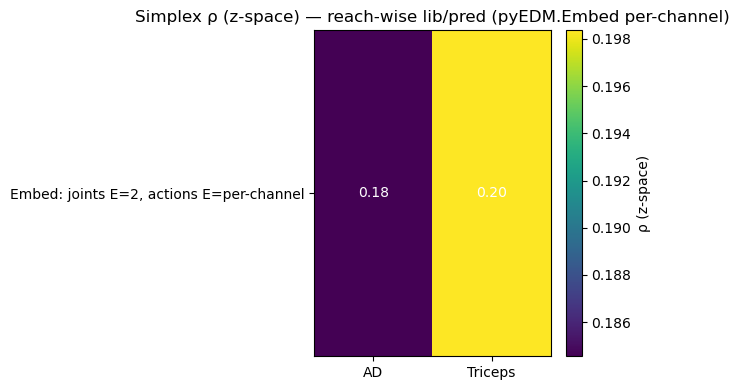

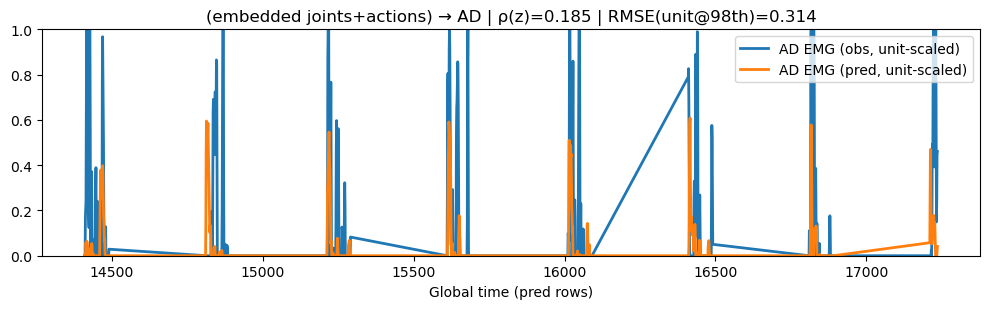

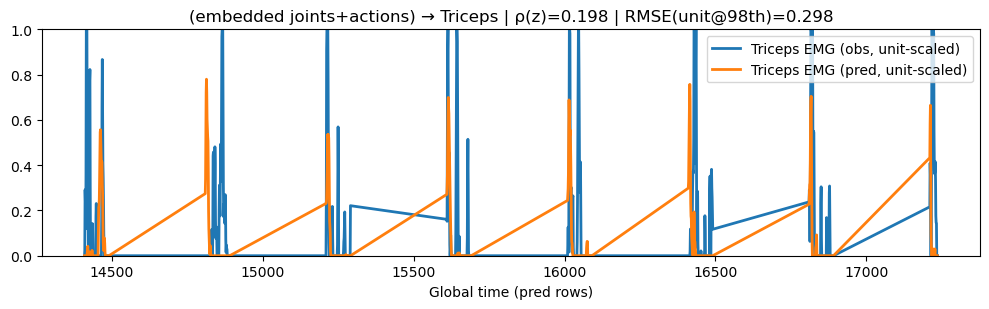

         rho_z  rmse_unit_p98
AD       0.185          0.314
Triceps  0.198          0.298


In [ ]:
# %%time
# === Simplex: EMG from (ref_qpos joints + actions) with pyEDM.Embed (per-channel E) ===
# - Per-reach z-scoring for fit (keeps geometry good for Simplex)
# - Variable embedding per action via pyEDM.Embed; joints E=2
# - Reach-aware lib/pred (padding-invariant)
# - ρ computed in z-space; optional 0–1 unit RMSE for interpretability (post-hoc)
import os, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyEDM import Simplex, Embed

# ---------------- Config -----------------------------------------------------------
H5_PATH = "rollouts_full_mouse_arm_new_250826_222716_299414.h5"  # contains 'actions'
OUT_DIR = "simplex_embed_per_action_reachwise"
os.makedirs(OUT_DIR, exist_ok=True)

# Channels
qpos_names   = ["sh_elv", "sh_ext", "sh_rot", "elbow"]
action_names = [f"act{i}" for i in range(9)]

# Embedding design (per-channel E); tau<0 = past lags
JOINT_E  = 2
JOINT_TAU = -1

ACTION_E = {
    "act0": 6, "act1": 10, "act2": 5, "act3": 5, "act4": 10,
    "act5": 6, "act6": 8,  "act7": 6,  "act8": 7
}
ACTION_TAU = -1  # 1-sample step between action lags

Tp = 1          # prediction horizon (samples)
PAD = 300       # NaN gap between reaches (PAD-invariant lib/pred used)
TEST_REACHES_LAST = 10  # last R_test reaches for prediction

# Plot/RMSE unit scaling (post-hoc, does not affect fit or ρ)
DO_UNIT_RMSE_PLOTS = True
UNIT_PCT = 98
FIRST_N_PLOT = 600

# ---------------- Helpers ----------------------------------------------------------
def zscore(x, axis=None, eps=1e-12):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / np.maximum(sd, eps)

def concat_with_gaps_multi(emg_stack: dict[str, np.ndarray],
                           qpos_stack: np.ndarray,
                           act_stack: np.ndarray,
                           pad=100,
                           standardize=True):
    """
    Return:
      base_df: columns = Time, [EMG names], [qpos_names], [act0..act8]
      starts:  0-based start indices of each reach (in base_df rows)
      T:       number of timepoints per reach
    """
    emg_names = list(emg_stack.keys())
    R, T = next(iter(emg_stack.values())).shape
    J, A = qpos_stack.shape[-1], act_stack.shape[-1]

    frames, starts = [], []
    row_cursor = 0
    for r in range(R):
        if r > 0:
            pad_df = pd.DataFrame({"Time": np.arange(row_cursor+1, row_cursor+pad+1)})
            for nm in emg_names + qpos_names + action_names:
                pad_df[nm] = np.nan
            frames.append(pad_df); row_cursor += pad

        starts.append(row_cursor)  # 0-based row index where this reach block will start
        data = {"Time": np.arange(row_cursor+1, row_cursor+T+1)}

        # EMG (z-score per reach for fit geometry)
        for nm in emg_names:
            x = emg_stack[nm][r]
            data[nm] = zscore(x) if standardize else x

        # qpos
        for j in range(J):
            k = qpos_stack[r, :, j]
            data[qpos_names[j]] = zscore(k) if standardize else k

        # actions
        for a in range(A):
            v = act_stack[r, :, a]
            data[action_names[a]] = zscore(v) if standardize else v

        frames.append(pd.DataFrame(data))
        row_cursor += T

    base_df = pd.concat(frames, ignore_index=True)
    return base_df, np.asarray(starts, dtype=int), T

def reachwise_lib_pred_strings(starts, T, train_reaches, test_reaches, max_lag, Tp):
    """
    Make pyEDM range strings as union of [s,e] per reach with embedding margin.
    Uses 1-based inclusive indices.
    """
    emb_margin = int(max_lag + max(Tp, 0))

    def rng_1based(r):
        s = starts[r] + 1
        e = starts[r] + T
        s2 = s + emb_margin
        e2 = e - emb_margin
        if e2 <= s2:
            return None
        return (s2, e2)

    lib_parts, pred_parts = [], []
    for r in train_reaches:
        rge = rng_1based(r)
        if rge: lib_parts.extend([str(rge[0]), str(rge[1])])
    for r in test_reaches:
        rge = rng_1based(r)
        if rge: pred_parts.extend([str(rge[0]), str(rge[1])])

    lib_str  = " ".join(lib_parts)
    pred_str = " ".join(pred_parts)
    if not lib_str or not pred_str:
        raise RuntimeError("Empty lib/pred after margin guard; reduce lags/Tp or adjust splits.")
    return lib_str, pred_str, emb_margin

def _safe_corr(y, yhat, min_pairs=10):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if m.sum() < min_pairs: return np.nan
    y, yhat = y[m], yhat[m]
    sy, syh = y.std(ddof=0), yhat.std(ddof=0)
    if sy <= 1e-12 or syh <= 1e-12: return np.nan
    return float(np.corrcoef(y, yhat)[0, 1])

def resample_to_len(x, L):
    T = x.shape[-2]
    if T == L: return x
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[..., j]) for j in range(x.shape[-1])], axis=-1)

def linear_unit_scale_pair(a, b, pct=98, clip=True):
    """
    Post-hoc linear scaling for plots/RMSE only (does not affect fit or ρ).
    Scales a & b so pct-th percentile of |[a,b]| maps to 1.
    """
    a = np.asarray(a, float); b = np.asarray(b, float)
    v = np.concatenate([a[np.isfinite(a)], b[np.isfinite(b)]])
    p = np.nanpercentile(np.abs(v), pct) if v.size else 1.0
    if not np.isfinite(p) or p <= 0: p = 1.0
    a2, b2 = a / p, b / p
    if clip:
        a2 = np.clip(a2, 0.0, 1.0); b2 = np.clip(b2, 0.0, 1.0)
    return a2, b2, p

# ---------------- Prereqs: emg_stack/ref_sel/common_trials expected ----------------
# emg_stack: dict name -> (R,T)   | ref_sel: (R,T,4)   | common_trials: list of reach idxs to use
if 'emg_stack' not in globals() or 'ref_sel' not in globals() or 'common_trials' not in globals():
    raise RuntimeError("Please run your EMG/ref_qpos processing first (emg_stack, ref_sel, common_trials).")

# ---------------- Load & align actions --------------------------------------------
with h5py.File(H5_PATH, "r") as f:
    if "actions" not in f:
        raise KeyError("Dataset 'actions' not found in H5.")
    actions_h5 = f["actions"][...]  # (R_sim, T, 9)

target_T = next(iter(emg_stack.values())).shape[1]
if actions_h5.shape[-2] != target_T:
    actions_h5 = np.stack([resample_to_len(actions_h5[i], target_T)
                           for i in range(actions_h5.shape[0])], axis=0)

# Align to the EMG trial list order
if max(common_trials) < actions_h5.shape[0]:
    act_sel = actions_h5[common_trials]  # (R,T,9)
else:
    Rcap = min(len(common_trials), actions_h5.shape[0])
    act_sel = actions_h5[:Rcap]
    # also trim emg_stack/ref_sel if needed
    for k in list(emg_stack.keys()):
        emg_stack[k] = emg_stack[k][:Rcap]
    ref_sel = ref_sel[:Rcap]

# ---------------- Build base DataFrame (z-scored per reach) -----------------------
base_df, starts, T = concat_with_gaps_multi(
    emg_stack=emg_stack, qpos_stack=ref_sel, act_stack=act_sel,
    pad=PAD, standardize=True
)
R = len(starts)

# ---------------- Reach-wise lib/pred (padding-invariant) -------------------------
# Compute MAX_LAG from the largest (E-1)*|tau| across all embedded predictors
max_joint_lag = (JOINT_E - 1) * abs(JOINT_TAU)
max_action_lag = max((ACTION_E[a] - 1) * abs(ACTION_TAU) for a in ACTION_E)
MAX_LAG = max(max_joint_lag, max_action_lag)

test_reaches  = list(range(R - TEST_REACHES_LAST, R))
train_reaches = [r for r in range(R) if r not in test_reaches]

lib, pred, emb_margin = reachwise_lib_pred_strings(
    starts=starts, T=T, train_reaches=train_reaches, test_reaches=test_reaches,
    max_lag=MAX_LAG, Tp=Tp
)
print(f"Train reaches: {train_reaches[:5]}... (+{len(train_reaches)} total)")
print(f"Test  reaches: {test_reaches}")
print("Embedding margin (samples):", emb_margin)
print("lib:", lib[:100] + ("..." if len(lib) > 100 else ""))
print("pred:", pred[:100] + ("..." if len(pred) > 100 else ""))

# ---------------- Build embedded predictor columns with pyEDM.Embed ----------------
# We'll embed each predictor separately with its own E,tau and then concat all columns.
# Keep 'Time' and target EMG columns from base_df.
targets = list(emg_stack.keys())  # e.g., ['AD','Triceps','Biceps']

# Start with Time + targets in the final DataFrame
final_df = base_df[["Time"] + targets].copy()

# Joints: same E for all joints
joint_emb_cols_all = []
for j in qpos_names:
    # Embed returns only embedded columns; includeTime=False to avoid duplicate Time cols
    df_emb = Embed(dataFrame=base_df, E=JOINT_E, tau=JOINT_TAU, columns=[j], includeTime=False)
    # Make column names unique & informative (prefix with 'J:')
    df_emb.columns = [f"J:{j}|{c}" for c in df_emb.columns]
    final_df = final_df.join(df_emb)
    joint_emb_cols_all += list(df_emb.columns)

# Actions: per-action E per ACTION_E
action_emb_cols_all = []
for a in action_names:
    E_a = ACTION_E.get(a, 1)
    if E_a < 1:
        continue
    df_emb = Embed(dataFrame=base_df, E=E_a, tau=ACTION_TAU, columns=[a], includeTime=False)
    df_emb.columns = [f"A:{a}|{c}" for c in df_emb.columns]
    final_df = final_df.join(df_emb)
    action_emb_cols_all += list(df_emb.columns)

predictor_cols = joint_emb_cols_all + action_emb_cols_all
print(f"Predictor dims (total embedded columns): {len(predictor_cols)}")

# ---------------- Simplex (fit & ρ in z-space) ------------------------------------
rhos = {}
pred_store = {}

for t in tqdm(targets, desc="Simplex (embedded joints+actions → EMG)"):
    pred_df = Simplex(
        dataFrame=final_df,
        lib=lib, pred=pred,
        columns=" ".join(predictor_cols),
        target=t,
        E=len(predictor_cols), tau=0, Tp=Tp,   # tau ignored when embedded=True
        embedded=True,
        ignoreNan=True, showPlot=False
    )
    obs = pred_df["Observations"].to_numpy()
    hat = pred_df["Predictions"].to_numpy()
    rhos[t] = _safe_corr(obs, hat, min_pairs=10)  # correlation in z-score space
    pred_store[t] = pred_df.copy()

# ---------------- Save ρ heatmap (z-space) ----------------------------------------
rho_df = pd.Series(rhos, name="rho_z").to_frame()
rho_df.to_csv(os.path.join(OUT_DIR, "rho_zspace_embed_per_action.csv"), float_format="%.6f")

fig, ax = plt.subplots(figsize=(4 + 1.2*len(rho_df), 4))
vals = rho_df["rho_z"].to_numpy()[None, :]
im = ax.imshow(vals, aspect="auto")
ax.set_xticks(range(len(rho_df.index))); ax.set_xticklabels(rho_df.index, rotation=0)
ax.set_yticks([0]); ax.set_yticklabels([f"Embed: joints E={JOINT_E}, actions E=per-channel"])
ax.set_title("Simplex ρ (z-space) — reach-wise lib/pred (pyEDM.Embed per-channel)")
cbar = plt.colorbar(im, ax=ax); cbar.set_label("ρ (z-space)")
for j, v in enumerate(rho_df["rho_z"].to_numpy()):
    ax.text(j, 0, "nan" if np.isnan(v) else f"{v:.2f}", ha="center", va="center", color="white", fontsize=10)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "rho_heatmap_zspace_embed_per_action.png"), dpi=150); plt.show()

# ---------------- Optional: 0–1 unit RMSE plots (post-hoc scaling) ----------------
if DO_UNIT_RMSE_PLOTS:
    rmse_unit = {}
    for t in targets:
        dfp = pred_store[t]
        obs_z = dfp["Observations"].to_numpy()
        hat_z = dfp["Predictions"].to_numpy()
        ou, hu, p = linear_unit_scale_pair(obs_z, hat_z, pct=UNIT_PCT, clip=True)
        rmse_u = float(np.sqrt(np.nanmean((ou - hu)**2)))
        rmse_unit[t] = rmse_u

        K = min(FIRST_N_PLOT, len(dfp))
        t_axis = dfp["Time"].iloc[:K].to_numpy() if "Time" in dfp.columns else np.arange(K)
        plt.figure(figsize=(10,3.2))
        plt.plot(t_axis, ou[:K], label=f"{t} EMG (obs, unit-scaled)", linewidth=2)
        plt.plot(t_axis, hu[:K], label=f"{t} EMG (pred, unit-scaled)", linewidth=2)
        plt.ylim(0, 1)
        plt.title(f"(embedded joints+actions) → {t} | ρ(z)={rhos[t]:.3f} | RMSE(unit@{UNIT_PCT}th)={rmse_u:.3f}")
        plt.xlabel("Global time (pred rows)"); plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"trace_predict_{t}_unitRMSE_embed_per_action.png"), dpi=150)
        plt.show()

    metrics_df = pd.DataFrame({"rho_z": pd.Series(rhos),
                               f"rmse_unit_p{UNIT_PCT}": pd.Series(rmse_unit)})
    metrics_df.to_csv(os.path.join(OUT_DIR, f"metrics_rhoZ_rmseUnit_embed_per_action_p{UNIT_PCT}.csv"),
                      float_format="%.6f")
    print(metrics_df.round(3))